In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD
from vis.utils import utils

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Dataset_4850"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 4850
Label: 1	Family:              PG	Number of images: 4850
Processing images ...
Images processed: 9700


In [4]:
X.shape

(9700, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
print("Extracting features from ResNet50 layers ...")
resnet50features = base_model.predict(X)

Extracting features from ResNet50 layers ...


In [8]:
print(resnet50features)

[[  6.21723123e-02   1.23327649e+00   1.89583078e-02 ...,   1.53622776e-01
    1.30329326e-01   0.00000000e+00]
 [  1.91625115e-02   1.19747758e+00   0.00000000e+00 ...,   6.15143299e-01
    5.54953702e-02   5.41768193e-01]
 [  0.00000000e+00   0.00000000e+00   2.14203313e-01 ...,   6.29584789e-01
    2.03586370e-02   3.62280190e-01]
 ..., 
 [  2.79492259e+00   1.92732085e-02   3.54769611e+00 ...,   2.00485498e-01
    8.01111162e-02   2.91278213e-02]
 [  7.15426542e-03   1.46480727e+00   7.52963945e-02 ...,   7.44437054e-03
    3.66436690e-02   7.13202059e-02]
 [  6.33435324e-02   9.37643927e-03   6.70037493e-02 ...,   1.13137627e+00
    3.90157395e-04   1.20093323e-01]]


In [9]:
resnet50features.shape

(9700, 2048)

In [11]:
# Adding a custom top layer to the model
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [12]:
# Creating the top model for pre-training
bottleneck_features = Input(shape=resnet50features.shape[1:], name='bottleneck_features')
predictions = Dense(num_classes, activation='softmax', name='predictions')(bottleneck_features)
top_model = Model(inputs=bottleneck_features, outputs=predictions)
top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck_features (InputLa (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 4098      
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [14]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=200
history = []
tophistory = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='cg-resnet50-pretrained-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()
init_top_weights = top_model.get_weights()

In [15]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    resnet50features_train = resnet50features[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    resnet50features_test = resnet50features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
  
    print("[%d] Pre-training the top model ..." %(i))

    top_model.set_weights(init_top_weights)

    y_prob = top_model.predict(resnet50features_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    start = time.time()
    h = top_model.fit(resnet50features_train, Y_train, validation_data=(resnet50features_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    tophistory.append(h)
    
    pretrained_top_weights = top_model.get_weights()
          
    y_prob = top_model.predict(resnet50features_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Pre-trained acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
   
    print("[%d] Fine-tuning the model ..." %(i))

    model.set_weights(init_weights)
    model.layers[-1].set_weights(init_top_weights)
    
    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Initial acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    model.layers[-1].set_weights(pretrained_top_weights)

    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Pre-trained acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))    
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
        
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Pre-training the top model ...
[0] Initial acurracy (top_model): 0.3918
Train on 7760 samples, validate on 1940 samples
Epoch 1/200
7760/7760 [==============================] - 1s - loss: 0.4011 - acc: 0.8184 - val_loss: 0.2771 - val_acc: 0.8861
Epoch 2/200
7760/7760 [==============================] - 0s - loss: 0.2421 - acc: 0.9001 - val_loss: 0.2386 - val_acc: 0.8995
Epoch 3/200
7760/7760 [==============================] - 0s - loss: 0.2028 - acc: 0.9187 - val_loss: 0.2320 - val_acc: 0.9005
Epoch 4/200
7760/7760 [==============================] - 0s - loss: 0.1800 - acc: 0.9295 - val_loss: 0.2110 - val_acc: 0.9149
Epoch 5/200
7760/7760 [==============================] - 0s - loss: 0.1727 - acc: 0.9307 - val_loss: 0.2114 - val_acc: 0.9170
Epoch 6/200
7760/7760 [==============================] - 0s - loss: 0.1577 - acc: 0.9409 - val_loss: 0.2117 - val_acc: 0.9186
Epoch 7/200
7760/7760 [==============================] - 0s - loss: 0.1479 - acc: 0.9445 - val_loss: 0.2107 - val_acc: 0

7760/7760 [==============================] - 0s - loss: 0.0121 - acc: 0.9996 - val_loss: 0.4758 - val_acc: 0.9067
Epoch 129/200
7760/7760 [==============================] - 0s - loss: 0.0117 - acc: 0.9997 - val_loss: 0.4802 - val_acc: 0.9088
Epoch 130/200
7760/7760 [==============================] - 0s - loss: 0.0113 - acc: 0.9999 - val_loss: 0.4862 - val_acc: 0.9067
Epoch 131/200
7760/7760 [==============================] - 0s - loss: 0.0113 - acc: 0.9999 - val_loss: 0.4780 - val_acc: 0.9108
Epoch 132/200
7760/7760 [==============================] - 0s - loss: 0.0110 - acc: 0.9999 - val_loss: 0.4848 - val_acc: 0.9113
Epoch 133/200
7760/7760 [==============================] - 0s - loss: 0.0121 - acc: 0.9997 - val_loss: 0.4887 - val_acc: 0.9077
Epoch 134/200
7760/7760 [==============================] - 0s - loss: 0.0116 - acc: 0.9997 - val_loss: 0.5013 - val_acc: 0.9057
Epoch 135/200
7760/7760 [==============================] - 0s - loss: 0.0119 - acc: 0.9995 - val_loss: 0.5007 - val_ac

7760/7760 [==============================] - 82s - loss: 0.0023 - acc: 0.9996 - val_loss: 0.5116 - val_acc: 0.9242
Epoch 55/200
7760/7760 [==============================] - 83s - loss: 9.4617e-04 - acc: 0.9999 - val_loss: 0.5154 - val_acc: 0.9232
Epoch 56/200
7760/7760 [==============================] - 82s - loss: 0.0023 - acc: 0.9995 - val_loss: 0.5166 - val_acc: 0.9216
Epoch 57/200
7760/7760 [==============================] - 83s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.5190 - val_acc: 0.9232
Epoch 58/200
7760/7760 [==============================] - 82s - loss: 0.0011 - acc: 0.9997 - val_loss: 0.5228 - val_acc: 0.9211
Epoch 59/200
7760/7760 [==============================] - 83s - loss: 0.0025 - acc: 0.9994 - val_loss: 0.5177 - val_acc: 0.9216
Epoch 60/200
7760/7760 [==============================] - 82s - loss: 0.0011 - acc: 0.9997 - val_loss: 0.5309 - val_acc: 0.9216
Epoch 61/200
7760/7760 [==============================] - 83s - loss: 5.9716e-04 - acc: 0.9999 - val_loss: 0.5237

7760/7760 [==============================] - 83s - loss: 1.0755e-04 - acc: 1.0000 - val_loss: 0.4887 - val_acc: 0.9263
Epoch 178/200
7760/7760 [==============================] - 82s - loss: 6.5177e-04 - acc: 0.9997 - val_loss: 0.4880 - val_acc: 0.9273
Epoch 179/200
7760/7760 [==============================] - 82s - loss: 1.2179e-04 - acc: 1.0000 - val_loss: 0.4893 - val_acc: 0.9268
Epoch 180/200
7760/7760 [==============================] - 82s - loss: 5.0480e-04 - acc: 0.9997 - val_loss: 0.4867 - val_acc: 0.9268
Epoch 181/200
7760/7760 [==============================] - 82s - loss: 3.3812e-04 - acc: 0.9999 - val_loss: 0.4875 - val_acc: 0.9284
Epoch 182/200
7760/7760 [==============================] - 82s - loss: 1.2691e-04 - acc: 1.0000 - val_loss: 0.4923 - val_acc: 0.9278
Epoch 183/200
7760/7760 [==============================] - 83s - loss: 1.5441e-04 - acc: 1.0000 - val_loss: 0.4919 - val_acc: 0.9278
Epoch 184/200
7760/7760 [==============================] - 83s - loss: 8.6331e-05 -

7760/7760 [==============================] - 0s - loss: 0.0119 - acc: 0.9997 - val_loss: 0.5602 - val_acc: 0.8918
Epoch 104/200
7760/7760 [==============================] - 0s - loss: 0.0110 - acc: 1.0000 - val_loss: 0.5726 - val_acc: 0.8938
Epoch 105/200
7760/7760 [==============================] - 0s - loss: 0.0114 - acc: 0.9999 - val_loss: 0.5581 - val_acc: 0.8974
Epoch 106/200
7760/7760 [==============================] - 0s - loss: 0.0129 - acc: 0.9996 - val_loss: 0.5611 - val_acc: 0.8959
Epoch 107/200
7760/7760 [==============================] - 0s - loss: 0.0114 - acc: 0.9997 - val_loss: 0.5680 - val_acc: 0.8954
Epoch 108/200
7760/7760 [==============================] - 0s - loss: 0.0107 - acc: 1.0000 - val_loss: 0.5767 - val_acc: 0.8938
Epoch 109/200
7760/7760 [==============================] - 0s - loss: 0.0108 - acc: 0.9999 - val_loss: 0.5860 - val_acc: 0.8892
Epoch 110/200
7760/7760 [==============================] - 0s - loss: 0.0104 - acc: 0.9996 - val_loss: 0.5707 - val_ac

7760/7760 [==============================] - 82s - loss: 0.0017 - acc: 0.9994 - val_loss: 0.6966 - val_acc: 0.9026
Epoch 31/200
7760/7760 [==============================] - 83s - loss: 9.2294e-04 - acc: 0.9999 - val_loss: 0.6892 - val_acc: 0.9041
Epoch 32/200
7760/7760 [==============================] - 83s - loss: 0.0014 - acc: 0.9999 - val_loss: 0.6918 - val_acc: 0.9041
Epoch 33/200
7760/7760 [==============================] - 83s - loss: 9.7520e-04 - acc: 0.9999 - val_loss: 0.6883 - val_acc: 0.9041
Epoch 34/200
7760/7760 [==============================] - 83s - loss: 7.6924e-04 - acc: 0.9999 - val_loss: 0.6919 - val_acc: 0.9041
Epoch 35/200
7760/7760 [==============================] - 82s - loss: 6.3061e-04 - acc: 0.9999 - val_loss: 0.6862 - val_acc: 0.9036
Epoch 36/200
7760/7760 [==============================] - 83s - loss: 0.0010 - acc: 0.9997 - val_loss: 0.6816 - val_acc: 0.9026
Epoch 37/200
7760/7760 [==============================] - 83s - loss: 4.3136e-04 - acc: 1.0000 - val_

7760/7760 [==============================] - 83s - loss: 3.5904e-04 - acc: 0.9999 - val_loss: 0.6916 - val_acc: 0.9046
Epoch 154/200
7760/7760 [==============================] - 83s - loss: 7.1585e-04 - acc: 0.9997 - val_loss: 0.6945 - val_acc: 0.9036
Epoch 155/200
7760/7760 [==============================] - 83s - loss: 3.0172e-04 - acc: 1.0000 - val_loss: 0.7156 - val_acc: 0.9015
Epoch 156/200
7760/7760 [==============================] - 82s - loss: 2.5802e-04 - acc: 1.0000 - val_loss: 0.7002 - val_acc: 0.9026
Epoch 157/200
7760/7760 [==============================] - 83s - loss: 3.0123e-04 - acc: 1.0000 - val_loss: 0.6925 - val_acc: 0.9026
Epoch 158/200
7760/7760 [==============================] - 83s - loss: 3.3557e-04 - acc: 1.0000 - val_loss: 0.6895 - val_acc: 0.9021
Epoch 159/200
7760/7760 [==============================] - 82s - loss: 2.6457e-04 - acc: 0.9999 - val_loss: 0.6812 - val_acc: 0.9036
Epoch 160/200
7760/7760 [==============================] - 82s - loss: 1.1337e-04 -

7760/7760 [==============================] - 0s - loss: 0.0273 - acc: 0.9966 - val_loss: 0.3620 - val_acc: 0.9113
Epoch 79/200
7760/7760 [==============================] - 0s - loss: 0.0272 - acc: 0.9963 - val_loss: 0.3606 - val_acc: 0.9129
Epoch 80/200
7760/7760 [==============================] - 0s - loss: 0.0266 - acc: 0.9970 - val_loss: 0.3671 - val_acc: 0.9124
Epoch 81/200
7760/7760 [==============================] - 0s - loss: 0.0268 - acc: 0.9972 - val_loss: 0.3590 - val_acc: 0.9160
Epoch 82/200
7760/7760 [==============================] - 0s - loss: 0.0258 - acc: 0.9968 - val_loss: 0.3614 - val_acc: 0.9155
Epoch 83/200
7760/7760 [==============================] - 0s - loss: 0.0255 - acc: 0.9976 - val_loss: 0.3630 - val_acc: 0.9144
Epoch 84/200
7760/7760 [==============================] - 0s - loss: 0.0249 - acc: 0.9969 - val_loss: 0.3637 - val_acc: 0.9155
Epoch 85/200
7760/7760 [==============================] - 0s - loss: 0.0251 - acc: 0.9966 - val_loss: 0.3704 - val_acc: 0.91

7760/7760 [==============================] - 82s - loss: 0.0103 - acc: 0.9960 - val_loss: 0.5375 - val_acc: 0.9180
Epoch 6/200
7760/7760 [==============================] - 82s - loss: 0.0074 - acc: 0.9970 - val_loss: 0.5399 - val_acc: 0.9175
Epoch 7/200
7760/7760 [==============================] - 82s - loss: 0.0085 - acc: 0.9965 - val_loss: 0.5326 - val_acc: 0.9196
Epoch 8/200
7760/7760 [==============================] - 82s - loss: 0.0054 - acc: 0.9974 - val_loss: 0.5322 - val_acc: 0.9211
Epoch 9/200
7760/7760 [==============================] - 83s - loss: 0.0049 - acc: 0.9985 - val_loss: 0.5382 - val_acc: 0.9196
Epoch 10/200
7760/7760 [==============================] - 83s - loss: 0.0048 - acc: 0.9982 - val_loss: 0.5287 - val_acc: 0.9216
Epoch 11/200
7760/7760 [==============================] - 82s - loss: 0.0046 - acc: 0.9986 - val_loss: 0.5345 - val_acc: 0.9211
Epoch 12/200
7760/7760 [==============================] - 83s - loss: 0.0033 - acc: 0.9991 - val_loss: 0.5368 - val_acc: 

7760/7760 [==============================] - 83s - loss: 8.9273e-04 - acc: 0.9996 - val_loss: 0.5210 - val_acc: 0.9222
Epoch 131/200
7760/7760 [==============================] - 82s - loss: 5.4422e-04 - acc: 0.9997 - val_loss: 0.5253 - val_acc: 0.9206
Epoch 132/200
7760/7760 [==============================] - 82s - loss: 6.3195e-04 - acc: 0.9999 - val_loss: 0.5213 - val_acc: 0.9211
Epoch 133/200
7760/7760 [==============================] - 82s - loss: 4.2537e-04 - acc: 1.0000 - val_loss: 0.5211 - val_acc: 0.9222
Epoch 134/200
7760/7760 [==============================] - 83s - loss: 1.3595e-04 - acc: 1.0000 - val_loss: 0.5186 - val_acc: 0.9216
Epoch 135/200
7760/7760 [==============================] - 82s - loss: 0.0016 - acc: 0.9997 - val_loss: 0.5203 - val_acc: 0.9196
Epoch 136/200
7760/7760 [==============================] - 82s - loss: 2.1544e-04 - acc: 1.0000 - val_loss: 0.5395 - val_acc: 0.9175
Epoch 137/200
7760/7760 [==============================] - 83s - loss: 2.6438e-04 - acc

7760/7760 [==============================] - 0s - loss: 0.0348 - acc: 0.9928 - val_loss: 0.3727 - val_acc: 0.9015
Epoch 54/200
7760/7760 [==============================] - 0s - loss: 0.0338 - acc: 0.9932 - val_loss: 0.3784 - val_acc: 0.8995
Epoch 55/200
7760/7760 [==============================] - 0s - loss: 0.0341 - acc: 0.9928 - val_loss: 0.3771 - val_acc: 0.9000
Epoch 56/200
7760/7760 [==============================] - 0s - loss: 0.0330 - acc: 0.9927 - val_loss: 0.3924 - val_acc: 0.9010
Epoch 57/200
7760/7760 [==============================] - 0s - loss: 0.0334 - acc: 0.9930 - val_loss: 0.3783 - val_acc: 0.9015
Epoch 58/200
7760/7760 [==============================] - 0s - loss: 0.0307 - acc: 0.9954 - val_loss: 0.3865 - val_acc: 0.9005
Epoch 59/200
7760/7760 [==============================] - 0s - loss: 0.0322 - acc: 0.9929 - val_loss: 0.3857 - val_acc: 0.8985
Epoch 60/200
7760/7760 [==============================] - 0s - loss: 0.0320 - acc: 0.9933 - val_loss: 0.4081 - val_acc: 0.89

7760/7760 [==============================] - 0s - loss: 0.0037 - acc: 1.0000 - val_loss: 0.6743 - val_acc: 0.8938
Epoch 182/200
7760/7760 [==============================] - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 0.6825 - val_acc: 0.8954
Epoch 183/200
7760/7760 [==============================] - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 0.6757 - val_acc: 0.8933
Epoch 184/200
7760/7760 [==============================] - 0s - loss: 0.0034 - acc: 1.0000 - val_loss: 0.6851 - val_acc: 0.8923
Epoch 185/200
7760/7760 [==============================] - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 0.6941 - val_acc: 0.8928
Epoch 186/200
7760/7760 [==============================] - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 0.6944 - val_acc: 0.8912
Epoch 187/200
7760/7760 [==============================] - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 0.6937 - val_acc: 0.8928
Epoch 188/200
7760/7760 [==============================] - 0s - loss: 0.0032 - acc: 1.0000 - val_loss: 0.6906 - val_ac

7760/7760 [==============================] - 83s - loss: 1.6233e-04 - acc: 1.0000 - val_loss: 0.6233 - val_acc: 0.9098
Epoch 106/200
7760/7760 [==============================] - 83s - loss: 6.7481e-04 - acc: 0.9996 - val_loss: 0.6210 - val_acc: 0.9088
Epoch 107/200
7760/7760 [==============================] - 83s - loss: 2.7672e-04 - acc: 1.0000 - val_loss: 0.6186 - val_acc: 0.9093
Epoch 108/200
7760/7760 [==============================] - 83s - loss: 5.9909e-04 - acc: 0.9999 - val_loss: 0.6208 - val_acc: 0.9103
Epoch 109/200
7760/7760 [==============================] - 83s - loss: 1.2426e-04 - acc: 1.0000 - val_loss: 0.6193 - val_acc: 0.9103
Epoch 110/200
7760/7760 [==============================] - 83s - loss: 2.1163e-04 - acc: 1.0000 - val_loss: 0.6170 - val_acc: 0.9098
Epoch 111/200
7760/7760 [==============================] - 83s - loss: 1.2161e-04 - acc: 1.0000 - val_loss: 0.6144 - val_acc: 0.9098
Epoch 112/200
7760/7760 [==============================] - 82s - loss: 2.2833e-04 -

7760/7760 [==============================] - 0s - loss: 0.0653 - acc: 0.9796 - val_loss: 0.2523 - val_acc: 0.9149
Epoch 28/200
7760/7760 [==============================] - 0s - loss: 0.0636 - acc: 0.9809 - val_loss: 0.2521 - val_acc: 0.9134
Epoch 29/200
7760/7760 [==============================] - 0s - loss: 0.0625 - acc: 0.9800 - val_loss: 0.2531 - val_acc: 0.9170
Epoch 30/200
7760/7760 [==============================] - 0s - loss: 0.0623 - acc: 0.9812 - val_loss: 0.2504 - val_acc: 0.9160
Epoch 31/200
7760/7760 [==============================] - 0s - loss: 0.0600 - acc: 0.9820 - val_loss: 0.2846 - val_acc: 0.9057
Epoch 32/200
7760/7760 [==============================] - 0s - loss: 0.0593 - acc: 0.9823 - val_loss: 0.2562 - val_acc: 0.9129
Epoch 33/200
7760/7760 [==============================] - 0s - loss: 0.0595 - acc: 0.9823 - val_loss: 0.2603 - val_acc: 0.9134
Epoch 34/200
7760/7760 [==============================] - 0s - loss: 0.0565 - acc: 0.9852 - val_loss: 0.2550 - val_acc: 0.91

7760/7760 [==============================] - 0s - loss: 0.0084 - acc: 1.0000 - val_loss: 0.5405 - val_acc: 0.9031
Epoch 156/200
7760/7760 [==============================] - 0s - loss: 0.0078 - acc: 1.0000 - val_loss: 0.5433 - val_acc: 0.9015
Epoch 157/200
7760/7760 [==============================] - 0s - loss: 0.0079 - acc: 1.0000 - val_loss: 0.5441 - val_acc: 0.9021
Epoch 158/200
7760/7760 [==============================] - 0s - loss: 0.0079 - acc: 0.9999 - val_loss: 0.5494 - val_acc: 0.9026
Epoch 159/200
7760/7760 [==============================] - 0s - loss: 0.0079 - acc: 1.0000 - val_loss: 0.5503 - val_acc: 0.9021
Epoch 160/200
7760/7760 [==============================] - 0s - loss: 0.0084 - acc: 1.0000 - val_loss: 0.5490 - val_acc: 0.9031
Epoch 161/200
7760/7760 [==============================] - 0s - loss: 0.0076 - acc: 1.0000 - val_loss: 0.5448 - val_acc: 0.9052
Epoch 162/200
7760/7760 [==============================] - 0s - loss: 0.0074 - acc: 1.0000 - val_loss: 0.5494 - val_ac

7760/7760 [==============================] - 82s - loss: 7.4656e-04 - acc: 0.9997 - val_loss: 0.4531 - val_acc: 0.9294
Epoch 81/200
7760/7760 [==============================] - 83s - loss: 6.2479e-04 - acc: 0.9997 - val_loss: 0.4501 - val_acc: 0.9294
Epoch 82/200
7760/7760 [==============================] - 83s - loss: 3.3126e-04 - acc: 1.0000 - val_loss: 0.4508 - val_acc: 0.9284
Epoch 83/200
7760/7760 [==============================] - 83s - loss: 7.0132e-04 - acc: 0.9999 - val_loss: 0.4476 - val_acc: 0.9278
Epoch 84/200
7760/7760 [==============================] - 82s - loss: 4.0970e-04 - acc: 1.0000 - val_loss: 0.4456 - val_acc: 0.9299
Epoch 85/200
7760/7760 [==============================] - 82s - loss: 9.8510e-04 - acc: 0.9995 - val_loss: 0.4453 - val_acc: 0.9294
Epoch 86/200
7760/7760 [==============================] - 83s - loss: 0.0010 - acc: 0.9997 - val_loss: 0.4399 - val_acc: 0.9309
Epoch 87/200
7760/7760 [==============================] - 82s - loss: 6.0698e-04 - acc: 0.999

In [16]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9196


In [17]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Accuracy.pdf', format='pdf')
    plt.show()

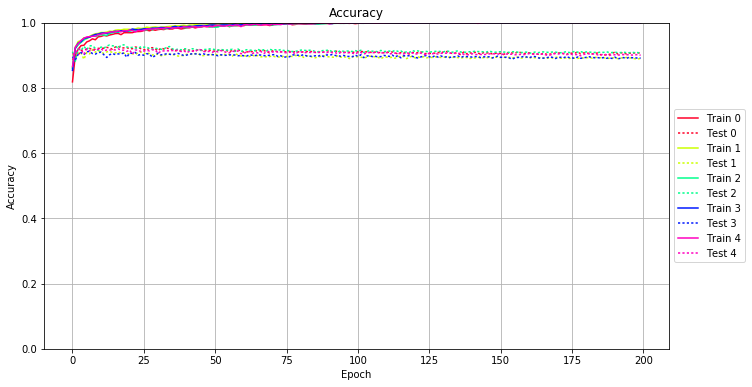

In [18]:
plot_acc(tophistory)

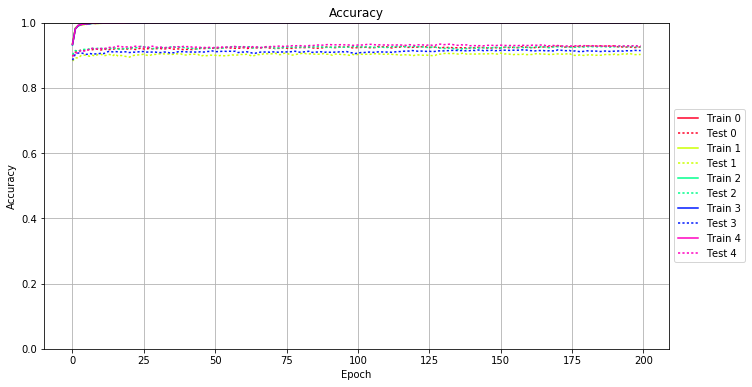

In [19]:
plot_acc(history)

In [20]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Loss.pdf', format='pdf')
    plt.show()

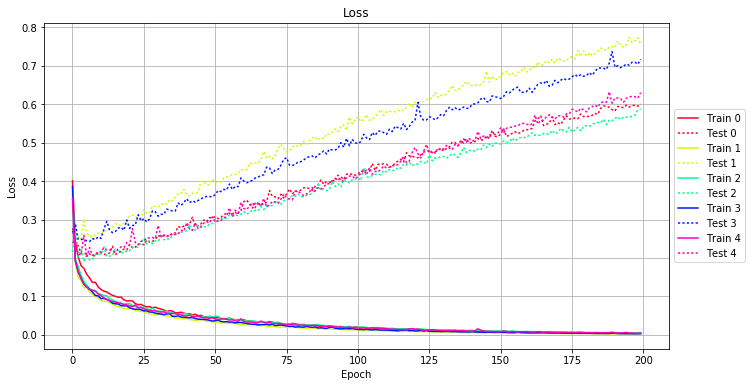

In [21]:
plot_loss(tophistory)

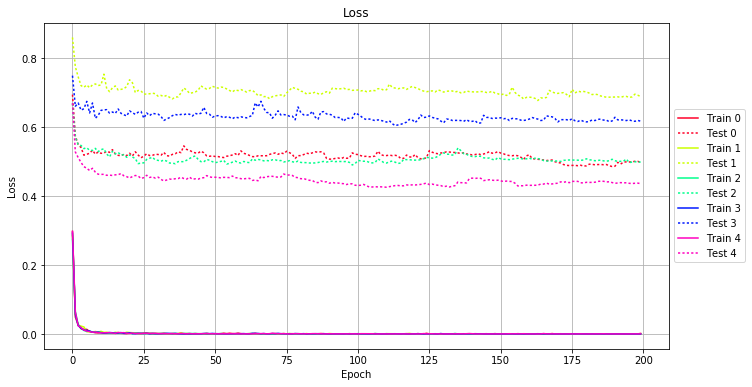

In [22]:
plot_loss(history)

Plotting the confusion matrix


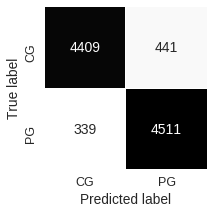

In [23]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


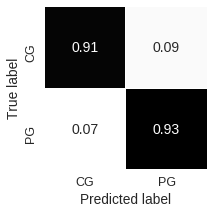

In [24]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
for h in tophistory:
    print(h.history)

{'acc': [0.81842783505154637, 0.90012886597938147, 0.91868556701030923, 0.92951030927835054, 0.93067010309278353, 0.94085051546391751, 0.94445876288659791, 0.95038659793814428, 0.9474226804123711, 0.95657216494845365, 0.95773195876288664, 0.96095360824742271, 0.95914948453608251, 0.96211340206185569, 0.96404639175257734, 0.96636597938144331, 0.96688144329896908, 0.96314432989690724, 0.96907216494845361, 0.96932989690721649, 0.96907216494845361, 0.96932989690721649, 0.97229381443298968, 0.97280927835051545, 0.97306701030927834, 0.97564432989690719, 0.97693298969072162, 0.97499999999999998, 0.97847938144329893, 0.97667525773195873, 0.97873711340206182, 0.97976804123711336, 0.97873711340206182, 0.98195876288659789, 0.98041237113402058, 0.98054123711340202, 0.98350515463917521, 0.98286082474226799, 0.98054123711340202, 0.98208762886597933, 0.98402061855670098, 0.98414948453608242, 0.9864690721649485, 0.98376288659793809, 0.98608247422680417, 0.9864690721649485, 0.98840206185567014, 0.98775

In [26]:
for h in history:
    print(h.history)

{'acc': [0.9338917525773196, 0.98247422680412366, 0.98994845360824746, 0.99445876288659796, 0.99523195876288661, 0.99484536082474229, 0.99742268041237114, 0.9981958762886598, 0.99858247422680413, 0.9990979381443299, 0.99884020618556701, 0.99948453608247423, 0.99922680412371134, 0.99922680412371134, 0.9990979381443299, 0.99896907216494846, 0.99896907216494846, 0.99935567010309279, 0.99935567010309279, 0.99974226804123711, 0.99935567010309279, 0.99922680412371134, 0.99922680412371134, 0.99974226804123711, 0.99961340206185567, 0.99935567010309279, 0.9990979381443299, 0.99974226804123711, 0.99974226804123711, 0.99974226804123711, 0.99961340206185567, 0.99987113402061856, 0.99961340206185567, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 0.99974226804123711, 0.99974226804123711, 0.99948453608247423, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 0.99974226

In [27]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

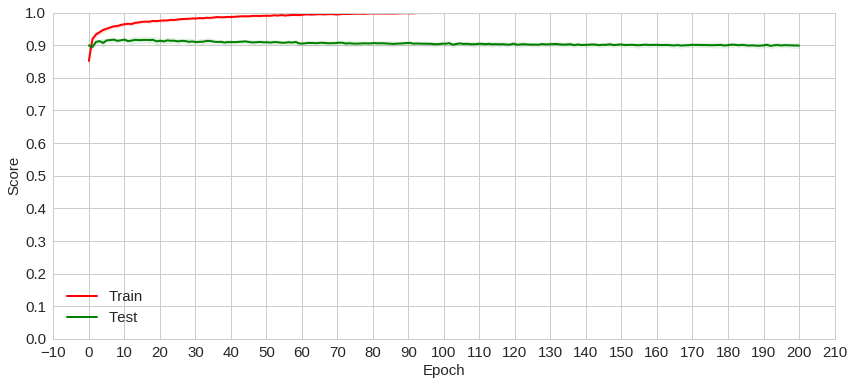

In [28]:
plot_mean_acc(tophistory)

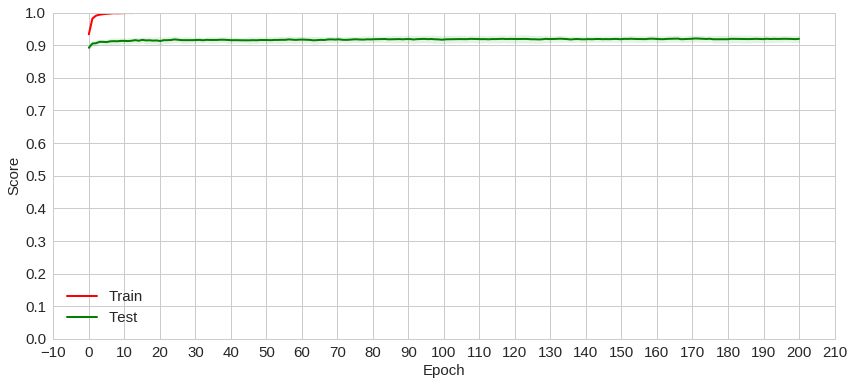

In [29]:
plot_mean_acc(history)

In [30]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

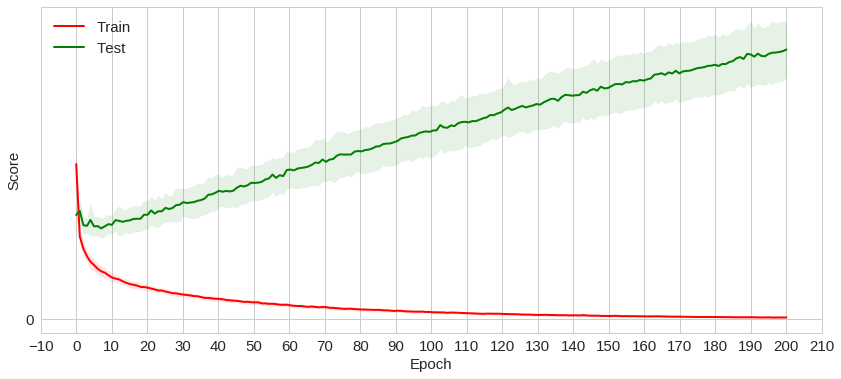

In [31]:
plot_mean_loss(tophistory)

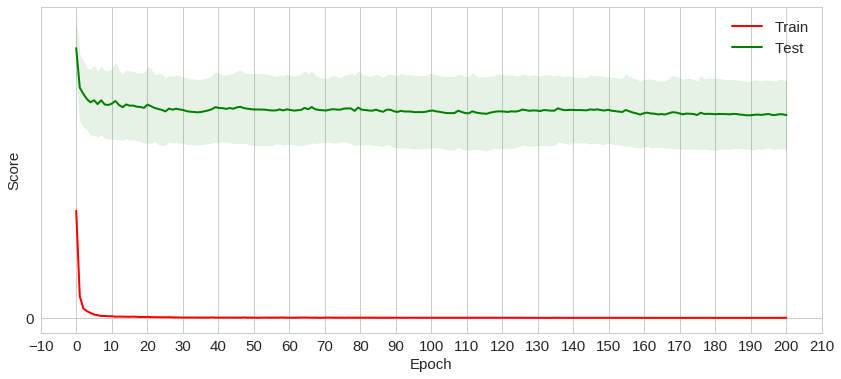

In [32]:
plot_mean_loss(history)

In [33]:
tophistory = [{'acc': [0.81842783505154637, 0.90012886597938147, 0.91868556701030923, 0.92951030927835054, 0.93067010309278353, 0.94085051546391751, 0.94445876288659791, 0.95038659793814428, 0.9474226804123711, 0.95657216494845365, 0.95773195876288664, 0.96095360824742271, 0.95914948453608251, 0.96211340206185569, 0.96404639175257734, 0.96636597938144331, 0.96688144329896908, 0.96314432989690724, 0.96907216494845361, 0.96932989690721649, 0.96907216494845361, 0.96932989690721649, 0.97229381443298968, 0.97280927835051545, 0.97306701030927834, 0.97564432989690719, 0.97693298969072162, 0.97499999999999998, 0.97847938144329893, 0.97667525773195873, 0.97873711340206182, 0.97976804123711336, 0.97873711340206182, 0.98195876288659789, 0.98041237113402058, 0.98054123711340202, 0.98350515463917521, 0.98286082474226799, 0.98054123711340202, 0.98208762886597933, 0.98402061855670098, 0.98414948453608242, 0.9864690721649485, 0.98376288659793809, 0.98608247422680417, 0.9864690721649485, 0.98840206185567014, 0.98775773195876293, 0.9873711340206186, 0.99072164948453612, 0.98930412371134024, 0.9891752577319588, 0.98981958762886602, 0.9900773195876289, 0.99175257731958766, 0.98750000000000004, 0.99123711340206189, 0.99059278350515467, 0.99059278350515467, 0.99162371134020622, 0.99072164948453612, 0.99329896907216497, 0.9927835051546392, 0.99226804123711343, 0.99342783505154642, 0.9927835051546392, 0.99291237113402064, 0.99329896907216497, 0.9936855670103093, 0.99123711340206189, 0.99239690721649487, 0.9954896907216495, 0.99600515463917527, 0.99587628865979383, 0.99574742268041239, 0.99523195876288661, 0.99626288659793816, 0.99355670103092786, 0.99445876288659796, 0.99652061855670104, 0.99652061855670104, 0.99523195876288661, 0.99587628865979383, 0.9963917525773196, 0.99652061855670104, 0.99755154639175259, 0.99742268041237114, 0.9981958762886598, 0.99793814432989691, 0.99755154639175259, 0.99703608247422681, 0.99768041237113403, 0.99858247422680413, 0.99832474226804124, 0.99858247422680413, 0.99793814432989691, 0.99832474226804124, 0.99780927835051547, 0.99845360824742269, 0.99690721649484537, 0.99793814432989691, 0.99871134020618557, 0.9981958762886598, 0.99871134020618557, 0.99935567010309279, 0.99922680412371134, 0.99896907216494846, 0.99896907216494846, 0.99935567010309279, 0.99974226804123711, 0.99922680412371134, 0.9990979381443299, 0.99922680412371134, 0.99948453608247423, 0.99948453608247423, 0.99858247422680413, 0.99935567010309279, 0.99948453608247423, 0.99884020618556701, 0.99948453608247423, 0.99961340206185567, 0.99935567010309279, 0.99948453608247423, 0.99948453608247423, 0.99961340206185567, 0.99961340206185567, 0.99974226804123711, 0.99961340206185567, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 0.99974226804123711, 0.99948453608247423, 0.99987113402061856, 0.99974226804123711, 1.0, 1.0, 0.99948453608247423, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99974226804123711, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99961340206185567, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [0.40112883049188203, 0.24208457906221606, 0.20284547031540232, 0.17996523681375171, 0.17268974879353316, 0.1576517407427129, 0.1479157422928466, 0.1362169792049939, 0.13682492900754989, 0.12448805552167991, 0.11777407205903653, 0.11360380953734683, 0.1114861986071793, 0.10659940095291924, 0.10283919378500624, 0.10019731183641965, 0.097623194155004839, 0.098081545301319392, 0.091019444428768359, 0.088091019902032677, 0.08865576056168252, 0.088215349261293707, 0.081198750576484444, 0.078366707280739065, 0.079231337127611809, 0.075243936279385359, 0.072841642535838885, 0.073418689941622553, 0.070006897907281665, 0.071931450545173331, 0.068907849859331072, 0.067004029729317141, 0.064579557919317909, 0.060665278298031422, 0.062838913638567181, 0.061861592339178949, 0.057020988741639966, 0.057475519426090201, 0.058947718389255485, 0.056257215065439951, 0.05484632798998626, 0.05490268857515964, 0.051762199109977057, 0.05359147766355387, 0.049707544502830998, 0.050466047683442684, 0.046751377627868011, 0.046132215231503411, 0.046644517137985869, 0.044167487921442872, 0.0445919867643376, 0.044922795162065744, 0.042468153270556752, 0.042000164759835014, 0.04161802326741907, 0.04327170651444455, 0.040378637343030613, 0.039224916051343546, 0.039767657443112933, 0.037510456507737489, 0.039077167028618839, 0.036142744396611588, 0.035845165146687598, 0.03487822174661092, 0.033242051641351168, 0.034244271183444051, 0.033704314027557671, 0.03301286633251254, 0.03229779997437271, 0.034516632468583656, 0.033219609824345284, 0.029790250461586971, 0.028979807043659319, 0.028248182787876767, 0.028082617775527473, 0.027364868778236132, 0.028352738759413208, 0.02968964582097899, 0.028826951485165616, 0.027227249718511228, 0.026207125643940316, 0.026919660724929927, 0.025679507730624725, 0.024262676299693659, 0.02500133380946732, 0.023897131374969925, 0.023253326809283385, 0.022630302310373981, 0.022317436272182415, 0.023207876550936209, 0.023423500530920998, 0.022079733305985165, 0.020828555512827696, 0.020769942755398063, 0.020164446974384416, 0.021596314831031967, 0.020174740769506729, 0.020185810574282384, 0.019116670989249018, 0.020843642915493434, 0.01947304396746085, 0.018298403646067246, 0.018602834469110697, 0.017978302481555446, 0.016948526536028102, 0.016716298308300296, 0.017130954558817073, 0.016531124595821518, 0.017139562257786387, 0.016420143469207987, 0.015620643835149935, 0.015532524251023826, 0.014745247600235276, 0.015263064624261611, 0.014682040421157769, 0.015383943462187482, 0.015027061406254153, 0.013852524258119545, 0.016030480110652976, 0.013568884045960976, 0.013600921482999915, 0.013804453984863057, 0.013095922807421171, 0.013478867406236756, 0.012966935682235305, 0.012272647102411414, 0.011478489896608997, 0.012137225055202995, 0.011744851770705169, 0.011278597964453943, 0.011280928521426682, 0.011030098244778274, 0.012066641951114246, 0.011598864614425861, 0.011857097586328837, 0.010547122244060654, 0.010417131305739437, 0.0111729466135508, 0.0099369848339059923, 0.011174466048088885, 0.0099508911808088574, 0.0094546012935641504, 0.0094531859050399243, 0.0088819562217470303, 0.0087278321250965907, 0.0092327063480756952, 0.010310641808204891, 0.0085736020189738759, 0.0090172650503743557, 0.0081388008751973658, 0.008679454104456398, 0.010149445199436441, 0.0090392596232368779, 0.0080936910018094416, 0.0075385400804585407, 0.0076004249442815208, 0.0073554988297605019, 0.0072494238855067604, 0.0072682290280372212, 0.0074216362453766701, 0.0068574992584583072, 0.006916837246378058, 0.0071832921519184231, 0.0078001160582661933, 0.0083448425165771212, 0.0065877820681972598, 0.00643809302758003, 0.0067675073621506539, 0.0062887780464340728, 0.0068932371002804376, 0.0059868477270506402, 0.0059928163165975474, 0.0069121954295323371, 0.0058323395755334002, 0.0057562380664281012, 0.0055674526518806047, 0.0055024122896114571, 0.0056119560244848434, 0.0062585569018037204, 0.0056901232742694848, 0.0053840231937692341, 0.0049237576870190111, 0.0051893360855192255, 0.0049915772248251538, 0.0049934048248819777, 0.0047343392078716727, 0.0049094009289959656, 0.0052376722590517753, 0.0055407312002570663, 0.0045962536784330595, 0.0046131615272540713, 0.0045003543204637534, 0.0043207649568806298, 0.0043130403403768836, 0.0043086636873903043, 0.0041974591283300486, 0.0042085889621263309, 0.0042677810548843106, 0.0040783983367236008, 0.0041187005559193716], 'val_acc': [0.88608247398101181, 0.89948453632826653, 0.90051546416331807, 0.91494845385403978, 0.91701030952414286, 0.91855670127672018, 0.92113402086434903, 0.91752577344166864, 0.91855670127672018, 0.92113402037276437, 0.92113402086434903, 0.92164948478187481, 0.92422680436950366, 0.92216494869940058, 0.91855670127672018, 0.92525773171297054, 0.92731958738307363, 0.92216494857650444, 0.92268041261692635, 0.92319587653445212, 0.92010309290640135, 0.92010309302929749, 0.92525773220455521, 0.92371134045197789, 0.92010309302929749, 0.91752577344166864, 0.91546391764866941, 0.92268041261692635, 0.92319587653445212, 0.91907216470266129, 0.91391752601898824, 0.92216494869940058, 0.91907216519424595, 0.92216494869940058, 0.91907216470266129, 0.91752577295008397, 0.91391752601898824, 0.91443298993651401, 0.91288659769235203, 0.91649484560661709, 0.91597938168909132, 0.91546391777156555, 0.91237113426641092, 0.91649484511503243, 0.91649484560661709, 0.91649484511503243, 0.91134020643135938, 0.91546391777156555, 0.91546391777156555, 0.91237113426641092, 0.91288659818393669, 0.91494845385403978, 0.91494845385403978, 0.91494845385403978, 0.91443298993651401, 0.91030927810472306, 0.91597938168909132, 0.91443298993651401, 0.91752577344166864, 0.91237113377482626, 0.90979381467878206, 0.91030927859630784, 0.91030927859630784, 0.91134020643135938, 0.91443298993651401, 0.91185567034888515, 0.91443298993651401, 0.91443298993651401, 0.91134020643135938, 0.90721649509115321, 0.91340206210146246, 0.91288659818393669, 0.91082474251383361, 0.91030927859630784, 0.91134020643135938, 0.91030927859630784, 0.91185567034888515, 0.90927835076125629, 0.91134020643135938, 0.91082474251383361, 0.90824742292620475, 0.91134020643135938, 0.91185567034888515, 0.90927835076125629, 0.91237113426641092, 0.90824742292620475, 0.91134020643135938, 0.90824742292620475, 0.90979381467878206, 0.91340206210146246, 0.91288659818393669, 0.90979381467878206, 0.91237113426641092, 0.91237113377482626, 0.90927835076125629, 0.90876288635214575, 0.90979381467878206, 0.90927835076125629, 0.90773195900867898, 0.91134020643135938, 0.91030927859630784, 0.91185567034888515, 0.91082474202224883, 0.91030927810472306, 0.91030927859630784, 0.90773195900867898, 0.90979381418719729, 0.90773195900867898, 0.90876288684373052, 0.90773195900867898, 0.90979381467878206, 0.90927835076125629, 0.91030927859630784, 0.90670103117362744, 0.90412371158599858, 0.90824742292620475, 0.90927835076125629, 0.90463917550352435, 0.90412371158599858, 0.90824742292620475, 0.90773195851709421, 0.90773195900867898, 0.91030927810472306, 0.90515463942105012, 0.90515463942105012, 0.90567010333857589, 0.90567010333857589, 0.90670103117362744, 0.90876288684373052, 0.90670103117362744, 0.91082474202224883, 0.91134020593977461, 0.90773195900867898, 0.90567010333857589, 0.90721649509115321, 0.90515463942105012, 0.90154639199836972, 0.90979381418719729, 0.90412371158599858, 0.90824742292620475, 0.90567010333857589, 0.90927835076125629, 0.90670103117362744, 0.90360824766847281, 0.90824742292620475, 0.90670103117362744, 0.90876288684373052, 0.90412371158599858, 0.90567010333857589, 0.90670103117362744, 0.90567010333857589, 0.90206185591589549, 0.90824742243461998, 0.90567010333857589, 0.90721649509115321, 0.90567010333857589, 0.91030927859630784, 0.90824742292620475, 0.90567010333857589, 0.90515463942105012, 0.90773195900867898, 0.90463917550352435, 0.90412371158599858, 0.90309278375094704, 0.90257731983342127, 0.90618556725610167, 0.90309278375094704, 0.90412371158599858, 0.90309278375094704, 0.90670103117362744, 0.90670103117362744, 0.90721649509115321, 0.90463917550352435, 0.90206185591589549, 0.90670103117362744, 0.90618556725610167, 0.90670103117362744, 0.90979381467878206, 0.90412371158599858, 0.90721649509115321, 0.90721649509115321, 0.90567010333857589, 0.90412371158599858, 0.90618556725610167, 0.90670103117362744, 0.90154639199836972, 0.90103092808084395, 0.90103092808084395, 0.90257731983342127, 0.90567010333857589, 0.90979381467878206, 0.90360824766847281, 0.90721649509115321, 0.90773195900867898, 0.90412371158599858, 0.90670103117362744, 0.90567010333857589, 0.90721649509115321, 0.90721649509115321, 0.90670103117362744], 'val_loss': [0.27710384606700583, 0.23857386880314227, 0.23195894925864702, 0.2109658873572792, 0.21139789328132708, 0.21165846334290259, 0.21065832112253327, 0.20679402351379395, 0.20512029061612394, 0.21326800833657844, 0.21426203398360419, 0.20932258035718782, 0.20943053254147165, 0.21338591630925838, 0.23060054668446178, 0.20889605019510407, 0.21405099034309388, 0.21707708614388693, 0.22317473384522901, 0.22069066492552611, 0.23498730260072295, 0.22618656957272401, 0.22803201441912307, 0.23624487586857118, 0.23573946448945507, 0.23453356500753422, 0.24631177586378511, 0.24126136358251277, 0.24299876560869904, 0.24839577920658074, 0.25879565993535147, 0.25502324724934766, 0.25786183236800519, 0.25602502779862313, 0.25747253587565472, 0.26520000825223233, 0.26455636460756521, 0.28199984781520882, 0.27900368884666676, 0.28290780327983739, 0.28519880046549534, 0.28757895096061153, 0.3059908999610193, 0.28168342814003067, 0.28439618809935974, 0.28855368697766176, 0.29895341752730692, 0.29452593338858218, 0.30519095954206799, 0.30418223621918983, 0.30727386081341618, 0.30237522960938129, 0.30594695892530616, 0.31235059327685954, 0.31695162463433962, 0.31660799058442263, 0.31306536664667817, 0.32435772369817362, 0.31603811696632622, 0.32336035671922347, 0.34652350846025132, 0.35048728173541038, 0.34091293455399191, 0.32989241437813671, 0.34240651511654413, 0.33989449936090055, 0.34339367151260375, 0.33845493572274432, 0.34620037533573267, 0.37538431047164289, 0.36027499756862208, 0.35914703804193082, 0.35399325508432289, 0.36566479390429468, 0.3564355029273279, 0.36642987961621626, 0.37942671136757761, 0.36683689577063333, 0.37447065532821971, 0.37198256426250814, 0.37690200670478269, 0.38288200638957859, 0.38259720273853576, 0.38044109491957834, 0.37634574015115957, 0.38651237303448704, 0.38901467704281367, 0.40282192426858487, 0.39167026269067196, 0.39874949074283089, 0.39743192318788506, 0.39658785210442299, 0.40763668178283063, 0.4017532510855763, 0.41181781095327791, 0.40417504200001353, 0.418040739260998, 0.41724713389406498, 0.41876704545365168, 0.41520406351876016, 0.41792458455587173, 0.42675214243918352, 0.42312527022410912, 0.42855111262232987, 0.42604706864996056, 0.4456523996038535, 0.42819775097148932, 0.44378387940298653, 0.44303729583307638, 0.44511740834442609, 0.44349846188555059, 0.43639159485236884, 0.43899763195785052, 0.44639980743840796, 0.45197278236605459, 0.45661763616443907, 0.44972576480550863, 0.47392141769841772, 0.46538457403477934, 0.46507661318041615, 0.4619071105091842, 0.46075229128611456, 0.46840587620882645, 0.47580503999572438, 0.47675917763070963, 0.48016326292273925, 0.47395095456506786, 0.4757990130444163, 0.48023624973198803, 0.48618110467478171, 0.4780488697523923, 0.48482144567155344, 0.48865548962170313, 0.50128233457349014, 0.500662708528263, 0.49172133047556138, 0.50626029796207073, 0.49919374751061507, 0.5108788069990492, 0.49868753792084369, 0.50113366559608696, 0.50325010166954753, 0.51098969302226582, 0.50662977842940493, 0.50786958232368395, 0.51746579765044531, 0.51021916128925437, 0.53204720462720423, 0.51674678165888044, 0.51546923573484127, 0.52263681569050269, 0.53638021061100916, 0.51609027275105113, 0.51948766659215551, 0.52430940694415695, 0.52851807776185655, 0.52361776238864233, 0.52658000754326895, 0.53162183958230558, 0.53405423778848549, 0.53365147285854697, 0.5373974173339372, 0.55697643388177931, 0.56227462217979829, 0.57002033892366077, 0.54440187154356967, 0.54786161737343697, 0.5506257322645679, 0.56700185303835526, 0.5468950576388959, 0.55202942287799006, 0.54733004361083826, 0.55899052890305667, 0.57008442165925333, 0.56194301450375428, 0.56167929295412045, 0.5644750015022828, 0.56228276122476639, 0.57464950379637103, 0.56780985483189217, 0.56828068556244837, 0.56833965163869959, 0.57110482736961132, 0.5762216391022672, 0.57376821901380404, 0.58953414995645737, 0.59560837622770324, 0.59487748195215595, 0.59220224680359834, 0.58600661164706513, 0.58255199181664852, 0.59445908389140645, 0.59255625906678822, 0.59110331215809298, 0.59763648362503841, 0.59283966354488093, 0.59632137018380704, 0.59753623352837315, 0.59488172555707164, 0.60097805912961666]}, 
{'acc': [0.86224226804123716, 0.92474226804123716, 0.94213917525773194, 0.94445876288659791, 0.95373711340206191, 0.95025773195876284, 0.95824742268041241, 0.96250000000000002, 0.96585051546391754, 0.96701030927835052, 0.96971649484536082, 0.96971649484536082, 0.97100515463917525, 0.97384020618556699, 0.97306701030927834, 0.97680412371134018, 0.97783505154639172, 0.97731958762886595, 0.97976804123711336, 0.97963917525773192, 0.97963917525773192, 0.97809278350515461, 0.98067010309278346, 0.98337628865979376, 0.98195876288659789, 0.98298969072164943, 0.98621134020618562, 0.98479381443298974, 0.98608247422680417, 0.98711340206185572, 0.9855670103092784, 0.98595360824742273, 0.98659793814432994, 0.98762886597938149, 0.98853092783505159, 0.9891752577319588, 0.99059278350515467, 0.99020618556701034, 0.990979381443299, 0.99213917525773199, 0.99033505154639179, 0.9927835051546392, 0.99226804123711343, 0.99394329896907219, 0.9927835051546392, 0.99213917525773199, 0.99201030927835054, 0.99355670103092786, 0.99381443298969074, 0.99432989690721651, 0.9936855670103093, 0.99381443298969074, 0.99574742268041239, 0.99407216494845363, 0.99613402061855671, 0.99484536082474229, 0.9954896907216495, 0.99523195876288661, 0.99574742268041239, 0.99716494845360826, 0.99716494845360826, 0.99755154639175259, 0.99677835051546393, 0.99561855670103094, 0.99780927835051547, 0.99755154639175259, 0.99832474226804124, 0.99703608247422681, 0.99832474226804124, 0.99845360824742269, 0.99780927835051547, 0.99858247422680413, 0.99832474226804124, 0.9990979381443299, 0.99806701030927836, 0.99858247422680413, 0.99922680412371134, 0.99845360824742269, 0.99896907216494846, 0.99896907216494846, 0.99922680412371134, 0.99948453608247423, 0.99948453608247423, 0.99884020618556701, 0.99948453608247423, 0.99935567010309279, 0.99948453608247423, 0.9990979381443299, 0.99935567010309279, 0.99896907216494846, 0.99935567010309279, 0.99974226804123711, 0.99974226804123711, 0.99948453608247423, 0.99948453608247423, 0.99961340206185567, 0.99987113402061856, 0.99974226804123711, 0.99961340206185567, 0.99961340206185567, 0.99948453608247423, 0.99987113402061856, 0.99974226804123711, 1.0, 0.99987113402061856, 0.99961340206185567, 0.99974226804123711, 1.0, 0.99987113402061856, 0.99961340206185567, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 0.99961340206185567, 0.99987113402061856, 0.99974226804123711, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [0.38395124050145296, 0.18661638612369286, 0.15075966562192464, 0.14117043052137512, 0.1222028762793418, 0.12524779057994331, 0.11084299671281245, 0.10505757665972119, 0.098595745339221566, 0.095971547374405816, 0.089024559032056749, 0.087298405969265816, 0.08665593698159936, 0.083442751095467005, 0.079631473500396788, 0.07541318943666428, 0.073357987910816352, 0.071190655385096044, 0.06831220926083241, 0.068030831985866902, 0.068221808862440364, 0.067666054570797787, 0.063872846108429207, 0.06131338034708475, 0.061784609967900306, 0.059263275364010604, 0.056589733755465638, 0.055129758798584498, 0.05280837227888021, 0.051551276645095075, 0.052347212077416098, 0.052896621585199512, 0.050377165126739086, 0.048993418634552317, 0.0475896097489239, 0.046303255852196634, 0.043548150717751269, 0.043322781995706952, 0.042643171775433204, 0.040882142902035075, 0.042243374592250159, 0.039355493450210881, 0.039033470852012489, 0.037371147723542046, 0.037788136126761587, 0.039683047296076093, 0.03880780260126615, 0.034802751565716931, 0.034831213229095812, 0.034005267050155656, 0.033020389919198048, 0.033396058859898874, 0.030356549586831909, 0.03236523087798935, 0.029699769961772506, 0.029944691469067152, 0.029032640212897174, 0.029681951283794087, 0.027744093520048353, 0.026522967583240614, 0.026840120396509612, 0.026062775894845885, 0.026013026808955005, 0.028358135691162238, 0.025336357582475721, 0.024972378602731472, 0.02302639962932498, 0.024571905997533772, 0.022683982412839674, 0.022129515558481215, 0.022416168752788884, 0.021796314971348672, 0.020604639834503537, 0.020065051655179446, 0.020535891233300119, 0.019464110680999829, 0.020017849511860572, 0.020392526903180119, 0.019457363267189141, 0.019033919676139797, 0.017562240158620568, 0.018229160162130581, 0.01687748286566762, 0.017985490243881942, 0.017508080000653094, 0.016671835224038548, 0.016102892548306703, 0.016643287926989117, 0.01547755873426027, 0.015802538892273437, 0.015202105702105045, 0.014251744143962476, 0.013909514040983829, 0.014248656312522199, 0.013899847492575645, 0.013500385061290461, 0.01267108048129942, 0.013009679386603464, 0.012927989719301154, 0.013634585879608682, 0.012596703268894829, 0.011474172940919387, 0.011891299839486781, 0.010968000549323779, 0.011358776579121339, 0.012905864081508719, 0.011424288837258349, 0.01073780458434917, 0.010829425050118534, 0.010353243441234544, 0.010150830464956071, 0.010071661133203924, 0.0093480752761830981, 0.0093831741107032463, 0.0090806079908398937, 0.0097787523613378554, 0.0094721636446864956, 0.0093827819706123212, 0.0087044918026352672, 0.0084861363697144171, 0.0089414054950334356, 0.008074868072938059, 0.0083474067750281284, 0.0080933617654925013, 0.0090099610004228409, 0.0077841345316816855, 0.0074641750280543704, 0.0071376327521254111, 0.0076889956734844086, 0.0067801310767218008, 0.0072971964072551312, 0.0069352687557333523, 0.0071979372013245045, 0.0066010169099209853, 0.0068364290453339976, 0.0064375893894544579, 0.0063895151969621472, 0.0060061434102628725, 0.0060971914790570736, 0.0060667610477617723, 0.0061227366046202325, 0.0061547635987247388, 0.005550738032331172, 0.005625681511904161, 0.0054371799827198086, 0.0058432366276524733, 0.0056404057153279785, 0.0054585272635899714, 0.0047557639726197596, 0.0046735447162963911, 0.0046579681020038032, 0.004811611804467885, 0.0052350478741273127, 0.0046828624715586917, 0.0045946897516391944, 0.0045192067578588568, 0.0044513429231826489, 0.0042599726413117397, 0.0043336393662065879, 0.0042149765585001902, 0.0041071811983765093, 0.0047440892450281028, 0.0042037819853033296, 0.0039179618602388144, 0.0037958978742514689, 0.0040772791084180554, 0.0036794691956265994, 0.0038050122885513551, 0.0040867599380231398, 0.0038751551396568719, 0.0037113242741847008, 0.0034174211766719626, 0.0032651232414039996, 0.0029715542319067516, 0.0032283768489880047, 0.0031641194222437352, 0.0030469189013940159, 0.0034555147161956915, 0.0035223835853610149, 0.0031054790465391635, 0.0031699814156811571, 0.0036970237159583063, 0.0033971449852316189, 0.0027006143166385973, 0.0026062513154345691, 0.0025147528735651953, 0.0025689729592599667, 0.0025244605492262804, 0.0025446212298438414, 0.0023295116730840857, 0.0024419193609723265, 0.0023647874838566966, 0.002367966901991017, 0.0023092344441671959, 0.002260316517468081, 0.0023336644274075803, 0.002302059336890809, 0.0022082438051566175, 0.0022550292361105226, 0.0021644652672304014], 'val_acc': [0.90103092771215532, 0.90257731983342127, 0.90824742292620475, 0.90773195900867898, 0.88762886622517378, 0.90876288635214575, 0.90412371146310233, 0.91752577295008397, 0.90927835076125629, 0.91443298944492934, 0.91030927859630784, 0.90515463929815387, 0.91030927859630784, 0.91185567034888515, 0.90876288684373052, 0.90721649459956843, 0.91030927810472306, 0.90670103105073119, 0.90618556725610167, 0.90515463929815387, 0.90412371158599858, 0.90463917501193958, 0.90257731983342127, 0.90773195888578273, 0.91030927847341159, 0.90412371109441381, 0.90721649459956843, 0.90515463929815387, 0.90051546367173341, 0.90206185579299925, 0.90360824766847281, 0.89845360837031885, 0.89948453632826653, 0.90257731971052502, 0.90360824766847281, 0.90206185579299925, 0.9010309279579477, 0.8974226805352673, 0.89845360800163032, 0.89948453583668186, 0.90309278362805079, 0.90309278375094704, 0.90257731983342127, 0.90515463942105012, 0.90515463942105012, 0.89845360800163032, 0.89896907191915609, 0.90103092808084395, 0.90103092808084395, 0.90206185591589549, 0.90257731934183649, 0.90154639199836972, 0.9000000002457923, 0.90309278325936226, 0.90103092758925918, 0.90257731934183649, 0.8974226805352673, 0.90412371109441381, 0.90154639199836972, 0.89742268065816344, 0.89845360837031885, 0.89742268065816344, 0.89587628878268999, 0.90103092808084395, 0.89587628890558613, 0.89948453632826653, 0.89536082449647569, 0.89484536057894992, 0.89536082498806036, 0.89587628878268999, 0.89793814408410455, 0.89536082498806036, 0.89536082449647569, 0.8927835054004315, 0.89742268016657878, 0.89639175270021576, 0.8963917528231119, 0.8963917528231119, 0.89999999975420764, 0.89536082449647569, 0.89948453583668186, 0.89329896931795727, 0.89793814457568921, 0.89742268065816344, 0.89432989666142415, 0.89226804148290573, 0.89484536094763845, 0.89639175233152724, 0.89845360800163032, 0.89639175233152724, 0.89484536107053458, 0.89432989666142415, 0.89381443274389838, 0.89896907191915609, 0.89381443274389838, 0.89484536057894992, 0.89432989666142415, 0.88969072140369221, 0.89587628878268999, 0.89432989666142415, 0.89587628841400146, 0.89432989715300881, 0.89175257707379529, 0.89381443274389838, 0.89742268065816344, 0.89587628841400146, 0.89536082449647569, 0.89381443274389838, 0.88917525748616644, 0.89432989715300881, 0.89432989666142415, 0.89278350490884684, 0.89381443274389838, 0.89072164923874375, 0.89639175233152724, 0.89587628841400146, 0.89639175233152724, 0.88969072140369221, 0.89381443274389838, 0.89742268016657878, 0.89175257707379529, 0.89484536057894992, 0.89278350490884684, 0.89587628841400146, 0.89226804099132107, 0.89329896882637261, 0.89329896882637261, 0.89536082449647569, 0.89381443274389838, 0.89329896882637261, 0.89432989666142415, 0.89329896882637261, 0.89432989666142415, 0.89329896882637261, 0.89381443274389838, 0.89278350490884684, 0.89123711315626952, 0.89329896882637261, 0.89329896882637261, 0.88917525748616644, 0.89226804099132107, 0.89175257707379529, 0.89432989666142415, 0.89123711315626952, 0.89278350490884684, 0.89175257707379529, 0.89432989666142415, 0.89175257707379529, 0.89381443274389838, 0.89432989666142415, 0.89278350490884684, 0.89484536057894992, 0.89175257707379529, 0.89381443274389838, 0.89123711315626952, 0.89381443274389838, 0.89432989666142415, 0.89123711315626952, 0.89226804099132107, 0.89381443274389838, 0.89226804099132107, 0.89278350490884684, 0.89226804099132107, 0.89329896882637261, 0.89123711315626952, 0.89175257707379529, 0.89072164923874375, 0.89175257707379529, 0.89175257707379529, 0.89432989666142415, 0.89329896882637261, 0.89072164973032841, 0.89123711315626952, 0.89175257707379529, 0.89020618532121798, 0.89123711315626952, 0.89072164923874375, 0.89020618532121798, 0.89175257707379529, 0.89175257707379529, 0.89226804099132107, 0.89278350490884684, 0.89123711315626952, 0.89381443274389838, 0.89278350490884684, 0.89226804099132107, 0.89278350490884684, 0.88969072140369221, 0.89072164923874375, 0.89226804099132107, 0.89175257707379529, 0.88969072140369221, 0.89175257707379529, 0.89175257707379529, 0.89329896882637261, 0.89175257707379529, 0.89175257707379529, 0.88917525748616644, 0.88865979356864067, 0.89020618532121798], 'val_loss': [0.2727562569465834, 0.2601688928210858, 0.25644401582245974, 0.24829298233248523, 0.30135219207744007, 0.26269829353106389, 0.26122478320426545, 0.24727635543370985, 0.26160635204659294, 0.26466721161124634, 0.26164134716250231, 0.26951434649143025, 0.27060874307278504, 0.27635122599061002, 0.2793686735261347, 0.28867540341062642, 0.28816577749154004, 0.2842119983791076, 0.29031559941694907, 0.29610141220780994, 0.30955624432907891, 0.31200275261377552, 0.30648542458249123, 0.30548103654507508, 0.30282745115535775, 0.32532054566845453, 0.31590867005672651, 0.31749113589217981, 0.33550063654319529, 0.33384306688898618, 0.33371402062091632, 0.33619439773952836, 0.34377387184457681, 0.34053042647764853, 0.35193169190711582, 0.34865764158288226, 0.35883065867669806, 0.36783912698018184, 0.36825622873207958, 0.37849310685678855, 0.36447385131698296, 0.36150947157869634, 0.36924782635010395, 0.3680332440690896, 0.37131627331074979, 0.3989927089091429, 0.39969292043410626, 0.38981871174782823, 0.3902334008020224, 0.40568051116982684, 0.39671523571014405, 0.39633900406434364, 0.39777326571572685, 0.40893941515499782, 0.41070491911209733, 0.41309430107627948, 0.41740956232719817, 0.41755880916241517, 0.42027392387390139, 0.42994305841701547, 0.42934587198434415, 0.43003389282324878, 0.44669469349163093, 0.44569898499655969, 0.44704811904848235, 0.44617133755044841, 0.45694043206185408, 0.47697777367129768, 0.45925675667438309, 0.46411467360467024, 0.45790279132803691, 0.46571521525530474, 0.48547092184578022, 0.49540961440076531, 0.48348357345640047, 0.47570695852495959, 0.47837289141625472, 0.48927485574152052, 0.49350448785368928, 0.49081567255492065, 0.49361344760226222, 0.50386749911554085, 0.49659077580442135, 0.50587545719343363, 0.51230746655120063, 0.5155045202097942, 0.50636047554999286, 0.51411016011975474, 0.50992333889007568, 0.52371446889700346, 0.52195757639776796, 0.52794596485255918, 0.53619428350753395, 0.52927538045902844, 0.54415188425594996, 0.54546116590499882, 0.53234271302665637, 0.56673538451342242, 0.54889040878138595, 0.56117045387779318, 0.56716569354853674, 0.55514743659914156, 0.56023270813460202, 0.57264984231634242, 0.55811102046180017, 0.56111627952339727, 0.56795127318077476, 0.57674127509913498, 0.58596203278020487, 0.57068749371263172, 0.5808802430162725, 0.58138527452331223, 0.58145944383955495, 0.58057727776851853, 0.58256539831456455, 0.58642526066180356, 0.5830046121607122, 0.59294313769979579, 0.60333962600255753, 0.59113244076365046, 0.60594072550842437, 0.60420408531562564, 0.60760538111027984, 0.60705327766457784, 0.61222706455545328, 0.61549952853586254, 0.61507837907555174, 0.63069455340965508, 0.61821186677696782, 0.62349268345488718, 0.62250656626888157, 0.62670164206593304, 0.63699017142512138, 0.64885561957801741, 0.63581476973504136, 0.63605403101321345, 0.64583455238145648, 0.64972541381403348, 0.65975481370060718, 0.65066284248509354, 0.64819845243827579, 0.64896369644047058, 0.65031657538463161, 0.65142908182340797, 0.65825261320035477, 0.68555365493617104, 0.65779989896361357, 0.67350621530690147, 0.66271029403529214, 0.66710603224862486, 0.67287203442190113, 0.68375697836433491, 0.6846328490788175, 0.67716992159479672, 0.68234458940545306, 0.67270073767789862, 0.68336397851865316, 0.68450993029112672, 0.69540867289317021, 0.68402022934451545, 0.6890402196608868, 0.69624505645221046, 0.69643438685800607, 0.70962296626002519, 0.7002115237344172, 0.70366221211620217, 0.71292281113949019, 0.70811282482343851, 0.71724096081920508, 0.70801229821038003, 0.72001481572377313, 0.71546641403866795, 0.71202433932687814, 0.71361307532516949, 0.72226716255404289, 0.72308540946429534, 0.717932252662698, 0.73973407714637285, 0.72441803352119993, 0.73874551905799157, 0.72447199280729002, 0.73413082398090168, 0.72731561746793927, 0.73093899132050189, 0.73858119999010541, 0.74548030882766569, 0.74516096520669683, 0.74002324428754984, 0.74844581736731775, 0.74995232316636551, 0.74695740508050035, 0.76426717743431172, 0.75279731873384459, 0.74833760335273347, 0.75497648298125908, 0.77387788135980817, 0.76036102722600563, 0.76463375017815027, 0.77308564186096196, 0.75681977161427139]}, 
{'acc': [0.85979381443298974, 0.92061855670103088, 0.93157216494845363, 0.93956185567010309, 0.94664948453608244, 0.95244845360824737, 0.95644329896907221, 0.96005154639175261, 0.95760309278350519, 0.96082474226804127, 0.96288659793814435, 0.96224226804123714, 0.96056701030927838, 0.96713917525773196, 0.96868556701030928, 0.97100515463917525, 0.97036082474226804, 0.97358247422680411, 0.97474226804123709, 0.97345360824742266, 0.97319587628865978, 0.97615979381443296, 0.97744845360824739, 0.97796391752577316, 0.97809278350515461, 0.97706185567010306, 0.97796391752577316, 0.98144329896907212, 0.97783505154639172, 0.98260309278350511, 0.98054123711340202, 0.98311855670103088, 0.98092783505154635, 0.98208762886597933, 0.98363402061855665, 0.98479381443298974, 0.98659793814432994, 0.98518041237113407, 0.98621134020618562, 0.98492268041237119, 0.98440721649484542, 0.98608247422680417, 0.9864690721649485, 0.98969072164948457, 0.98814432989690726, 0.98724226804123716, 0.9891752577319588, 0.99033505154639179, 0.9864690721649485, 0.98698453608247427, 0.98582474226804129, 0.9864690721649485, 0.990979381443299, 0.98904639175257736, 0.9918814432989691, 0.98878865979381447, 0.99059278350515467, 0.99072164948453612, 0.99175257731958766, 0.99304123711340209, 0.9936855670103093, 0.99265463917525776, 0.99329896907216497, 0.9927835051546392, 0.9927835051546392, 0.99420103092783507, 0.99355670103092786, 0.99587628865979383, 0.99561855670103094, 0.99445876288659796, 0.99317010309278353, 0.9936855670103093, 0.99432989690721651, 0.99471649484536084, 0.99574742268041239, 0.99587628865979383, 0.99574742268041239, 0.99664948453608249, 0.99626288659793816, 0.99703608247422681, 0.99716494845360826, 0.99677835051546393, 0.99755154639175259, 0.99690721649484537, 0.99664948453608249, 0.9954896907216495, 0.99497422680412373, 0.99600515463917527, 0.99652061855670104, 0.99742268041237114, 0.99884020618556701, 0.99755154639175259, 0.99793814432989691, 0.99806701030927836, 0.99780927835051547, 0.99806701030927836, 0.99806701030927836, 0.99806701030927836, 0.99871134020618557, 0.99896907216494846, 0.99896907216494846, 0.99806701030927836, 0.99793814432989691, 0.99871134020618557, 0.99884020618556701, 0.9990979381443299, 0.9990979381443299, 0.99832474226804124, 0.99884020618556701, 0.99884020618556701, 0.99896907216494846, 0.99896907216494846, 0.99922680412371134, 0.99935567010309279, 0.99974226804123711, 0.99935567010309279, 0.99884020618556701, 0.99974226804123711, 0.99935567010309279, 0.99948453608247423, 0.99948453608247423, 0.99948453608247423, 0.99896907216494846, 0.99961340206185567, 0.99961340206185567, 0.99974226804123711, 0.99948453608247423, 0.99974226804123711, 0.99948453608247423, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 0.99948453608247423, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 1.0, 0.99987113402061856, 1.0, 0.99974226804123711, 0.99987113402061856, 0.99961340206185567, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 0.99961340206185567, 1.0, 0.99948453608247423, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [0.36725313645048241, 0.19635370097209498, 0.17779506371193327, 0.15467845994172638, 0.13944574227345358, 0.12922582952017636, 0.12017915927872215, 0.1138659783245362, 0.11558662815806792, 0.10813148565513571, 0.10491299735209376, 0.10264855070212453, 0.10174881462967887, 0.093944080035711072, 0.090999552039141507, 0.086511380770771779, 0.084750307143963491, 0.08316891273272406, 0.08002668090702332, 0.081310624951861574, 0.081042625758912148, 0.074925534227459706, 0.073350003127431132, 0.071313047455143677, 0.07033804384703489, 0.072321131502844624, 0.068500620395559625, 0.064581871754729875, 0.069436075461586727, 0.063484010968318919, 0.061990849520127796, 0.061141902338905429, 0.061161555564895116, 0.060340588647372941, 0.05737522992583894, 0.057044756942495854, 0.054207209920145799, 0.054473330852450784, 0.05338104272011629, 0.054583150609252382, 0.054892395901464927, 0.052027414531744635, 0.050565960626933991, 0.047594517477087137, 0.047274451149800389, 0.046844192663418875, 0.046646321597557092, 0.04516966565675342, 0.04879758613395322, 0.046171916537370877, 0.048383250678937458, 0.048031951348806168, 0.041921270212408192, 0.041679559048918104, 0.039796944408072639, 0.042243092868131459, 0.039831502908437524, 0.039184689470422793, 0.038581227426676405, 0.037623391908199827, 0.035728696464877766, 0.036696511946772176, 0.035047270503548, 0.036055974038221784, 0.035627726235033311, 0.033277204394647757, 0.03370932744067047, 0.032085843964182223, 0.031059669776214768, 0.031601698350967822, 0.033028025203144427, 0.0322239335818389, 0.032684862602156459, 0.029963692239984945, 0.028601485160515479, 0.028169704800874915, 0.028777605533292613, 0.027328775262402506, 0.027223539689421348, 0.026595703508589686, 0.02676109042133867, 0.025809519457602008, 0.025477761375842636, 0.024928580842835387, 0.025083830077009102, 0.026311291273462479, 0.026914640112789635, 0.024894561514872866, 0.024962295960519732, 0.022307419303214157, 0.02168599948978301, 0.022761808147596329, 0.022779260182959633, 0.021591953341801143, 0.022066230929850304, 0.020496009632023339, 0.021285105711713281, 0.021727287742434088, 0.019627903159899811, 0.019452640763964003, 0.018829114796574582, 0.020538303513348719, 0.019799565381764136, 0.019504672580773069, 0.018049919324898227, 0.018103871160407656, 0.018994653420810848, 0.018602110629843682, 0.017758760589760603, 0.017325452415599036, 0.016876835933857665, 0.01667329362910433, 0.017082771744348645, 0.015699903756264864, 0.015354797597398462, 0.015706403478596014, 0.015498516972887224, 0.01484273649660928, 0.014641394516088299, 0.014405908011207261, 0.014348413283725452, 0.013658944628748696, 0.015395600914225442, 0.014409772379650283, 0.013107612504403001, 0.013100731550456629, 0.013520592497181646, 0.013556127476784372, 0.01308994283323589, 0.01207090701101367, 0.011980769264790201, 0.013034727370616088, 0.012474785848837537, 0.011542331167141495, 0.011322418675210673, 0.010912652050634635, 0.010954883110891912, 0.011195621336090197, 0.011293290059091811, 0.01128911837604204, 0.011494473173023807, 0.010334243715654329, 0.010475257680434542, 0.010261536556651298, 0.01091968989787028, 0.01037309190123966, 0.0097839591448608126, 0.0095173049763747561, 0.0091970976439698301, 0.010323852358251503, 0.0093797320077560614, 0.0092945460767782841, 0.0090832620788336791, 0.0089215576591104573, 0.010223533756570103, 0.0091490166108171966, 0.008153453830283942, 0.0085714517871743629, 0.0085132909060177415, 0.0084445034768240359, 0.0084215527969249276, 0.0084472110168528312, 0.0084844425215011409, 0.0081202324748653725, 0.0075111863913840237, 0.0074867967650601545, 0.007629882074777306, 0.0072951362996371751, 0.0075807148398658666, 0.0068224067756541299, 0.0068127453821644037, 0.006840367135159748, 0.0065719576072447074, 0.0062557449597942152, 0.0065434532979330448, 0.0069025128599755538, 0.0066759566200378633, 0.0064370940232975887, 0.0064363748084792158, 0.006270011746775858, 0.0059571651353011118, 0.0057228358219720945, 0.0061756790382787585, 0.0059605616516884919, 0.005651851434299012, 0.0054611321596294334, 0.0054716941785336159, 0.0058709654799835352, 0.0057313788077342758, 0.0056826510562647866, 0.0059889671095099649, 0.0054031553649410763, 0.0048763276749895406, 0.0050006782333156547, 0.004763975895259568, 0.0045495887003723801, 0.004737443761112764, 0.0048953328142422687, 0.0050403218169110956, 0.0059758523548713201], 'val_acc': [0.91082474202224883, 0.88195876264080564, 0.91907216470266129, 0.91494845336245512, 0.92731958738307363, 0.9170103090325582, 0.92886597913565094, 0.92938144317607285, 0.92113402037276437, 0.91546391727998089, 0.92525773171297054, 0.92164948441318628, 0.92835051521812517, 0.9314432987232798, 0.92886597913565094, 0.92886597925854708, 0.92113402037276437, 0.93092783480575403, 0.93195876264080557, 0.92577319563049632, 0.92319587604286746, 0.924226803877919, 0.92216494820781592, 0.92113402037276437, 0.92628865954802209, 0.92474226779544477, 0.92525773171297054, 0.92010309253771283, 0.91855670078513552, 0.92216494820781592, 0.91958762862018706, 0.91804123686760974, 0.91958762862018706, 0.924226803877919, 0.92680412346554786, 0.91958762862018706, 0.91597938119750666, 0.91958762862018706, 0.91649484511503243, 0.91958762862018706, 0.92010309253771283, 0.91391752552740357, 0.92010309253771283, 0.91907216470266129, 0.91443298944492934, 0.91494845336245512, 0.91752577295008397, 0.91804123686760974, 0.91958762862018706, 0.91907216470266129, 0.9170103090325582, 0.91597938119750666, 0.91804123686760974, 0.91597938119750666, 0.91546391727998089, 0.91752577295008397, 0.91804123686760974, 0.91185566985730049, 0.91907216470266129, 0.91185566985730049, 0.91391752552740357, 0.9170103090325582, 0.91597938119750666, 0.91494845336245512, 0.91391752552740357, 0.91804123686760974, 0.91391752552740357, 0.9170103090325582, 0.9134020616098778, 0.91855670078513552, 0.91597938119750666, 0.9170103090325582, 0.91443298944492934, 0.91804123686760974, 0.91443298944492934, 0.91494845336245512, 0.9134020616098778, 0.91134020593977461, 0.91288659769235203, 0.91237113426641092, 0.91597938119750666, 0.91546391727998089, 0.91443298944492934, 0.91546391727998089, 0.91443298944492934, 0.91185566985730049, 0.91082474251383361, 0.91288659769235203, 0.91494845336245512, 0.91494845336245512, 0.91597938119750666, 0.91030927859630784, 0.91288659769235203, 0.91030927810472306, 0.91443298944492934, 0.91185567034888515, 0.91288659818393669, 0.91288659769235203, 0.91134020593977461, 0.91443298944492934, 0.91185566985730049, 0.91546391727998089, 0.90876288635214575, 0.91134020593977461, 0.91391752552740357, 0.91237113377482626, 0.91237113377482626, 0.91030927810472306, 0.91494845336245512, 0.91134020593977461, 0.91185566985730049, 0.91288659818393669, 0.91082474202224883, 0.91546391727998089, 0.91185566985730049, 0.9134020616098778, 0.90824742292620475, 0.91030927810472306, 0.90876288635214575, 0.91443298944492934, 0.91185566985730049, 0.9134020616098778, 0.91082474202224883, 0.91030927810472306, 0.91185566985730049, 0.90927835026967152, 0.91082474202224883, 0.91185566985730049, 0.91237113377482626, 0.91134020593977461, 0.91030927810472306, 0.91391752552740357, 0.91134020593977461, 0.90927835026967152, 0.91134020593977461, 0.91391752552740357, 0.90979381418719729, 0.90927835026967152, 0.90927835026967152, 0.91082474202224883, 0.91082474202224883, 0.91237113377482626, 0.91134020593977461, 0.91134020593977461, 0.91030927810472306, 0.90979381418719729, 0.91288659769235203, 0.91030927810472306, 0.90927835026967152, 0.91030927810472306, 0.91082474202224883, 0.90979381418719729, 0.90979381418719729, 0.90876288635214575, 0.91030927810472306, 0.91134020593977461, 0.90927835026967152, 0.90824742292620475, 0.90876288635214575, 0.90979381418719729, 0.90618556676451689, 0.90721649509115321, 0.90979381418719729, 0.90773195851709421, 0.90979381467878206, 0.91030927810472306, 0.90927835026967152, 0.90876288635214575, 0.90979381418719729, 0.91030927810472306, 0.90824742292620475, 0.90773195851709421, 0.90876288635214575, 0.91134020593977461, 0.90824742243461998, 0.90927835026967152, 0.91237113377482626, 0.90927835026967152, 0.91134020593977461, 0.90824742243461998, 0.91030927810472306, 0.91030927859630784, 0.90824742243461998, 0.90876288635214575, 0.90824742243461998, 0.90979381418719729, 0.90876288635214575, 0.91082474202224883, 0.90824742243461998, 0.90824742243461998, 0.90979381418719729, 0.90773195900867898, 0.90824742243461998, 0.90927835026967152, 0.90824742243461998, 0.90773195851709421, 0.90927835026967152, 0.90773195900867898, 0.90824742292620475, 0.90670103068204266], 'val_loss': [0.21595447210921453, 0.29148826857203058, 0.20299836434039872, 0.22192912074093965, 0.19087777939653888, 0.21046762429561811, 0.19419007657729473, 0.19631731663782573, 0.20830954423884757, 0.20978565842834945, 0.20940558842776977, 0.22818171056275516, 0.20371961175780937, 0.20466634348495719, 0.20741322925410319, 0.22382306837544, 0.21852500610744829, 0.21457693300296352, 0.21293393201434735, 0.21912691666907871, 0.21910131407767228, 0.22809771201045242, 0.22780237916818599, 0.2283636777671342, 0.23781926803982134, 0.25168571939173434, 0.23602415255664549, 0.24495789654476127, 0.23747175839758411, 0.24466884480309239, 0.24350037279817247, 0.25632118152588912, 0.24725539973101665, 0.25061055363453538, 0.24832959605246474, 0.2585100452924512, 0.26585087419785175, 0.26328366318928825, 0.26746510334850587, 0.26775377798326239, 0.27135112728040245, 0.28688474070165576, 0.26980389073951955, 0.27267819526269266, 0.28632188814202536, 0.28235883534569101, 0.28127490650747239, 0.2807706678651043, 0.2881502837249913, 0.28923531690823662, 0.30095568784733406, 0.29586205015477446, 0.3025944011420319, 0.30357863743280628, 0.30336855477893476, 0.31241435070627743, 0.30926751875385794, 0.31132349967956541, 0.31041765888941658, 0.31414773550230202, 0.32100450058573299, 0.31411039104166721, 0.31728618353912513, 0.32532410769118475, 0.32381124889727719, 0.32207438085497042, 0.33417300883027695, 0.32588737803636136, 0.33310723329327768, 0.33642245973508383, 0.33626272469451746, 0.34812317650342722, 0.34380467896608963, 0.33985226504581489, 0.34932408234507767, 0.35023803502014, 0.35684428215026853, 0.36197464484529396, 0.3606300204685054, 0.3670675280782365, 0.35897817402770837, 0.36136903486300992, 0.36299250973868613, 0.36374978097443728, 0.37043535709381104, 0.375627165233966, 0.39139816810175315, 0.37562762056429361, 0.37981355417635021, 0.37493231173643132, 0.37815819155309616, 0.39923480761419866, 0.38579646545587126, 0.39311428549363442, 0.3851270553377486, 0.40473963882505282, 0.40012066210668112, 0.39535185418178126, 0.40383244654566969, 0.40460820370113726, 0.40898508681464441, 0.40159546382648431, 0.43542057927121819, 0.41088682867817045, 0.40976059701024869, 0.41472659184760652, 0.41752667427062989, 0.41774131993657537, 0.41645758127428822, 0.42858522497501572, 0.42361556820033752, 0.4297748386245413, 0.42859963264661965, 0.4268172995945842, 0.43607999713150497, 0.43338084614153988, 0.44429111554450595, 0.44201504889222765, 0.44805172288540712, 0.4400530779484621, 0.44455623356337398, 0.4439452536327323, 0.45131836011237703, 0.44908332167212495, 0.4452201226322921, 0.46823177030406049, 0.45271909034129271, 0.4603739970738126, 0.46047752874413717, 0.46421005037642016, 0.46447427555457832, 0.46007028142201534, 0.46454960488781488, 0.47206587791442872, 0.46775855379006298, 0.461604005159791, 0.47301835006045312, 0.4879514905595288, 0.47403294020092362, 0.4792117218381351, 0.48118640147533615, 0.47741186489763948, 0.48350611617884687, 0.48145054246961455, 0.49409153780986353, 0.48716030483393324, 0.49662402081735357, 0.49065341691380926, 0.49872123224219095, 0.4984244118031767, 0.49633276904981161, 0.50438012191929771, 0.50133413328337917, 0.50154962932940605, 0.51233134245135126, 0.5039001716166428, 0.51120567948547835, 0.51318625604983459, 0.51400057433806745, 0.5130168022568693, 0.51999654905083248, 0.5257815481461201, 0.51916663044506739, 0.51929227445543424, 0.51915170581070413, 0.52382979147213027, 0.52381217885263187, 0.52194688135815648, 0.5323941479024199, 0.52303073922383414, 0.52747937649795684, 0.53698142103313173, 0.53062486476504922, 0.52800398991279995, 0.54029915185318778, 0.52739922607067935, 0.53441321057142666, 0.54002643123115457, 0.53090312382609572, 0.54275273096930121, 0.5443131917530728, 0.54178909198525027, 0.54778864776965264, 0.55076989144394073, 0.55256887256484666, 0.55204964237114817, 0.56097091743626548, 0.54700720457686591, 0.55916987915628968, 0.55718684442264521, 0.56364158490269456, 0.56744760188859766, 0.5598554585397858, 0.56663368805167602, 0.56646505938362834, 0.56697813850088219, 0.56906354550233818, 0.57200383451796066, 0.58506322951660938, 0.58807157794224851]}, 
{'acc': [0.85373711340206182, 0.92255154639175263, 0.9375, 0.94162371134020617, 0.95128865979381438, 0.95373711340206191, 0.95528350515463922, 0.96030927835051549, 0.96378865979381445, 0.96494845360824744, 0.96778350515463918, 0.96881443298969072, 0.96675257731958764, 0.97023195876288659, 0.97203608247422679, 0.97358247422680411, 0.97255154639175256, 0.97525773195876286, 0.97396907216494844, 0.97358247422680411, 0.97680412371134018, 0.98054123711340202, 0.97860824742268038, 0.97860824742268038, 0.97925257731958759, 0.98118556701030923, 0.98092783505154635, 0.98131443298969068, 0.98324742268041232, 0.98311855670103088, 0.98337628865979376, 0.98518041237113407, 0.98479381443298974, 0.98479381443298974, 0.98221649484536078, 0.98685567010309283, 0.98853092783505159, 0.98543814432989696, 0.98814432989690726, 0.98814432989690726, 0.98762886597938149, 0.9891752577319588, 0.98814432989690726, 0.98943298969072169, 0.990979381443299, 0.99110824742268044, 0.99123711340206189, 0.99059278350515467, 0.99252577319587632, 0.99304123711340209, 0.99252577319587632, 0.99110824742268044, 0.9927835051546392, 0.99317010309278353, 0.9927835051546392, 0.99265463917525776, 0.99304123711340209, 0.99536082474226806, 0.99291237113402064, 0.99329896907216497, 0.99432989690721651, 0.99574742268041239, 0.99510309278350517, 0.99664948453608249, 0.99484536082474229, 0.9972938144329897, 0.99664948453608249, 0.99574742268041239, 0.99574742268041239, 0.99690721649484537, 0.99445876288659796, 0.99755154639175259, 0.99613402061855671, 0.99561855670103094, 0.9963917525773196, 0.99755154639175259, 0.99742268041237114, 0.9972938144329897, 0.99858247422680413, 0.99845360824742269, 0.9981958762886598, 0.99806701030927836, 0.99742268041237114, 0.99780927835051547, 0.99884020618556701, 0.99742268041237114, 0.99884020618556701, 0.99832474226804124, 0.99922680412371134, 0.9990979381443299, 0.9972938144329897, 0.9972938144329897, 0.9990979381443299, 0.9990979381443299, 0.99948453608247423, 0.99948453608247423, 0.99935567010309279, 0.99896907216494846, 0.99858247422680413, 0.99935567010309279, 0.99974226804123711, 0.9990979381443299, 0.99974226804123711, 0.99961340206185567, 1.0, 0.99974226804123711, 0.99935567010309279, 0.99961340206185567, 0.99974226804123711, 1.0, 0.99948453608247423, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99961340206185567, 0.99974226804123711, 0.9990979381443299, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99974226804123711, 0.99974226804123711, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [0.38638525952383412, 0.1932341272069007, 0.16310429271963453, 0.14711440916835647, 0.13177940297065321, 0.123860096562769, 0.11890880357781329, 0.11115507177010026, 0.10243833402997439, 0.10128094787450181, 0.094234021023376704, 0.094654190306042885, 0.091932513342075736, 0.088521248778117068, 0.082431390735599186, 0.080714849351914891, 0.080256372582666657, 0.075847311479221913, 0.075313349129612919, 0.075272854102641035, 0.070503436174896572, 0.067860844185979097, 0.066157639694889803, 0.066897779057935342, 0.065331616475410068, 0.062140974801840242, 0.062295314569755927, 0.059258757040058216, 0.058962576773939367, 0.05647345343508671, 0.054933676576798728, 0.054237776887171046, 0.052485685903079733, 0.054340628265720052, 0.055031740097040982, 0.048177561271436437, 0.048003780864870428, 0.049201960416184257, 0.046334780337884254, 0.045713330467337186, 0.044986520354280767, 0.044336639176670113, 0.044936661806303201, 0.042311800855029488, 0.040824349143916798, 0.040152233255278204, 0.039895967463242636, 0.039211070472278543, 0.037900929736722377, 0.035800362109523462, 0.036654133576246882, 0.037919985840922779, 0.034842038657708269, 0.033845089944367558, 0.034132396760060614, 0.033040342195746822, 0.033356702393016864, 0.030740889269359334, 0.032176309669649558, 0.031990851219935515, 0.030799430082600141, 0.029623367614352827, 0.02841397528872662, 0.027162735433000879, 0.027578215861750632, 0.025760734208004992, 0.026569733423056061, 0.026610784931588419, 0.026947262756449659, 0.025522800957419208, 0.027507522256718469, 0.023869194779737094, 0.024843682959368549, 0.025469892472028733, 0.024290443546878, 0.023280520285911783, 0.021979651289041509, 0.02247467869220628, 0.020173929362874671, 0.020750048743157657, 0.02021650647763739, 0.019923958881306894, 0.021687341792528163, 0.020632372255024223, 0.019346677867177222, 0.020446958193152221, 0.01771357670695204, 0.018235113191389547, 0.017473278523029125, 0.016646255967543298, 0.019093850700511145, 0.019933650104962675, 0.016985975328794461, 0.016129816540507311, 0.015345606449799438, 0.015649386769947933, 0.016172271821955124, 0.01561502929124021, 0.016407833686194469, 0.014605123586184585, 0.013921981005324531, 0.014144129890794914, 0.013285248271506471, 0.014667295283378706, 0.013047484202867317, 0.012783330275686745, 0.013510022650367206, 0.012799690131904538, 0.012347121041306515, 0.012361097110185734, 0.012235102961896007, 0.011920618411806441, 0.011326220603755762, 0.011039968303011096, 0.010501174241803662, 0.011613625033576156, 0.011950865891022781, 0.012860726575683995, 0.010634175862771334, 0.011500835891750931, 0.0098743883508843246, 0.010184569393294219, 0.011288157065120555, 0.0097007038955067848, 0.010763245419666325, 0.0090207575013880256, 0.0088891778467703117, 0.0089373161555411883, 0.0083666842315614845, 0.0084315351066515613, 0.008451891822990068, 0.0090625475468018007, 0.0084403630686904658, 0.0080744823037656316, 0.0082600715080487358, 0.0078034357983887814, 0.0077623702940943931, 0.0079474541944326814, 0.0074770987768340664, 0.0071664451035795751, 0.0080990872086630656, 0.0073057485110673706, 0.0069533638207280295, 0.0067260038078829796, 0.0065003516114536739, 0.0064710795754547587, 0.0069425181197674615, 0.006453299038496214, 0.0065348443892045121, 0.0069140306405108612, 0.0066754482974557532, 0.0061593743454012063, 0.0062026359342499489, 0.0056382537195362997, 0.0054489469312889909, 0.005660156851884016, 0.0074368183193824341, 0.0058295769588157685, 0.0054319008287119193, 0.0052565120890275723, 0.0049024513932233007, 0.0049346534045624363, 0.0047927100302593917, 0.0052046213366244874, 0.0048623895344622053, 0.0053407672283806136, 0.0048027299920615461, 0.0047558692526360304, 0.0044062707875615233, 0.0043518222570803362, 0.0049368550472658193, 0.0043203719118706041, 0.004283190982358665, 0.0042019278099088321, 0.0039554415515518377, 0.003870771591042735, 0.0042895955009597175, 0.0038401355321240642, 0.0036850803954161936, 0.003914037912834397, 0.0037171491945027996, 0.0036295323243806352, 0.0035425588767015442, 0.003445814722745689, 0.0035835313706745193, 0.003502266196361215, 0.003499647656806082, 0.0032493147228546825, 0.0033504151488347074, 0.0041905474671421897, 0.0037673809464790465, 0.0030853378672882452, 0.0028971541975384828, 0.0031011286164038653, 0.0030301331842471795, 0.0028431874368647016, 0.0028073342382600626, 0.0025915961141323614, 0.0026666979430262573, 0.002884187757700067], 'val_acc': [0.89536082461937183, 0.88556701018638218, 0.90309278338225851, 0.90824742255751623, 0.9015463916296812, 0.91082474214514508, 0.91185566998019663, 0.9051546390523616, 0.90360824729978428, 0.90773195851709421, 0.90979381431009354, 0.9015463916296812, 0.89329896907216499, 0.9015463916296812, 0.9051546390523616, 0.90206185554720697, 0.90412371121731006, 0.90412371121731006, 0.90721649472246468, 0.89381443286679452, 0.90618556688741314, 0.90618556688741314, 0.90876288635214575, 0.90051546379462954, 0.90206185542431072, 0.89999999987710377, 0.90463917501193958, 0.90360824717688804, 0.89329896894926875, 0.89896907204205223, 0.90670103080493891, 0.90103092771215532, 0.90309278325936226, 0.90412371121731006, 0.90309278338225851, 0.90154639150678495, 0.90412371109441381, 0.90567010296988737, 0.90257731934183649, 0.89896907204205223, 0.90051546379462954, 0.90309278325936226, 0.90463917513483583, 0.90412371109441381, 0.90412371109441381, 0.90206185542431072, 0.90412371109441381, 0.90103092771215532, 0.90206185554720697, 0.90206185554720697, 0.90051546367173341, 0.89845360812452646, 0.9015463916296812, 0.89948453583668186, 0.89999999975420764, 0.90103092771215532, 0.90154639150678495, 0.90051546367173341, 0.89845360800163032, 0.89948453608247425, 0.89845360800163032, 0.89742268016657878, 0.90154639150678495, 0.89999999975420764, 0.89896907191915609, 0.9015463916296812, 0.90051546379462954, 0.89896907191915609, 0.89845360824742271, 0.89999999987710377, 0.90154639150678495, 0.90206185542431072, 0.89587628841400146, 0.89845360800163032, 0.89432989678432029, 0.89484536082474231, 0.89536082449647569, 0.90154639150678495, 0.90051546367173341, 0.89999999975420764, 0.89896907204205223, 0.90206185542431072, 0.89793814408410455, 0.89742268016657878, 0.89639175233152724, 0.89845360800163032, 0.89690721624905301, 0.90051546367173341, 0.8958762885368976, 0.90103092758925918, 0.90051546379462954, 0.90206185542431072, 0.89948453583668186, 0.89845360800163032, 0.89690721624905301, 0.89948453583668186, 0.89639175233152724, 0.89639175245442337, 0.89536082449647569, 0.90051546367173341, 0.89639175233152724, 0.90154639150678495, 0.89278350490884684, 0.89742268016657878, 0.89896907191915609, 0.8958762885368976, 0.89690721624905301, 0.89536082449647569, 0.8958762885368976, 0.89948453583668186, 0.89845360800163032, 0.89639175233152724, 0.90051546367173341, 0.89484536057894992, 0.89896907191915609, 0.89226804099132107, 0.89845360812452646, 0.89845360800163032, 0.89845360800163032, 0.89690721624905301, 0.89329896882637261, 0.89175257731958768, 0.89484536070184606, 0.89742268016657878, 0.89948453583668186, 0.89536082449647569, 0.89381443274389838, 0.89896907191915609, 0.89432989666142415, 0.89793814408410455, 0.89484536057894992, 0.89484536057894992, 0.89278350490884684, 0.89536082449647569, 0.89536082449647569, 0.89793814408410455, 0.89329896882637261, 0.89639175233152724, 0.89587628841400146, 0.89536082449647569, 0.89432989666142415, 0.89587628841400146, 0.89587628841400146, 0.89278350490884684, 0.89484536057894992, 0.89587628841400146, 0.89484536057894992, 0.89175257707379529, 0.89432989666142415, 0.89742268016657878, 0.89381443274389838, 0.89381443274389838, 0.89381443274389838, 0.89175257707379529, 0.88814432965111489, 0.89226804099132107, 0.89329896882637261, 0.89381443274389838, 0.89639175233152724, 0.89484536057894992, 0.89175257707379529, 0.89639175233152724, 0.89587628841400146, 0.89226804099132107, 0.89072164923874375, 0.89123711315626952, 0.89175257707379529, 0.89484536057894992, 0.89381443274389838, 0.88969072140369221, 0.89278350490884684, 0.89381443274389838, 0.89226804099132107, 0.89587628841400146, 0.89278350490884684, 0.89175257707379529, 0.89072164923874375, 0.89484536057894992, 0.89072164923874375, 0.89175257707379529, 0.89381443274389838, 0.89536082449647569, 0.89329896882637261, 0.89226804099132107, 0.89278350490884684, 0.89123711315626952, 0.89278350490884684, 0.89072164923874375, 0.8922680411142172, 0.89020618544411412, 0.89432989666142415, 0.88865979356864067, 0.89123711315626952, 0.89278350490884684, 0.89020618532121798, 0.89381443274389838, 0.89226804099132107, 0.89278350490884684, 0.89072164923874375, 0.89175257707379529], 'val_loss': [0.26585494866690684, 0.28703822601087314, 0.24818362083631693, 0.24824586009856353, 0.24827365801506435, 0.24451314849951833, 0.24281562508381518, 0.25048507952813021, 0.24794317763490775, 0.25476125515613357, 0.25081853669943271, 0.27448236613543991, 0.29515382452416666, 0.27285103949996614, 0.2657793383008426, 0.26893365678099013, 0.27758347637874564, 0.28021023906383319, 0.27216092329664326, 0.29878816503224914, 0.27690573586631068, 0.284357390422182, 0.28566312657803605, 0.31252592611558661, 0.29634701738652497, 0.30254421698063921, 0.29388204665528128, 0.30171840627168872, 0.32241991242182622, 0.32028290174671054, 0.30866896683715056, 0.3135468335188541, 0.31349713934451034, 0.32703842834099051, 0.32489870080013866, 0.32233383803023508, 0.32217898141477525, 0.34312883994935717, 0.3365524657761928, 0.34396992585400943, 0.35414555731815162, 0.3441525467892283, 0.34877134512380226, 0.34533694220572403, 0.34954137805196428, 0.35380359935699052, 0.35786747023002391, 0.3600489207764262, 0.35980921627319967, 0.35910940870796282, 0.36480962246963661, 0.37542046457529066, 0.3726890727877617, 0.37844135423296504, 0.37705280799226665, 0.39235159997473057, 0.37833318538272503, 0.38652671074744355, 0.38568290118704135, 0.40808475388540433, 0.40044822046129974, 0.3955851724160086, 0.39867148900154942, 0.40200685695889071, 0.40791761564839746, 0.40997660943527814, 0.41563284265011857, 0.41615447134701244, 0.43650625102298773, 0.43460914924279931, 0.41976940487463449, 0.4292507422953537, 0.4304070807455741, 0.44122845244776343, 0.45672234110918242, 0.46093405737858456, 0.44160644178537978, 0.44097551614353336, 0.44292129625364679, 0.45031393333194181, 0.45062715045570101, 0.45524726445527419, 0.4607295793663595, 0.46385160822843768, 0.46542898888133238, 0.460709068486371, 0.46839647864558032, 0.47208566045023731, 0.47869307560097313, 0.47072296606511183, 0.48365992625656817, 0.48085005228052435, 0.48118797171976146, 0.48478935846348398, 0.50018878772701181, 0.48807374822724725, 0.51123956546341021, 0.49217342141362808, 0.50839155056734675, 0.49982987261310063, 0.49747735581447167, 0.5031518878703265, 0.52195424162542692, 0.5124711340850161, 0.50789784079359979, 0.52648314656977802, 0.51865431540405627, 0.52999114228278088, 0.53030068842098887, 0.52590615697128251, 0.5218248235810663, 0.53503009354330833, 0.52890162022457909, 0.54287378506869388, 0.53898494325040547, 0.53562351222505278, 0.55050530911413664, 0.53420542361810031, 0.54262458989300677, 0.55377627752490877, 0.55808848096537833, 0.60470862697387484, 0.56655107764239165, 0.55880589571195782, 0.55916477712159307, 0.56751789048160473, 0.56484265794459076, 0.55931522465243777, 0.56487396509991483, 0.57328109401710259, 0.57024415673054374, 0.58353416615540221, 0.59192637920994118, 0.58565682264947405, 0.59114896052891441, 0.58551970708001522, 0.58721268733137666, 0.59277510062320948, 0.5893582666964875, 0.58995821042773655, 0.59992588217725462, 0.60101862021328245, 0.60383408392213056, 0.61343506683701088, 0.61760570098137113, 0.60736448067365234, 0.60561295591064335, 0.62183970593914539, 0.61963299629614521, 0.6177510780003882, 0.61513550069528755, 0.62030142822216472, 0.63256960422107855, 0.62926643088306344, 0.63596352994749228, 0.6420559593389944, 0.64454196909653771, 0.6309646010398865, 0.63110158618577972, 0.63290318090891096, 0.64176088199787529, 0.63118791583272604, 0.64144451922362611, 0.65193117365394671, 0.65561441014107968, 0.65331597383489315, 0.66196789939686196, 0.64676996254429375, 0.64970059960158832, 0.66241548917035464, 0.65608058550308657, 0.66233294557050326, 0.66732419778391261, 0.66347530849815639, 0.66539730994971757, 0.67167178675071482, 0.67708058919488767, 0.67188654108760282, 0.67697249807647819, 0.67288951796969187, 0.67428223069795623, 0.68246139667390548, 0.67568214609450905, 0.68510862465986266, 0.69410229933630563, 0.69442872581715431, 0.69370804800815189, 0.69061493421952747, 0.70691482074481926, 0.73714215773128977, 0.69653471496301833, 0.70064374420446218, 0.69532232748478962, 0.69910832631219288, 0.70476330703066792, 0.701685908959084, 0.70939975211915285, 0.70939928800174867, 0.70402428495515257, 0.71699096323903078]}, 
{'acc': [0.86520618556701034, 0.92512886597938149, 0.93543814432989691, 0.94548969072164946, 0.95206185567010304, 0.95618556701030932, 0.95682989690721654, 0.95824742268041241, 0.95850515463917529, 0.96314432989690724, 0.96456185567010311, 0.96778350515463918, 0.96868556701030928, 0.97061855670103092, 0.97177835051546391, 0.97177835051546391, 0.97461340206185565, 0.97190721649484535, 0.97577319587628863, 0.97409793814432988, 0.97719072164948451, 0.97577319587628863, 0.97139175257731958, 0.97680412371134018, 0.97512886597938142, 0.97693298969072162, 0.97963917525773192, 0.98092783505154635, 0.98002577319587625, 0.98118556701030923, 0.98195876288659789, 0.98234536082474222, 0.98234536082474222, 0.98518041237113407, 0.98453608247422686, 0.98376288659793809, 0.98311855670103088, 0.98492268041237119, 0.98427835051546386, 0.98762886597938149, 0.98672680412371139, 0.98582474226804129, 0.9873711340206186, 0.98762886597938149, 0.9855670103092784, 0.98724226804123716, 0.98956185567010313, 0.98750000000000004, 0.98904639175257736, 0.98698453608247427, 0.99085051546391756, 0.99175257731958766, 0.9900773195876289, 0.9891752577319588, 0.99033505154639179, 0.99213917525773199, 0.99020618556701034, 0.9927835051546392, 0.9927835051546392, 0.98775773195876293, 0.99317010309278353, 0.99407216494845363, 0.99252577319587632, 0.99394329896907219, 0.99600515463917527, 0.99471649484536084, 0.9918814432989691, 0.99445876288659796, 0.99432989690721651, 0.9927835051546392, 0.99613402061855671, 0.99420103092783507, 0.99484536082474229, 0.99407216494845363, 0.99703608247422681, 0.99690721649484537, 0.9954896907216495, 0.9963917525773196, 0.99742268041237114, 0.99703608247422681, 0.99664948453608249, 0.99690721649484537, 0.99793814432989691, 0.9963917525773196, 0.9963917525773196, 0.99677835051546393, 0.99768041237113403, 0.99755154639175259, 0.99780927835051547, 0.99832474226804124, 0.99703608247422681, 0.99768041237113403, 0.99871134020618557, 0.99806701030927836, 0.99806701030927836, 0.99845360824742269, 0.99896907216494846, 0.99832474226804124, 0.9990979381443299, 0.99922680412371134, 0.99896907216494846, 0.99896907216494846, 0.99896907216494846, 0.99922680412371134, 0.9990979381443299, 0.99922680412371134, 0.9981958762886598, 0.99858247422680413, 0.99884020618556701, 0.99896907216494846, 0.99922680412371134, 0.99922680412371134, 0.99987113402061856, 0.99974226804123711, 0.99961340206185567, 0.99987113402061856, 0.99974226804123711, 0.99948453608247423, 0.99948453608247423, 0.99884020618556701, 0.99935567010309279, 0.99961340206185567, 0.99961340206185567, 0.99987113402061856, 0.99987113402061856, 0.99961340206185567, 0.99948453608247423, 0.99987113402061856, 1.0, 0.99961340206185567, 1.0, 0.99974226804123711, 0.99974226804123711, 0.99974226804123711, 0.99987113402061856, 0.99974226804123711, 0.99974226804123711, 1.0, 1.0, 1.0, 1.0, 0.99961340206185567, 0.99780927835051547, 0.9990979381443299, 0.99974226804123711, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [0.35482042216763054, 0.19233311304112072, 0.16608748472842974, 0.14611293679660128, 0.13282545639067581, 0.12408617541347583, 0.11743296655182986, 0.11669446309817207, 0.11362282200572417, 0.10585591338344456, 0.10195079848323901, 0.096188570881627272, 0.092794077175179707, 0.089062268555778812, 0.08673113500027313, 0.085210887995577356, 0.08281174189190274, 0.081521610009301568, 0.078355351382309632, 0.07800161491349801, 0.075375462102598142, 0.073570356832951614, 0.077653334696882778, 0.070414872719070959, 0.071969342969127534, 0.067316764101539694, 0.065310291853762165, 0.0636473338858983, 0.062514768517816191, 0.06233100205967107, 0.059985451062315516, 0.059333909740767528, 0.059462753084209778, 0.056530319315563772, 0.055269847979250643, 0.055212295301181755, 0.055590981567643354, 0.053440567062802841, 0.051747866282143541, 0.050187731299971797, 0.04891693543297114, 0.050979274753289124, 0.046683442922904321, 0.047555095352923744, 0.048863407781290023, 0.045851017951907727, 0.043826418103093338, 0.044201699452301887, 0.042318946714561011, 0.04529795057917993, 0.040798838371314955, 0.039724337194383758, 0.041105625777476534, 0.041505989804863933, 0.040393073288435791, 0.038206948124870813, 0.039227168246642831, 0.036495901014386996, 0.035090294994951525, 0.041740389483183926, 0.034827349258145103, 0.033196890980158884, 0.033589520005835698, 0.032708295926298064, 0.031037596021730875, 0.031122860189565678, 0.035852569176517808, 0.032458116797749528, 0.03045370588223114, 0.032264221083257619, 0.029261955718711478, 0.029460932272150346, 0.029432022049254977, 0.029477368205420903, 0.027238656373060856, 0.025980456860870429, 0.026889955617256999, 0.026201319871182294, 0.025858316229675542, 0.02500665530792831, 0.025490675716824139, 0.024827065866094889, 0.023863651411435038, 0.024334517084950217, 0.024531082920346062, 0.024807015549122673, 0.022468113849304385, 0.023469762780617194, 0.022466842810978594, 0.021190158730929661, 0.022155322175060121, 0.021777479316002313, 0.020099028562358821, 0.020126940578836756, 0.020770304434039853, 0.019090482999676282, 0.018746429355334989, 0.020392477834962078, 0.018480019547890143, 0.01821522273737745, 0.017588317290562944, 0.017522432946974469, 0.01812228149897659, 0.017491989016302469, 0.016870864600749668, 0.018641727966899724, 0.017510160100982362, 0.017677150837616208, 0.016690507440914198, 0.01653935317833399, 0.01598945541268925, 0.015040859071173003, 0.014786142759870008, 0.014302687152029619, 0.014065838733822415, 0.013450886289944354, 0.013861770132921405, 0.013962661590158324, 0.015221998477642683, 0.016313596315605125, 0.014525569986897646, 0.014905917945980411, 0.013154824588870264, 0.01236306835426805, 0.011976568406620591, 0.012517836079308666, 0.013336664944234276, 0.012511992938432496, 0.011316731047922189, 0.011444549032573387, 0.010994345185913376, 0.010892160834034079, 0.010991918130480137, 0.010423632190783613, 0.011303218911142693, 0.010852066784636261, 0.011305145302921841, 0.010656921225647951, 0.0097910907496362165, 0.00959241612785563, 0.0098329216779507317, 0.01100290545175985, 0.015701800726569251, 0.011808899793889105, 0.01029641617127915, 0.0087894811717428491, 0.0085685281582253501, 0.0085705026043290944, 0.0083518778578829528, 0.0083261117627172129, 0.0080882649907131777, 0.0091278299689292915, 0.0081659714998581368, 0.007676958681093817, 0.0083707310163329551, 0.0078484522706838613, 0.0079087470898155082, 0.0078800855041241524, 0.0079259100187685071, 0.008399174650218914, 0.0076166944645498832, 0.0073891448629924009, 0.0071868853451511295, 0.0083438065925555433, 0.0073249869687079458, 0.0067752204912224995, 0.0073580569165192311, 0.0070261987483071298, 0.0065795894870630551, 0.0065047798524658701, 0.0066617297085443724, 0.0065856306007151134, 0.0060270543959106979, 0.0063800827033587337, 0.005921633405246071, 0.0059007775772977429, 0.0057352395584211518, 0.0063811963856143438, 0.0061715595253752833, 0.0055883158920044754, 0.0054963040338425907, 0.0057354255130552907, 0.0051870832229321149, 0.0054104423966527598, 0.0057440605489825162, 0.0051825516300333533, 0.0052912004896890873, 0.0054904747379886125, 0.0054233334622509084, 0.0070506406544717315, 0.0049946609118799723, 0.0046211118670660507, 0.0048848419277400697, 0.0051655542402475416, 0.0063313942882664426, 0.0046226631979621258, 0.0044490818385534061, 0.0042489527874703028, 0.0041495420919616041, 0.0044038136744122833], 'val_acc': [0.90463917525773196, 0.90412371134020619, 0.92010309302929749, 0.91804123723629827, 0.90257731971052502, 0.92010309253771283, 0.91340206185567008, 0.91649484511503243, 0.91494845336245512, 0.91804123699050588, 0.91958762911177172, 0.91340206210146246, 0.91597938168909132, 0.91597938168909132, 0.91701030952414286, 0.91649484560661709, 0.91958762911177172, 0.91597938168909132, 0.91546391777156555, 0.91185567034888515, 0.91597938168909132, 0.90360824766847281, 0.91597938168909132, 0.91597938119750666, 0.91082474251383361, 0.91288659818393669, 0.91494845336245512, 0.91340206210146246, 0.9170103090325582, 0.91597938168909132, 0.90567010333857589, 0.91288659769235203, 0.91340206210146246, 0.91391752601898824, 0.9134020616098778, 0.91443298944492934, 0.91494845385403978, 0.91597938119750666, 0.91134020643135938, 0.91391752552740357, 0.90773195900867898, 0.91237113426641092, 0.91288659769235203, 0.91082474251383361, 0.91855670090803165, 0.91649484511503243, 0.91134020593977461, 0.91082474251383361, 0.91185567034888515, 0.90927835026967152, 0.91288659769235203, 0.91030927859630784, 0.91443298944492934, 0.91185566985730049, 0.90824742292620475, 0.90773195851709421, 0.91288659769235203, 0.91082474202224883, 0.9134020616098778, 0.90463917501193958, 0.90567010284699112, 0.91030927859630784, 0.91185566985730049, 0.90567010284699112, 0.90876288635214575, 0.90721649459956843, 0.91185566985730049, 0.90463917501193958, 0.91185566985730049, 0.91082474202224883, 0.90979381418719729, 0.91185566985730049, 0.90979381431009354, 0.91134020593977461, 0.90824742243461998, 0.90773195851709421, 0.90927835026967152, 0.91082474202224883, 0.90360824717688804, 0.90979381418719729, 0.91082474202224883, 0.90721649459956843, 0.90876288635214575, 0.90876288635214575, 0.90824742243461998, 0.90979381431009354, 0.908762886475042, 0.90876288635214575, 0.90979381418719729, 0.90773195851709421, 0.91030927810472306, 0.90773195851709421, 0.90824742243461998, 0.90412371109441381, 0.90876288635214575, 0.90824742243461998, 0.90773195851709421, 0.90721649459956843, 0.90670103068204266, 0.90360824729978428, 0.90876288635214575, 0.90876288635214575, 0.90360824717688804, 0.90670103068204266, 0.90824742243461998, 0.90773195851709421, 0.90824742243461998, 0.90876288635214575, 0.90670103068204266, 0.90773195851709421, 0.90824742243461998, 0.90412371121731006, 0.90567010284699112, 0.90670103068204266, 0.90618556676451689, 0.90463917501193958, 0.90412371109441381, 0.90773195851709421, 0.90567010284699112, 0.90721649459956843, 0.90309278325936226, 0.90515463892946535, 0.90670103068204266, 0.90360824717688804, 0.90103092758925918, 0.90670103068204266, 0.90463917501193958, 0.90618556676451689, 0.90360824717688804, 0.90567010284699112, 0.90670103068204266, 0.90618556676451689, 0.90670103068204266, 0.90618556676451689, 0.90567010284699112, 0.90567010296988737, 0.90567010284699112, 0.90309278325936226, 0.90154639199836972, 0.90154639150678495, 0.90463917501193958, 0.90257731934183649, 0.90206185542431072, 0.90257731946473274, 0.90154639150678495, 0.90309278325936226, 0.90412371109441381, 0.90463917501193958, 0.90412371109441381, 0.90412371109441381, 0.90154639150678495, 0.90412371109441381, 0.90360824717688804, 0.90309278325936226, 0.90309278325936226, 0.90154639150678495, 0.90206185542431072, 0.90257731934183649, 0.90206185542431072, 0.90309278325936226, 0.90515463892946535, 0.90360824717688804, 0.90257731934183649, 0.90412371109441381, 0.90309278325936226, 0.90360824717688804, 0.90051546367173341, 0.89999999975420764, 0.90257731934183649, 0.90515463892946535, 0.90360824717688804, 0.90567010284699112, 0.90567010284699112, 0.90206185542431072, 0.90309278325936226, 0.90257731934183649, 0.90206185542431072, 0.90206185542431072, 0.89845360800163032, 0.90206185542431072, 0.90515463892946535, 0.90412371109441381, 0.90360824717688804, 0.90463917501193958, 0.90103092758925918, 0.90103092758925918, 0.90360824717688804, 0.90154639150678495, 0.89948453583668186, 0.9015463916296812, 0.90154639150678495, 0.90051546367173341, 0.90103092758925918, 0.90206185554720697, 0.90103092758925918, 0.90206185542431072, 0.90051546367173341, 0.90103092758925918, 0.90206185542431072, 0.89999999975420764], 'val_loss': [0.24021268714334548, 0.24440276229504457, 0.20827773661957574, 0.20917001274443164, 0.25903735763018892, 0.20251958628290706, 0.22706981946512597, 0.20689685661153695, 0.20937037265177855, 0.21662989937767541, 0.21499474245248382, 0.22702005001687511, 0.22092942546323402, 0.22096724719116367, 0.21720089734215098, 0.21465390127958711, 0.22426069133060494, 0.22897787856072493, 0.22680620852204941, 0.24000967230993447, 0.23294355371563705, 0.27640087389454399, 0.24039417757201439, 0.23410537798994596, 0.24334091513427261, 0.24452418912317336, 0.25229312199907206, 0.25211325834706888, 0.25306990705814558, 0.25040668937348826, 0.28460549712181094, 0.25624553051191507, 0.26027546291498793, 0.25500464986280069, 0.26250165319934332, 0.25885100014430962, 0.26105010312857085, 0.26190148819353165, 0.27245422798333707, 0.26943471493180265, 0.29218212163325435, 0.27544094250374235, 0.27165420989400335, 0.29130453086390939, 0.27628517246123441, 0.28004294437231475, 0.29090285442539099, 0.29480099880818239, 0.2907532025243818, 0.30672211702336971, 0.29272549988068258, 0.29683771760193345, 0.29747594490493695, 0.30326774138765239, 0.30923482179641726, 0.33036207108153509, 0.3066014192767979, 0.31787471709792148, 0.31388253717078374, 0.34497051042379795, 0.3292183927653991, 0.32587594691011096, 0.33480708181243579, 0.34368800275104561, 0.33090034563516835, 0.34522622110917395, 0.3336904345099459, 0.35481631694380772, 0.33211472194219371, 0.33821369335823454, 0.34693488300461128, 0.34607081050725325, 0.34193464978454041, 0.35272793708388339, 0.36658049754260741, 0.35620666373636306, 0.35354615216402663, 0.35094496718387014, 0.3744353620047422, 0.37266425779185341, 0.36853092196061438, 0.36185491773271067, 0.36684359508691372, 0.37161293754872587, 0.38317672960536997, 0.37361150715768954, 0.38298497832927508, 0.37896169436346622, 0.38530130546117564, 0.39258855396939307, 0.39344665604768342, 0.40149592406970941, 0.40576207514890689, 0.41561433593022457, 0.39945950698606747, 0.40062836777303634, 0.40876026620569916, 0.41296586105503985, 0.4136279686210082, 0.40570693372451155, 0.41244222601664438, 0.41965542146840046, 0.42932235125413876, 0.41703931590945448, 0.43511874282482971, 0.41781848263494747, 0.42551463449124211, 0.42366404889785136, 0.43090643538642176, 0.43968484426282117, 0.43351131087725925, 0.43625366288362089, 0.44043921938876518, 0.43908340506946919, 0.44311966570382266, 0.45175952530398811, 0.46513205828125942, 0.44742634228824341, 0.45233887888721586, 0.47510888109502103, 0.48772636062091157, 0.47097681103293426, 0.4603626033694474, 0.47756618605446571, 0.49531927071895798, 0.47254123749192228, 0.47904480357760004, 0.47264984526585058, 0.486040559503221, 0.48035700886519916, 0.4840950232191184, 0.49305474217405026, 0.48610204335340518, 0.48167885505047042, 0.49557788912782963, 0.49199659824371339, 0.49953792101329136, 0.51000811912349819, 0.50147042913535211, 0.51067539773036519, 0.50422032364864944, 0.50658484193467601, 0.52919011349530565, 0.51101977431897039, 0.5175139012410469, 0.51292278619156673, 0.52007298401950564, 0.52103893068647877, 0.52089296966483911, 0.52419595558618759, 0.53995469267835328, 0.5252992618329746, 0.53759654428541048, 0.53971977461244647, 0.54045557275260847, 0.5433461162232861, 0.54413338506344666, 0.54938508517963369, 0.55028807109164213, 0.54904951373326405, 0.54483600596791693, 0.54944003955605103, 0.57203487809171383, 0.54859038788018766, 0.55881953878501023, 0.55825148181816964, 0.56733371154549195, 0.57283524410011843, 0.56666438579559331, 0.56155847114386015, 0.57019097399465812, 0.56974945301862112, 0.56661409090474713, 0.57536415463870338, 0.57487493311006999, 0.58714963824478617, 0.58425934609678598, 0.57945006938324761, 0.58960221538838653, 0.58532898401476674, 0.58017776147606448, 0.59040078182810363, 0.59349062086380633, 0.59799716669259617, 0.59251074926140379, 0.60423481611861396, 0.60598334135468468, 0.60521263682965154, 0.63254480828943938, 0.60282783483721547, 0.61639369775339503, 0.61629321231055501, 0.61442269885662903, 0.60526402064205442, 0.61612398857922901, 0.61858537848462769, 0.62094748425729496, 0.61957010854150829, 0.61592999893365452, 0.63036511571136944]}]

In [34]:
history = [{'acc': [0.9338917525773196, 0.98247422680412366, 0.98994845360824746, 0.99445876288659796, 0.99523195876288661, 0.99484536082474229, 0.99742268041237114, 0.9981958762886598, 0.99858247422680413, 0.9990979381443299, 0.99884020618556701, 0.99948453608247423, 0.99922680412371134, 0.99922680412371134, 0.9990979381443299, 0.99896907216494846, 0.99896907216494846, 0.99935567010309279, 0.99935567010309279, 0.99974226804123711, 0.99935567010309279, 0.99922680412371134, 0.99922680412371134, 0.99974226804123711, 0.99961340206185567, 0.99935567010309279, 0.9990979381443299, 0.99974226804123711, 0.99974226804123711, 0.99974226804123711, 0.99961340206185567, 0.99987113402061856, 0.99961340206185567, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 0.99974226804123711, 0.99974226804123711, 0.99948453608247423, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 0.99974226804123711, 0.99974226804123711, 0.99961340206185567, 0.99987113402061856, 0.99948453608247423, 0.99987113402061856, 0.99974226804123711, 0.99935567010309279, 0.99974226804123711, 0.99987113402061856, 0.99948453608247423, 0.99987113402061856, 1.0, 0.99961340206185567, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99974226804123711, 0.99974226804123711, 1.0, 0.99987113402061856, 0.99961340206185567, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99974226804123711, 0.99987113402061856, 0.99974226804123711, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99987113402061856, 0.99961340206185567, 0.99987113402061856, 1.0, 1.0, 0.99974226804123711, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99974226804123711, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99974226804123711, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99961340206185567, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99961340206185567, 0.99961340206185567, 0.99987113402061856, 0.99974226804123711, 0.99961340206185567, 1.0, 0.99987113402061856, 0.99961340206185567, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 0.99961340206185567, 0.99987113402061856, 1.0, 1.0, 0.99961340206185567, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99974226804123711, 1.0, 1.0, 0.99961340206185567, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 0.99974226804123711, 1.0, 0.99974226804123711, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99961340206185567], 'loss': [0.29721474761969036, 0.049138280939426002, 0.026480130073326381, 0.015109586070493324, 0.013479208577779534, 0.013446814873521024, 0.006949574904655558, 0.0055214194105950081, 0.0037638618401071708, 0.0032155996329239905, 0.0045064014139778426, 0.0022829470254607455, 0.0024440013861899341, 0.0033008327735101891, 0.0035272974934526143, 0.0031340717074965947, 0.0030190932821121171, 0.0020953380362942007, 0.0016173940834594703, 0.0013678850351950423, 0.0024521958203830266, 0.0020762740652834201, 0.0026187077175038832, 0.001617669516725204, 0.0014864557461177609, 0.0027409520212197244, 0.0031612074996879417, 0.001512625507983984, 0.0011272699124993337, 0.00089120397699178318, 0.0013246937657537818, 0.00071513733098081786, 0.0020743526808689344, 0.00097632907640611837, 0.00078371137023937408, 0.0013524737825250247, 0.000821456727712804, 0.00090850264471733567, 0.0026013042527168735, 0.00055327087771054478, 0.00081408041429317703, 0.00073442280399175022, 0.00061146070431052589, 0.0011756833248956851, 0.0006258303259697247, 0.00071641500311970868, 0.00043508502795449791, 0.00084812997813491376, 0.00073022217790643588, 0.00056198751785861115, 0.00082442591894842858, 0.00071630471874479704, 0.00095995696242847696, 0.0022896314535135335, 0.00094617182359947897, 0.0022543480307559574, 0.0012864329073486308, 0.0010827833439198565, 0.0024569331768774291, 0.0010989319525064856, 0.00059716498360956529, 0.00086001980361635505, 0.00087508542822143146, 0.00074765196734624998, 0.0021114711090779838, 0.00050418167975294634, 0.00066796862356005885, 0.00039735977860397455, 0.00022873996505725315, 0.00042097946095439221, 0.00088124262801824273, 0.0011826116357801812, 0.00046041207722399911, 0.0005194957083825936, 0.001107793516399097, 0.00028761223258426101, 0.00060290260340648786, 0.00090586796652564064, 0.00044862438438021571, 0.00084323937094690261, 0.00068261223702215036, 0.00052614318537774871, 0.00050962290648085494, 0.00032818560201346755, 0.00039614999058704999, 0.00020510245577338304, 0.00063158246981477053, 0.0013499052218480991, 0.0006697413027010493, 0.0002763430676374632, 0.00049136160569667982, 0.00055737649786304663, 0.00053068749453232911, 0.0002212708051666061, 0.00034241747179078528, 0.00048237262130943734, 0.00045380759605173697, 0.00086371408038176767, 0.00038373988081167627, 0.00049207385898850976, 0.00057211573600782391, 0.00032553634498737625, 0.00058367594712725593, 0.00026740359108893262, 0.00036935361099635556, 0.00034447451666986211, 0.001040820245393708, 0.00031797482961806473, 0.00044876046417765295, 0.00019151165706060374, 0.00051003746452853692, 0.00054705300919016093, 0.00039274008215178368, 0.00032276149675491283, 0.00029392050368628168, 0.00022044734402144742, 0.00069259048029577113, 0.0010033673988603827, 0.00063947305428151482, 0.00077147246034824611, 0.00026058002972369893, 0.0010373637183558515, 0.00034363494814539954, 0.00013184590554336648, 0.0019583462176651851, 0.00035797644067615597, 0.00035170486456540998, 0.00044170645617940836, 0.00025301445810553037, 0.0005953483206953418, 0.00063778392699551318, 0.00027964151366589803, 0.00026154579127907391, 0.0001781052578093126, 0.00012332494178051478, 0.00030614126977787838, 0.00044073209561228745, 0.00025183868880030222, 0.00046035182382071332, 0.00013813525424713176, 0.00031027878415527797, 0.00088886630996920263, 0.00070815109962008059, 0.00038538141117296803, 0.00067932209722270851, 0.0008195406734810923, 0.00031998485711136305, 0.00035302560681134545, 0.00094911144213856273, 0.00036785632110436804, 0.00043210032419627864, 0.00014538117659576902, 0.00041972236247358487, 0.00020674781595685605, 0.00022494522884689732, 0.00014036786346081236, 0.00097834336728991138, 0.00033471822273511243, 0.00077554248652360032, 0.00071723077826203567, 0.00043336938118973756, 0.00025214126008464029, 0.00032617278144600053, 0.00083912659731759419, 0.00024581816826670094, 0.00026392840153178994, 0.00037260058708908997, 0.00021702421019054061, 0.001232471204848386, 0.00023443480626690534, 0.00027417474410745834, 0.00078614827981376967, 0.00024721932137704105, 0.0001517747309897215, 0.00021197781002838477, 0.00022971965155502592, 0.00010755446051804291, 0.00065176998132582666, 0.00012178680869332424, 0.00050479507308925356, 0.00033812006742204947, 0.00012690595885614289, 0.00015440847320705777, 8.6331393326075808e-05, 0.0001632566048007818, 0.00013120854520736627, 0.00020792962893313781, 0.0002298205983639566, 0.00015920091443182249, 0.00031243692982800509, 0.00052840935198069066, 0.00047522951152591443, 0.00029043928439726364, 0.00035239380344249829, 0.0001542663366664558, 0.0001744863682622813, 0.00021903996799388438, 0.0004136146661128749, 0.00026734354168718373, 0.0015833514231660994], 'val_acc': [0.89690721624905301, 0.90979381418719729, 0.91237113426641092, 0.91649484511503243, 0.91546391777156555, 0.91546391727998089, 0.91804123735919441, 0.91701030952414286, 0.91958762911177172, 0.91804123735919441, 0.91597938168909132, 0.92010309302929749, 0.91701030952414286, 0.91752577344166864, 0.91855670078513552, 0.91958762911177172, 0.92061855694682326, 0.92010309302929749, 0.91855670127672018, 0.91958762911177172, 0.91752577344166864, 0.92164948478187481, 0.91752577344166864, 0.91958762911177172, 0.92216494869940058, 0.91907216519424595, 0.91958762862018706, 0.92113402086434903, 0.91958762911177172, 0.92010309302929749, 0.92061855694682326, 0.92061855694682326, 0.91804123735919441, 0.92113402086434903, 0.92164948478187481, 0.91855670127672018, 0.91907216519424595, 0.91958762911177172, 0.91855670127672018, 0.91701030952414286, 0.91804123735919441, 0.91804123735919441, 0.91752577344166864, 0.91907216519424595, 0.92010309302929749, 0.92113402086434903, 0.92061855694682326, 0.92061855694682326, 0.92268041212534169, 0.92164948478187481, 0.92113402086434903, 0.92113402086434903, 0.92216494869940058, 0.92422680436950366, 0.92319587653445212, 0.92164948478187481, 0.92319587653445212, 0.92113402086434903, 0.92164948478187481, 0.92164948478187481, 0.92319587653445212, 0.92061855694682326, 0.92164948478187481, 0.92319587653445212, 0.92268041261692635, 0.92268041261692635, 0.92268041261692635, 0.92422680436950366, 0.92371134045197789, 0.92216494869940058, 0.92268041261692635, 0.92061855694682326, 0.92113402086434903, 0.92113402086434903, 0.92371134045197789, 0.92164948478187481, 0.92164948478187481, 0.92113402086434903, 0.92268041261692635, 0.92319587653445212, 0.92371134045197789, 0.92319587653445212, 0.92371134045197789, 0.92422680436950366, 0.92268041261692635, 0.92164948478187481, 0.92164948478187481, 0.92319587653445212, 0.92216494869940058, 0.92577319612208098, 0.92474226828702943, 0.92422680436950366, 0.92319587653445212, 0.92525773220455521, 0.92628866003960675, 0.92474226828702943, 0.92628866003960675, 0.92628866003960675, 0.92268041261692635, 0.92268041261692635, 0.92371134045197789, 0.92422680436950366, 0.92422680436950366, 0.92474226828702943, 0.92319587653445212, 0.92319587653445212, 0.92371134045197789, 0.92680412346554786, 0.92525773220455521, 0.92628866003960675, 0.92577319612208098, 0.92422680436950366, 0.92216494869940058, 0.92474226828702943, 0.92371134045197789, 0.92577319612208098, 0.92731958787465829, 0.92422680436950366, 0.92422680436950366, 0.92422680436950366, 0.92525773171297054, 0.92474226779544477, 0.92577319563049632, 0.92680412346554786, 0.92525773220455521, 0.924226803877919, 0.92371133996039323, 0.92525773171297054, 0.924226803877919, 0.92164948478187481, 0.924226803877919, 0.92319587653445212, 0.92474226779544477, 0.92319587604286746, 0.92319587604286746, 0.92268041261692635, 0.92319587653445212, 0.92268041261692635, 0.92268041261692635, 0.92216494869940058, 0.92216494869940058, 0.92319587604286746, 0.924226803877919, 0.92371133996039323, 0.92371133996039323, 0.92268041212534169, 0.92113402037276437, 0.92268041212534169, 0.92371134045197789, 0.92113402037276437, 0.92268041212534169, 0.924226803877919, 0.924226803877919, 0.92319587653445212, 0.924226803877919, 0.924226803877919, 0.92319587653445212, 0.92628865954802209, 0.92628865954802209, 0.924226803877919, 0.92474226779544477, 0.92216494869940058, 0.92371134045197789, 0.92371134045197789, 0.92525773220455521, 0.92525773220455521, 0.92525773220455521, 0.92628866003960675, 0.92628866003960675, 0.92680412395713252, 0.92835051521812517, 0.92783505179218406, 0.92525773220455521, 0.92474226828702943, 0.92577319612208098, 0.92680412395713252, 0.92628866003960675, 0.92731958787465829, 0.92680412395713252, 0.92680412346554786, 0.92835051521812517, 0.9278350513005994, 0.9278350513005994, 0.92835051521812517, 0.9278350513005994, 0.92886597913565094, 0.9278350513005994, 0.92835051521812517, 0.92835051521812517, 0.92886597913565094, 0.92835051521812517, 0.92577319563049632, 0.92628865954802209, 0.92474226779544477, 0.92525773171297054, 0.92474226779544477, 0.92525773171297054, 0.92371134045197789, 0.92371134045197789, 0.92628866003960675], 'val_loss': [0.69403682050016735, 0.57454582465063664, 0.5492372852010825, 0.54044138598687874, 0.51833544084706262, 0.52091672389777666, 0.52412481154363177, 0.53280495976664355, 0.52130729242698437, 0.52785551228474092, 0.52380817938096746, 0.52453713386329182, 0.52962697621473331, 0.52658797527096934, 0.53440848564364252, 0.52190517985943663, 0.51794677468919259, 0.51682674393211447, 0.52100220599125346, 0.51730235483228548, 0.5239417831922315, 0.51613869962004044, 0.52827667919630861, 0.51885678792737189, 0.51094270833988775, 0.51575291390271527, 0.52260083533132196, 0.51736631725252291, 0.51781079581717859, 0.52113083969686447, 0.52041144432480801, 0.51822716518468459, 0.52655208795955499, 0.51695950532082435, 0.51581657362967426, 0.52075440846767618, 0.52250246954025681, 0.52820759782778848, 0.52582083392081802, 0.54543009811301824, 0.53494150973472399, 0.53282431580663958, 0.52763103273572376, 0.52517267436403592, 0.52436508716074459, 0.53016801848239503, 0.52541323838774689, 0.51642718299762491, 0.51533636095904811, 0.51627881468571335, 0.51456564197835231, 0.51439240107831263, 0.51246940530452534, 0.51155267090527057, 0.51537210861432181, 0.5165890505018923, 0.51904821586363092, 0.5227647729141196, 0.51769751470113534, 0.53089497703866861, 0.52373742049502348, 0.52142645612205429, 0.51766100384525415, 0.51429404856003436, 0.51394727694005082, 0.5166882865054091, 0.51667911001701949, 0.51687722871291264, 0.51678771465709528, 0.52055548005497332, 0.52308767960243618, 0.52483342609454675, 0.52090265535816704, 0.52519004304998929, 0.52253997602413615, 0.52981553203666332, 0.5257321524558608, 0.52089506042065081, 0.50897398251540882, 0.5169457918589877, 0.51719899222101129, 0.52024780256846515, 0.52436481643583355, 0.52221732847776614, 0.52515428536331532, 0.52806377154342909, 0.52701870246031846, 0.52831847842821145, 0.52475768210961649, 0.50887406363929666, 0.50698749337767812, 0.506937350386504, 0.50901069883833228, 0.51034355722751812, 0.50827847482617372, 0.51176855646304253, 0.50951020103908073, 0.50998198885432222, 0.52506153239417319, 0.52108875356384154, 0.52017776027475437, 0.51699172358230217, 0.51478671938488163, 0.51520024909801088, 0.51390684543503928, 0.51406736817863796, 0.51618430536125126, 0.53012944048212973, 0.51977752222842777, 0.51757273351408772, 0.51730564734370443, 0.51865370955663859, 0.51709608881129432, 0.51808839231422266, 0.51629522912895554, 0.50858444359499155, 0.50927291435679212, 0.51865834288068657, 0.51386185107157401, 0.51203694689212387, 0.52042263481650775, 0.51101650675547494, 0.50772362919812353, 0.50844437542957133, 0.51096149532450841, 0.53173993891201066, 0.52702861793876921, 0.52392996119469715, 0.52265686231482889, 0.52462887508967493, 0.52587531989382719, 0.52805080610452237, 0.5275776428967407, 0.52663223835610851, 0.5261602203563317, 0.52516092642680889, 0.52315678952895484, 0.52572597222229867, 0.52185897562921657, 0.52121268252736519, 0.51900938288452703, 0.52012242923692331, 0.52263543237115917, 0.51994347486299342, 0.52189096854519601, 0.52433777537542525, 0.52848444820679341, 0.5241366233407837, 0.52502793786451984, 0.52897293125231237, 0.52448530111116232, 0.52238038163824174, 0.51894258850628572, 0.5173556000301518, 0.5167824309511283, 0.51818428537280292, 0.51665130011814153, 0.51270889873357162, 0.50610888944458721, 0.5162381918774438, 0.51984097232523652, 0.50845396911975038, 0.50743052504726294, 0.5067293476198137, 0.50524799135542409, 0.50457156730681352, 0.50282694064464761, 0.50379665235883186, 0.50437004584627054, 0.49947179986029555, 0.49688775269026608, 0.49584264306677983, 0.49122600764343421, 0.48901720145314009, 0.48831294744285114, 0.48880528162435161, 0.48869225216895035, 0.48797918982112531, 0.48932906745635357, 0.48673420941706785, 0.48753873361754663, 0.4923053536832947, 0.49194035904923666, 0.49046777658855795, 0.49121987291218078, 0.49146667989258913, 0.49079422053602551, 0.49140504401983676, 0.48765222829641758, 0.48565989136695864, 0.48624266601100408, 0.4975720193889952, 0.49272448985847001, 0.49844627349647053, 0.49895015355852462, 0.49870217857287102, 0.49890872018853416, 0.50068047399987881, 0.50062548257026473, 0.49723086756529267]},
{'acc': [0.9365979381443299, 0.98389175257731953, 0.99136597938144333, 0.99304123711340209, 0.99342783505154642, 0.9972938144329897, 0.99768041237113403, 0.99845360824742269, 0.99703608247422681, 0.99742268041237114, 0.99780927835051547, 0.99832474226804124, 0.99845360824742269, 0.9990979381443299, 0.99896907216494846, 0.99845360824742269, 0.99871134020618557, 0.99896907216494846, 0.9990979381443299, 0.9990979381443299, 0.99884020618556701, 0.99884020618556701, 0.9990979381443299, 0.99948453608247423, 0.99948453608247423, 0.99961340206185567, 0.99948453608247423, 0.99961340206185567, 0.99961340206185567, 0.99935567010309279, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 1.0, 0.99974226804123711, 0.99961340206185567, 0.99987113402061856, 0.99961340206185567, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99948453608247423, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 0.99987113402061856, 0.99974226804123711, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 1.0, 1.0, 1.0, 0.99935567010309279, 0.99961340206185567, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 1.0, 0.99961340206185567, 0.99974226804123711, 0.99974226804123711, 1.0, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99961340206185567, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99974226804123711, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99974226804123711, 1.0, 0.99974226804123711, 1.0, 0.99974226804123711, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99974226804123711, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99961340206185567, 0.99974226804123711, 0.99974226804123711, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99974226804123711, 0.99987113402061856, 0.99974226804123711, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 0.99974226804123711, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99974226804123711, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99974226804123711, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 0.99974226804123711, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99974226804123711, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0], 'loss': [0.2857480611690541, 0.056571764961129881, 0.025866527560997523, 0.022753344988300388, 0.020555933697998869, 0.0067470883601270116, 0.0060897405840937748, 0.0050757954255815779, 0.0073485538459169327, 0.0054417784016437768, 0.0077752790325510282, 0.004736916867818998, 0.0051138983288502018, 0.0032663382428470811, 0.0026660800517459291, 0.0048243556913915844, 0.0039765555014643732, 0.0031301476137760454, 0.0026853487058388897, 0.0050812277539586557, 0.0041815416922957212, 0.003683235953186462, 0.002707406883802701, 0.0020445761857660828, 0.0013058353374758224, 0.0017847492512223699, 0.0016370524676642968, 0.0013571772015715509, 0.0016446684855687523, 0.0017406158389236487, 0.00092293628553982005, 0.0014363791487019475, 0.00097520457343354384, 0.00076923802175535695, 0.00063060694465093552, 0.0010207413684116713, 0.00043136214373223935, 0.0012044344029285658, 0.002389119161547494, 0.00078119081220571281, 0.0013596842542492877, 0.00072761399737125254, 0.00042864875313077308, 0.00040912770433895219, 0.00086835526306027323, 0.0004715871665493322, 0.00033451502444757013, 0.0011127902619582246, 0.00048159715482789888, 0.00071296927012940846, 0.00063498074030660773, 0.00045185671707943201, 0.00048342799421606259, 0.00028070048614018122, 0.00090482970885036079, 0.00036877781045479852, 0.00059448991238785257, 0.00032303417736367224, 0.0007378514195769424, 0.00040210245901970169, 0.00027874859048172287, 0.00038601892701146576, 0.0010475825783032634, 0.0011427743296726195, 0.0004152870651092392, 0.00034606991149893916, 0.00018023599154496213, 0.00030517018763161685, 0.00050213569395111209, 0.00042543504664770566, 0.00032414398720461996, 0.00045079532326631171, 0.0005856266889608865, 0.00025147964800678369, 0.00098959553420711736, 0.00059888724188698992, 0.001291451655532038, 0.00034103047537521974, 0.00024667128702192002, 0.0002471994792227333, 0.00052160435827889944, 0.00030366528324652183, 0.0012692895823197574, 0.00012439115920567497, 0.00044415758317282056, 0.00031090234935205802, 0.00027379287730394767, 0.00056236984557903481, 0.00040211981367927775, 0.00029356494382011886, 0.0013311023806331784, 0.00073064326298597588, 0.00023174045904149175, 0.00036576153949972277, 0.00059110733965900589, 0.00028713454414136107, 0.00049282570738205789, 0.00025168202244495874, 0.00064671158518077516, 0.00022805689123396003, 0.00015741336619799935, 9.1119806325437334e-05, 0.0001920484385132066, 0.00023588079758605858, 0.00018885432331181928, 0.00045007697826148022, 0.0002253605049031414, 0.0002654494493372019, 0.00027655806898391601, 0.00027492256099040537, 0.00094454254193871898, 0.00084680274662881033, 0.00049547034636488363, 0.00071646939123760618, 0.00022453504116925878, 0.00043251659173442137, 0.00030310616302719524, 0.00034349684835967298, 0.0017477106019772148, 0.00036918294449559156, 0.00040673237566825826, 0.00014554637435247565, 0.00033204362310703029, 0.00032688314222562525, 0.00023010114578262558, 6.8887009090936655e-05, 0.00010523094912650308, 0.0004644897495049027, 0.00035625775410162816, 0.0005300066114492419, 0.00040916237744802615, 0.00023325513069763832, 0.00018039269382722156, 0.00010942982606082428, 0.00011026736215171695, 0.00043060053863582746, 0.00017467390830695631, 0.00026812894745311609, 0.00012829724702788955, 0.00010510819402090006, 0.00019958122173887102, 0.00013640396971954333, 0.00026399443525584388, 0.00010462073433869197, 0.00020964336158144339, 0.00014220586327310324, 7.7165005496357774e-05, 8.8969365353393381e-05, 0.00040862943712932767, 0.00030716542140159204, 0.00026068393729230556, 0.00047488139333386382, 0.00035903735761319262, 0.00071584975105686433, 0.0003017209874251796, 0.00025802381568300727, 0.00030123152111496591, 0.00033556898748926317, 0.00026457370866166417, 0.00011336845531819638, 6.295881135865221e-05, 5.4698386650708233e-05, 0.00044613052673177906, 0.00045312645670585964, 0.00024035268961316179, 0.00017542259788241768, 0.00054495127494447778, 0.00024561307875360725, 0.00015041943585549571, 0.00046852496110772076, 0.00040746801217411894, 5.6133393417036768e-05, 0.00015410875641426867, 0.00022025351979734588, 0.00072534919663620214, 0.00011823885029092914, 0.00086206071538709721, 0.00027082241661700792, 0.00016245782151309333, 0.00012003174388061695, 0.0003628532208940388, 0.00015239610489544182, 0.00018707389129107019, 0.000120341871417116, 0.00022626747994383982, 0.00023461901477763678, 0.00018845919358429137, 0.00022187374639711895, 9.8322644785137946e-05, 0.00010630413131910189, 0.00019389899292566472, 0.00045434143806270404, 0.00016568004774895954, 0.00028429671929352856, 0.00047878658837287297, 6.428913795164206e-05, 0.00038489736228904201, 0.00012540258442444161, 0.00012197647637028999, 0.00014720538955743061], 'val_acc': [0.88247422704991607, 0.89175257756537996, 0.89226804148290573, 0.89896907241074075, 0.90051546416331807, 0.89948453632826653, 0.89690721674063767, 0.9000000002457923, 0.89793814457568921, 0.90257731983342127, 0.90309278375094704, 0.89845360849321498, 0.9000000002457923, 0.90257731983342127, 0.89793814457568921, 0.90360824766847281, 0.89690721674063767, 0.89948453632826653, 0.89742268065816344, 0.89587628890558613, 0.89432989666142415, 0.89896907241074075, 0.9000000002457923, 0.90103092808084395, 0.90154639199836972, 0.90360824766847281, 0.9000000002457923, 0.89896907241074075, 0.90257731983342127, 0.90257731983342127, 0.90412371158599858, 0.90412371158599858, 0.90412371158599858, 0.90412371158599858, 0.90360824766847281, 0.90257731983342127, 0.90463917550352435, 0.90412371158599858, 0.90412371109441381, 0.90051546367173341, 0.90103092758925918, 0.90257731934183649, 0.90309278325936226, 0.90309278325936226, 0.90257731934183649, 0.89690721624905301, 0.90051546367173341, 0.89845360849321498, 0.90051546367173341, 0.89999999975420764, 0.9000000002457923, 0.89845360800163032, 0.89948453583668186, 0.89845360849321498, 0.89845360800163032, 0.89999999975420764, 0.90103092758925918, 0.89999999975420764, 0.90103092758925918, 0.90257731983342127, 0.90206185591589549, 0.90309278375094704, 0.90051546367173341, 0.89690721624905301, 0.89999999975420764, 0.90206185542431072, 0.90154639150678495, 0.90463917501193958, 0.90463917501193958, 0.90360824717688804, 0.90463917501193958, 0.90618556676451689, 0.90206185542431072, 0.90206185542431072, 0.90567010284699112, 0.90670103117362744, 0.90257731983342127, 0.90051546416331807, 0.90206185591589549, 0.90360824766847281, 0.90515463942105012, 0.90670103117362744, 0.90412371109441381, 0.90412371109441381, 0.90463917501193958, 0.90309278325936226, 0.90309278375094704, 0.90360824766847281, 0.90515463892946535, 0.90309278325936226, 0.90309278325936226, 0.9000000002457923, 0.90360824766847281, 0.90360824766847281, 0.90257731934183649, 0.90206185591589549, 0.90154639199836972, 0.9000000002457923, 0.90257731983342127, 0.90103092808084395, 0.90257731983342127, 0.90309278375094704, 0.90257731983342127, 0.90309278375094704, 0.90257731983342127, 0.90412371158599858, 0.90463917550352435, 0.90463917550352435, 0.90309278375094704, 0.90309278375094704, 0.90257731983342127, 0.90463917550352435, 0.90257731983342127, 0.90257731983342127, 0.90154639199836972, 0.90051546416331807, 0.90206185591589549, 0.90103092808084395, 0.90103092808084395, 0.89845360849321498, 0.9000000002457923, 0.90103092808084395, 0.90051546416331807, 0.9000000002457923, 0.90051546416331807, 0.89948453632826653, 0.89896907241074075, 0.89948453632826653, 0.90309278375094704, 0.90360824754557656, 0.90515463942105012, 0.90618556725610167, 0.90515463942105012, 0.90515463942105012, 0.90567010333857589, 0.90360824766847281, 0.90515463942105012, 0.90670103117362744, 0.90360824766847281, 0.90360824766847281, 0.90412371158599858, 0.90360824766847281, 0.90412371158599858, 0.90412371158599858, 0.90412371158599858, 0.90412371158599858, 0.90463917550352435, 0.90515463942105012, 0.90412371146310233, 0.90360824754557656, 0.90670103105073119, 0.90309278362805079, 0.9046391753806281, 0.90360824754557656, 0.90154639187547347, 0.90257731971052502, 0.90257731971052502, 0.90206185579299925, 0.90360824754557656, 0.90206185579299925, 0.90206185579299925, 0.90257731971052502, 0.90412371146310233, 0.90567010321567964, 0.90360824754557656, 0.90360824754557656, 0.90309278362805079, 0.90257731983342127, 0.90257731983342127, 0.90360824754557656, 0.90412371146310233, 0.90360824766847281, 0.90309278375094704, 0.90412371146310233, 0.90567010321567964, 0.90103092808084395, 0.89948453620537039, 0.90000000012289616, 0.90154639187547347, 0.89948453620537039, 0.90000000012289616, 0.90206185579299925, 0.9010309279579477, 0.89948453620537039, 0.90051546404042193, 0.90000000012289616, 0.90154639187547347, 0.90257731971052502, 0.90206185579299925, 0.90154639187547347, 0.90360824754557656, 0.90154639187547347, 0.90257731971052502, 0.90412371158599858, 0.90360824766847281, 0.90567010333857589, 0.90360824754557656, 0.90206185591589549, 0.90206185591589549, 0.90257731971052502], 'val_loss': [0.85970762955773739, 0.7745813281265731, 0.74532312071814977, 0.7200929336326638, 0.715329798226504, 0.72195087917072254, 0.71415513704732525, 0.7220333331639005, 0.72498413987995425, 0.72028956333386529, 0.72216093368137002, 0.75326607405524892, 0.71106140161912468, 0.70252447708980326, 0.71384297841295752, 0.71912097365585803, 0.7074002764888645, 0.70920280586812912, 0.71111025515290882, 0.71757003339295533, 0.73701924491174442, 0.72824171179348662, 0.69999887562289675, 0.70612899667208961, 0.7046486179853223, 0.69570909148639015, 0.69532872118900735, 0.69652185108243803, 0.69814184437093052, 0.69661161936435501, 0.68917616433704021, 0.69178530309618136, 0.68825459799815702, 0.69187069357055975, 0.68620860847001219, 0.68164562023792075, 0.68689112638689809, 0.68752807354189682, 0.69906953794440041, 0.71328229037756774, 0.70698207039194005, 0.69762016098523882, 0.69941083973216023, 0.70161613674507928, 0.70640538635942129, 0.71947475425975838, 0.71370915235932342, 0.71011542044964038, 0.71201243756972632, 0.7182484688218107, 0.71500622230706756, 0.71292911645063417, 0.71583524389365283, 0.71487920702118235, 0.71048870455358448, 0.70628753863659099, 0.70166692106994155, 0.70788631353181664, 0.70568327670244824, 0.708647986294068, 0.70536361011033211, 0.70132051694024466, 0.70565389333312045, 0.70645494497928418, 0.69982567030129972, 0.69087587631854819, 0.6932288749930785, 0.68823994115455867, 0.68842779152172129, 0.68229709458105348, 0.68801849490588474, 0.69028858560876749, 0.69197573809279611, 0.69307736195239822, 0.68871161808672643, 0.69869183142160629, 0.70676296420933049, 0.71497987379732819, 0.71199312842998308, 0.70947507933243037, 0.7039980341478721, 0.70210234602702037, 0.6955698158937631, 0.69793281923864303, 0.69789022287142644, 0.70113745903231439, 0.69676132484809639, 0.69453683132977828, 0.69952611615977334, 0.70235645611261588, 0.69828861472532922, 0.71266492175072738, 0.71156952479450974, 0.71003859534706038, 0.71117349408336517, 0.71278746619666977, 0.70860798186862595, 0.70907831093699658, 0.70639348792046619, 0.70692689713743539, 0.7073421132933233, 0.70484207979182611, 0.70587991500638192, 0.70257462853008934, 0.7039415950627671, 0.70630197709368681, 0.70549827789522934, 0.71108131089161353, 0.71115343435523437, 0.70663203111628892, 0.70816663958362702, 0.72451819709895815, 0.71458693386353167, 0.71304517111827415, 0.71088588508134032, 0.71284949435401213, 0.71353680178062207, 0.70901163017626889, 0.7138453950587007, 0.71778072843846585, 0.71449001892325803, 0.71167594010067969, 0.70709248031537553, 0.70421511586179442, 0.70248076620790145, 0.70363065778594658, 0.70486347896536605, 0.70151877821106268, 0.70782073576425764, 0.70505022584777521, 0.7013929111441386, 0.70391160999376745, 0.70429863757693889, 0.70466221534099771, 0.70127010197983575, 0.70415291737035379, 0.69902515681748534, 0.69994567718702494, 0.70472867611757262, 0.70264551074234483, 0.70222516256509371, 0.70158689439911204, 0.70197023730917074, 0.70292490880513925, 0.70273576716786812, 0.70010553364901196, 0.70078021300207705, 0.70372990210031727, 0.69840787341914223, 0.696609231614575, 0.69309789581397141, 0.6959922885157398, 0.69162772783299087, 0.6945099101853125, 0.71557195143601326, 0.70020075157745598, 0.6924934876333807, 0.68947043382015427, 0.68122947474115902, 0.68598267294696924, 0.68661395864388375, 0.68582896252268366, 0.68315844732461517, 0.67693048408350998, 0.68478378364720294, 0.68350949348862633, 0.68579370520778538, 0.70619801504095803, 0.70166700930939507, 0.69869340006838143, 0.69747554641409015, 0.69909271948116347, 0.69961731335551469, 0.69493985913463474, 0.68792876582784745, 0.70954894331312668, 0.69846522980129599, 0.70401625756135922, 0.70222062990837486, 0.70310615706689583, 0.70198725646304105, 0.69834577373622619, 0.69414326702196572, 0.69542238392780742, 0.69380332587920512, 0.69013019886213478, 0.68817059207208375, 0.68648923156187702, 0.68656228743877612, 0.68638104581341297, 0.68700663625579517, 0.68758075286432641, 0.68610081623509989, 0.68868231232633292, 0.68881819321937166, 0.6858953441541219, 0.68737279090684711, 0.69532266228469375, 0.69234823443225979, 0.68840071442200967]},
{'acc': [0.93170103092783507, 0.98182989690721645, 0.98969072164948457, 0.99329896907216497, 0.99600515463917527, 0.99703608247422681, 0.99652061855670104, 0.99742268041237114, 0.99845360824742269, 0.9981958762886598, 0.99858247422680413, 0.9990979381443299, 0.99896907216494846, 0.99935567010309279, 0.99884020618556701, 0.9990979381443299, 0.99884020618556701, 0.99948453608247423, 0.99961340206185567, 0.99974226804123711, 0.99922680412371134, 0.99961340206185567, 0.99871134020618557, 0.99974226804123711, 0.99935567010309279, 0.99961340206185567, 0.99961340206185567, 0.99935567010309279, 0.99974226804123711, 0.99987113402061856, 0.99974226804123711, 0.99961340206185567, 0.99974226804123711, 0.99961340206185567, 0.99974226804123711, 0.99987113402061856, 0.99935567010309279, 0.99987113402061856, 1.0, 0.99961340206185567, 0.99974226804123711, 0.99961340206185567, 0.99974226804123711, 0.99948453608247423, 0.99987113402061856, 0.99974226804123711, 0.99987113402061856, 0.9990979381443299, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99948453608247423, 0.99987113402061856, 0.99974226804123711, 1.0, 0.99987113402061856, 0.99974226804123711, 0.99974226804123711, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99961340206185567, 0.99974226804123711, 0.99987113402061856, 0.99974226804123711, 0.99987113402061856, 0.99974226804123711, 0.99987113402061856, 1.0, 0.99974226804123711, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99948453608247423, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99974226804123711, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99974226804123711, 0.99987113402061856, 1.0, 0.99974226804123711, 0.99974226804123711, 1.0, 0.99961340206185567, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99935567010309279, 0.99974226804123711, 1.0, 0.99974226804123711, 0.99961340206185567, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 1.0, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 0.99974226804123711, 0.99974226804123711, 0.99987113402061856, 1.0, 0.99948453608247423, 1.0, 0.99961340206185567, 0.99974226804123711, 0.99987113402061856, 1.0, 1.0, 0.99974226804123711, 1.0, 1.0, 0.99974226804123711, 0.99987113402061856, 0.99974226804123711, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99974226804123711, 1.0, 1.0, 0.99974226804123711, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0], 'loss': [0.27438475738865198, 0.064546105644387217, 0.027149012319494001, 0.017702426504554974, 0.010294942831087703, 0.0074249394890881079, 0.008480014896605971, 0.0053939294535366661, 0.0049187196992918581, 0.0047633160113299397, 0.0046130687781995444, 0.0032897486410538197, 0.0034719052445953569, 0.0022771898800502386, 0.003483375050830349, 0.003762394459885137, 0.0032022475518499855, 0.0019474324120686284, 0.0019987252801470698, 0.0023209551880502182, 0.002857665668714092, 0.0014573480765132435, 0.0026384175273820218, 0.0013876426523152592, 0.0018017454659372757, 0.00099522553618109819, 0.0015852812452517215, 0.0018478805432246143, 0.001408762215503453, 0.0010003341382789305, 0.0011185797260904362, 0.0012312643246876122, 0.0014879265127129872, 0.0012758386222315296, 0.00077222760596622219, 0.0009649807664694909, 0.0019700865777024577, 0.00072125630288507269, 0.00081762257658428818, 0.0016780560937609294, 0.001217886754407165, 0.0017213327519129962, 0.0012878458930591131, 0.0015473751640962929, 0.00098595725880325506, 0.00094877974108535407, 0.00094075944343035428, 0.001956444364945709, 0.00049567226716257229, 0.00070809745770601857, 0.0004408488383409555, 0.00049419908796293963, 0.001360733335406115, 0.0008881797602015533, 0.00096653434048891648, 0.00033087846748401845, 0.0004997005314958797, 0.00078135001246673987, 0.00077186260563225399, 0.00043218385884400274, 0.00062459823014991733, 0.00082446974121603016, 0.00080041808477543191, 0.0011275524854259932, 0.00050826668711752721, 0.00096372040228481033, 0.00051072472889836251, 0.00074378834204572302, 0.00044273923963139415, 0.0002869620175181236, 0.00078933113363558567, 0.00091101233085151459, 0.00084058361487794955, 0.00047858374875675547, 0.00055494939839901268, 0.00024380437509685134, 0.0010166031587265098, 0.00059689224450904508, 0.00038187302737982857, 0.00041451598663303396, 0.0004339245137661115, 0.00025419512100091467, 0.00040610220896513093, 0.00031236242153194249, 0.00015490106648640087, 0.00023324692283307571, 0.00047544819846603484, 0.00023150609632119592, 0.00084449226878484873, 0.00051900321100360671, 0.00044613341155896126, 0.00063540712496254969, 0.00023175455450476988, 0.00040156839458805482, 0.0004492375757613492, 0.0003660738540723465, 0.00020833115286972992, 0.00087910299403729463, 0.00053426994302744506, 0.0002876083073799949, 0.0010687128078137266, 0.00032520624658478555, 0.00016827924304492364, 0.00014494271715765413, 0.00054376562242508693, 0.00036683557275292634, 0.0012135892087901516, 0.00057291626159622897, 0.00021970053177338019, 0.00066137782080743623, 0.00087872040882813827, 0.00050773356814125248, 0.00065310724657109925, 0.00035189452076422444, 0.00027362355772639444, 0.00066481572928882391, 0.00053589858633825208, 0.00046004715542536718, 0.000205490455453438, 0.00042241472406813138, 8.6624239119158016e-05, 0.00018581892022057124, 0.00037203103969021839, 0.00076087540263935962, 0.00054190731000172611, 0.0004560427521539037, 0.00017462613763312868, 0.00082061676336528876, 0.00042058183834032929, 0.00089272635125958798, 0.00054421655510953682, 0.00063195231509733686, 0.00042536831023773125, 0.00013594622838242039, 0.0015827536014250054, 0.00021544231350003194, 0.00026437817745993261, 0.00074956843231327008, 0.0002842408055753883, 0.00072081766896555624, 0.00027042522650629405, 0.000525192306964321, 0.0001794083658666947, 0.00018053094733856136, 0.00072726272278534037, 0.00018919006370197167, 0.00020028851830989204, 0.00053691157821133661, 0.00092447110879951763, 0.00033478336030403277, 0.00035058198789312845, 0.00017423872631082201, 0.00019502023676171485, 0.00023202468359365233, 0.0001833811425320764, 0.00038944948698756599, 0.00031306861128260353, 0.00013227532451413391, 0.00029203552886550841, 0.00016682881944070311, 0.00011147559326701346, 0.00045540883855904108, 0.00028540348494155381, 0.00023765633541751011, 0.00019183267741449452, 0.00082264369055281476, 0.0001773402261887989, 0.00030755519127777323, 0.00016783460386222098, 0.00016616550592610195, 0.00014210323969676857, 0.00039802672245903373, 0.0003462127997118307, 0.00016542007361590314, 0.00013030173494577688, 0.00017574296231201122, 0.00014146156908160246, 0.00016514171456947225, 0.00010711821502068748, 0.00028668228665692461, 0.00028405541621189694, 0.00025306361995347092, 0.00025671687929543717, 0.00023014764688623565, 0.00013730237006857163, 0.00012682707032225378, 0.00052747831693532418, 0.00031240039916624905, 0.00053107239206378698, 0.00071478284764884149, 0.00034928473923520365, 0.00023808679856367386, 0.00019072013418051413, 0.00039412721690993194, 0.00058414043508857555, 0.00010823394312462097, 0.00032817250512661556, 9.6847692196947197e-05, 7.6251492336990687e-05, 0.00012949422570807318], 'val_acc': [0.90154639150678495, 0.91443298944492934, 0.91288659781524817, 0.91494845348535125, 0.91804123699050588, 0.91752577307298011, 0.9195876287430832, 0.92113402049566051, 0.9195876287430832, 0.92164948441318628, 0.92113402049566051, 0.92010309266060897, 0.92061855657813474, 0.92164948441318628, 0.92010309266060897, 0.92164948441318628, 0.91855670090803165, 0.9195876287430832, 0.92010309266060897, 0.92164948441318628, 0.92010309266060897, 0.9231958761657636, 0.9231958761657636, 0.9231958761657636, 0.92731958750596977, 0.92525773183586668, 0.92525773183586668, 0.9231958761657636, 0.92010309266060897, 0.92113402049566051, 0.92268041224823782, 0.92422680400081514, 0.92216494833071205, 0.92371134008328937, 0.92474226791834091, 0.92628865967091822, 0.92474226791834091, 0.92422680400081514, 0.92474226791834091, 0.92371134008328937, 0.92164948441318628, 0.92113402049566051, 0.92113402049566051, 0.9195876287430832, 0.91907216482555742, 0.92268041224823782, 0.92371134008328937, 0.92216494833071205, 0.92113402049566051, 0.92268041224823782, 0.9231958761657636, 0.92268041224823782, 0.92268041224823782, 0.92164948441318628, 0.92474226791834091, 0.92525773183586668, 0.92628865967091822, 0.92577319575339245, 0.92525773183586668, 0.92628865967091822, 0.92525773183586668, 0.92577319575339245, 0.92628865967091822, 0.92216494833071205, 0.92371134008328937, 0.92422680400081514, 0.9231958761657636, 0.92525773183586668, 0.92474226791834091, 0.92577319575339245, 0.92628865967091822, 0.92010309266060897, 0.92216494833071205, 0.92268041224823782, 0.92371134008328937, 0.92474226791834091, 0.92525773183586668, 0.92422680400081514, 0.92525773183586668, 0.92371134008328937, 0.92525773183586668, 0.92474226791834091, 0.92577319575339245, 0.92525773183586668, 0.92525773183586668, 0.92628865967091822, 0.926804123588444, 0.92628865967091822, 0.92422680400081514, 0.92422680400081514, 0.92474226791834091, 0.92371134008328937, 0.92525773183586668, 0.92422680400081514, 0.92474226791834091, 0.92474226791834091, 0.92474226791834091, 0.92525773183586668, 0.926804123588444, 0.92577319575339245, 0.926804123588444, 0.92525773183586668, 0.92628865967091822, 0.92525773183586668, 0.92577319575339245, 0.92474226791834091, 0.92422680400081514, 0.92422680400081514, 0.92577319575339245, 0.92422680400081514, 0.9231958761657636, 0.92525773183586668, 0.92628865967091822, 0.926804123588444, 0.92628865967091822, 0.92731958750596977, 0.92577319575339245, 0.92628865967091822, 0.92628865967091822, 0.926804123588444, 0.926804123588444, 0.92628865967091822, 0.92577319575339245, 0.92525773183586668, 0.92422680400081514, 0.92371134008328937, 0.92525773183586668, 0.92474226791834091, 0.9231958761657636, 0.92216494833071205, 0.92061855657813474, 0.92113402049566051, 0.92216494833071205, 0.92164948441318628, 0.9195876287430832, 0.91752577307298011, 0.91907216482555742, 0.92113402049566051, 0.92010309266060897, 0.9231958761657636, 0.9231958761657636, 0.92164948441318628, 0.92216494833071205, 0.92268041224823782, 0.92268041224823782, 0.92268041224823782, 0.9231958761657636, 0.92268041224823782, 0.92525773183586668, 0.9231958761657636, 0.92268041224823782, 0.92371134008328937, 0.92525773183586668, 0.92474226791834091, 0.92422680400081514, 0.92371134008328937, 0.92371134008328937, 0.92422680400081514, 0.92371134008328937, 0.92474226791834091, 0.92268041224823782, 0.92371134008328937, 0.92525773183586668, 0.92525773183586668, 0.92577319575339245, 0.926804123588444, 0.9231958761657636, 0.9231958761657636, 0.92474226791834091, 0.92628865967091822, 0.92577319575339245, 0.926804123588444, 0.92525773183586668, 0.92525773183586668, 0.92474226791834091, 0.92422680400081514, 0.92474226791834091, 0.92422680400081514, 0.92628865967091822, 0.92525773183586668, 0.926804123588444, 0.92577319575339245, 0.92628865967091822, 0.92577319575339245, 0.92577319575339245, 0.92628865967091822, 0.92628865967091822, 0.92577319575339245, 0.92525773183586668, 0.92474226791834091, 0.92628865967091822, 0.92628865967091822, 0.926804123588444, 0.926804123588444, 0.92628865967091822, 0.92628865967091822, 0.926804123588444, 0.92577319575339245, 0.92577319575339245, 0.92525773183586668], 'val_loss': [0.66845652024770519, 0.56974503096845963, 0.54901572782354258, 0.54653548155863263, 0.5374700728765468, 0.53990397748258923, 0.53260038409036459, 0.53216767360254658, 0.53816952889727565, 0.52867145138917515, 0.53450372735249629, 0.53683622817403265, 0.52160708351233576, 0.51331893346973301, 0.52992297232765517, 0.52213049113135979, 0.52644090904402974, 0.51876363354859889, 0.51950749552127007, 0.512249651090386, 0.51908686609612298, 0.51322964890716005, 0.50848615654965035, 0.49398325534210991, 0.49538172864422358, 0.4962422076574306, 0.50628938625768283, 0.50932382873653137, 0.51242349793001551, 0.50466598321482081, 0.50333967245731159, 0.5008207315022184, 0.50442773281913444, 0.50115251270766115, 0.49562340305023589, 0.49537657314969091, 0.49359412672593422, 0.49973766859044733, 0.49975384553683172, 0.49958481499829244, 0.50386950094060801, 0.5085770461362662, 0.51368457638111309, 0.5159558553056619, 0.50638229914547239, 0.4995950709913195, 0.49900029086575065, 0.50622405403668114, 0.50360275476249228, 0.49966365283297509, 0.49662311335199888, 0.49850100377171308, 0.50048800316668052, 0.5032269651742326, 0.49278644384797088, 0.49456525647763122, 0.49820236419279551, 0.50139943269110221, 0.49709490494629771, 0.49566269351035047, 0.50021867358807437, 0.49780444994415207, 0.49682072450205222, 0.50752044658070983, 0.5037941906870026, 0.50622821106124172, 0.50466229411744579, 0.50200201297543712, 0.50317514243814132, 0.50154186247550336, 0.5050852269855971, 0.50547251879554433, 0.50223135960470766, 0.50295551333230792, 0.49883272549540725, 0.50011380216510026, 0.50258392040262512, 0.49949491884290559, 0.49747222704985705, 0.50148896415209032, 0.49727618030666076, 0.49689727665222799, 0.49674808303105461, 0.49575524151939709, 0.49557307940168477, 0.49600640719698874, 0.49712190836975256, 0.49918615854892534, 0.50018358433369514, 0.4985078005446601, 0.50026785848066979, 0.50084489276728683, 0.49968557849372786, 0.50028807060005742, 0.50000564462130836, 0.49984133974793032, 0.50008654367063465, 0.49741780960682741, 0.49004206829464314, 0.49408858436899089, 0.50320452245854841, 0.50210363655975188, 0.500772177312792, 0.5009718789882267, 0.49737215450744038, 0.49598564192191841, 0.49729763189541926, 0.50773134999668479, 0.50255837250001656, 0.49730034372241227, 0.49560311977396304, 0.49941613422226661, 0.50135531929350385, 0.49821399948031631, 0.49443632493314055, 0.49575300788142018, 0.50658796577109499, 0.5054370330166571, 0.50529092599436176, 0.50423685183230138, 0.50416807851840539, 0.50399429073038793, 0.50531403324038715, 0.50835224482202035, 0.51201938095780997, 0.51118334894327777, 0.50981215355322529, 0.51102341573262955, 0.51539184832081353, 0.52099169474287133, 0.52532417362498252, 0.52129645126382096, 0.52109772077540761, 0.51861914500747763, 0.52028126710468958, 0.53954620471934678, 0.53177487518369537, 0.52282893288995802, 0.52110878407340688, 0.51680917979515706, 0.51461675394441664, 0.51423160741009666, 0.51609131484916526, 0.51498599679199686, 0.51074933508007792, 0.50994697544992584, 0.51003677433299033, 0.50651735804744602, 0.50420491492625363, 0.51146128546331349, 0.50794024172517438, 0.50649184818120352, 0.50635795310600518, 0.50545619775339501, 0.5068775097119439, 0.50825439212248502, 0.50938953241122142, 0.50854450568710408, 0.50733369324625155, 0.50782707585501918, 0.51006704857668927, 0.50651279104124636, 0.50972820913668759, 0.50838769643577109, 0.50709255104212414, 0.5027692774214696, 0.50189720450602859, 0.5007490677931874, 0.50182811786833492, 0.50127591533759208, 0.50171244614517563, 0.50016535127285833, 0.50329185244963337, 0.50418272682071963, 0.50447677045138839, 0.50407752087435775, 0.5044206985186056, 0.50387627663686108, 0.50340293200360131, 0.50451606742500033, 0.50789811082721981, 0.50490047415507211, 0.50440873116562046, 0.50228042012637419, 0.50322123894986415, 0.50410203798530029, 0.5019624630814975, 0.50106509493798324, 0.50228576494246413, 0.50658746552221556, 0.50247272130140319, 0.50026136427810508, 0.50069058009029666, 0.50107196409677723, 0.5072057578981537, 0.49681401725896857, 0.49858048966864948, 0.49967598294474413, 0.49777600199905869, 0.49879796870590487]},
{'acc': [0.93247422680412373, 0.98041237113402058, 0.990979381443299, 0.99445876288659796, 0.99626288659793816, 0.99652061855670104, 0.99652061855670104, 0.99884020618556701, 0.99806701030927836, 0.99793814432989691, 0.99858247422680413, 0.99884020618556701, 0.9981958762886598, 0.99896907216494846, 0.9990979381443299, 0.99961340206185567, 0.99935567010309279, 0.99884020618556701, 0.99948453608247423, 0.99922680412371134, 0.99858247422680413, 0.99961340206185567, 0.99987113402061856, 0.99935567010309279, 0.99961340206185567, 0.99935567010309279, 0.99948453608247423, 1.0, 0.99948453608247423, 0.99974226804123711, 1.0, 0.99961340206185567, 0.99987113402061856, 0.99948453608247423, 0.99961340206185567, 0.99948453608247423, 0.99948453608247423, 0.99974226804123711, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99961340206185567, 0.99961340206185567, 0.99961340206185567, 0.99922680412371134, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 0.99974226804123711, 0.99961340206185567, 1.0, 0.99987113402061856, 0.99974226804123711, 0.99935567010309279, 0.99935567010309279, 0.99974226804123711, 0.99948453608247423, 1.0, 0.99987113402061856, 0.99948453608247423, 0.99974226804123711, 0.99961340206185567, 0.99974226804123711, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99961340206185567, 0.99974226804123711, 0.99987113402061856, 0.99961340206185567, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99961340206185567, 1.0, 0.99974226804123711, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99974226804123711, 1.0, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 1.0, 0.99961340206185567, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 0.99961340206185567, 1.0, 1.0, 0.99974226804123711, 1.0, 1.0, 1.0, 0.99987113402061856, 0.99961340206185567, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 0.99974226804123711, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99948453608247423, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99974226804123711, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99974226804123711, 1.0], 'loss': [0.29230212614554718, 0.056671817479751162, 0.024489830989815466, 0.016765866232627869, 0.011353231457748556, 0.010501791259856563, 0.0084911202804393085, 0.0051040475243726837, 0.0047039774104145103, 0.0054600483621170589, 0.0036364951714277435, 0.0026868747765397575, 0.0034866499032563595, 0.0041360705661270579, 0.0035976937671519634, 0.0018129173626821096, 0.0031145863918111702, 0.0040549887223025188, 0.0017994267601643139, 0.001922451373579439, 0.0033738245910597273, 0.0012097855048363946, 0.00083248541802473928, 0.0019151310704419115, 0.0015141143753727689, 0.0014195774218548941, 0.0018273552461923639, 0.00059800100610577964, 0.0013457294487922162, 0.00096407502691382089, 0.00067821253417689866, 0.0011955437455774879, 0.0012168021503741104, 0.0017148394432053428, 0.0015954087403479583, 0.0010749850751962345, 0.0013385329746841345, 0.00076410181863298258, 0.00031881258026110167, 0.00033826810578136351, 0.00057296508629940603, 0.00032719268623360533, 0.00046900694554274995, 0.00030566616706123243, 0.00050379675841523029, 0.00052111305072479082, 0.0012978048614630884, 0.00097602761975441855, 0.0010083472392617512, 0.001639537610343226, 0.00094550581368671417, 0.00069185092981626309, 0.00062631988672205577, 0.00051212601403264116, 0.00044166749995036802, 0.00065640040175850051, 0.00056822500184690523, 0.00096974356064371007, 0.0010015261662749591, 0.00071093537583683149, 0.0011812457636776728, 0.00047474226314792311, 0.00056406531529759867, 0.001927940152164251, 0.0018014960581530966, 0.0014791141425768129, 0.00057429153969200549, 0.0012129236179987987, 0.0004552547282326055, 0.00050907729593052057, 0.0011037916919131303, 0.00075429958468956418, 0.0017187790099323485, 0.00089306469789541371, 0.00080592613899780285, 0.00050264717987205979, 0.00048412843624618356, 0.00043568532862841539, 0.0012137366556820893, 0.00084890339495200114, 0.00053673974064144406, 0.00099981427167887852, 0.00029154432324372164, 0.00051551336120572852, 0.00046564606739771876, 0.00078793726007864552, 0.00088123202152056584, 0.00053491558031327233, 0.0008598542694748288, 0.00041427214171975364, 0.00044880995422589848, 0.00067847562302856591, 0.0004248029436022295, 0.00038755139519370337, 0.00039801588165630031, 0.00025532900619519122, 0.00071716312129527855, 0.00013960822173890078, 0.00062061590547038816, 0.00076494854519315245, 0.00041639103498719403, 0.00051064254277765394, 0.00044163911886628451, 0.00036340917080657893, 0.00016233390436345591, 0.00067481218611834437, 0.00027672324290834533, 0.00059909400913628688, 0.00012425942489797533, 0.00021163041883389184, 0.00012161275511943196, 0.00022832787911391785, 0.00071209630460525091, 0.00075298421305203581, 0.00029939295125343013, 0.00016059391013017768, 0.00063127249723788498, 0.00010416316861515089, 0.00030443753671346546, 0.00034825278828497382, 0.00033781562724283335, 0.00092690073742861137, 0.00028131314727840252, 0.00016077837967667122, 0.00018913064916971766, 0.00049986129358949635, 0.00070280513004617362, 0.00012404324556085806, 0.00014444275849463027, 0.001207957152693086, 0.00021911376961818944, 0.00042831948438987704, 0.00034195935881349944, 0.00018636374100133629, 0.00011288325041118462, 0.00017858784045744972, 0.00022894188689289089, 0.000167732183511071, 0.00024621790943170314, 0.00026333824710106748, 0.00011077894878795145, 0.00028308573221777608, 0.00077842574459629252, 0.00070795568421999633, 0.00018341925681655545, 0.00031742469243196405, 0.00015298810713436077, 0.00024993941371117076, 0.00012723516081387435, 0.00010765085996082263, 0.00021555787163107226, 0.00010116958034214082, 0.00011999629340673132, 0.00043110221376616779, 0.00020972112186652724, 0.00013434803623877276, 0.00011224949372384818, 7.1146397134463172e-05, 0.00013584729547088951, 9.5684426212324779e-05, 0.00019286524639028357, 0.00023014519033917092, 0.00010985861602599358, 0.00064287318839392261, 0.00016724119424119655, 0.000366397651329684, 0.0002317402133269649, 0.00031950342519858452, 0.00017496097528040542, 0.00020469346003402589, 0.00052771876420424117, 0.0001711806972440341, 0.00023015263802719964, 0.00030853172304127791, 0.00010943977362771454, 0.00073431144760926364, 0.00022146622665608561, 0.00042939570684980352, 0.00021566734183945356, 9.7516501728492092e-05, 9.9119563487968753e-05, 0.00014373454043154721, 0.00027002502372467751, 0.00021956135770056958, 6.7621340252857799e-05, 6.7083103175315684e-05, 6.0647697209694259e-05, 0.0002210660694110873, 3.9843443725667664e-05, 0.00028787203480430072, 0.00027833287900301507, 0.00015633535838098641, 8.8306751342653232e-05, 0.00019146447298226121, 6.7222233203501297e-05, 0.00011990210644530025, 0.0002039383938425971, 0.00011430166473333302, 0.00052088713614935355, 5.8838009504518024e-05], 'val_acc': [0.88453608235133063, 0.90360824729978428, 0.90670103080493891, 0.90721649472246468, 0.9051546390523616, 0.90257731946473274, 0.90567010296988737, 0.90360824729978428, 0.90412371121731006, 0.90463917513483583, 0.90618556688741314, 0.9051546390523616, 0.90979381431009354, 0.9123711338977224, 0.91030927822761931, 0.91134020606267085, 0.91030927822761931, 0.90979381431009354, 0.91082474214514508, 0.91030927822761931, 0.90824742255751623, 0.90979381431009354, 0.90927835039256777, 0.91030927822761931, 0.91134020606267085, 0.91134020606267085, 0.90979381431009354, 0.90979381431009354, 0.90979381431009354, 0.90979381431009354, 0.90824742255751623, 0.90824742255751623, 0.90979381431009354, 0.90979381431009354, 0.90721649472246468, 0.90773195863999045, 0.90773195863999045, 0.91082474214514508, 0.91082474214514508, 0.91134020606267085, 0.91030927822761931, 0.90979381431009354, 0.91030927822761931, 0.90979381431009354, 0.90927835039256777, 0.91134020606267085, 0.90979381431009354, 0.91134020606267085, 0.91185566998019663, 0.91340206173277394, 0.91082474214514508, 0.91134020606267085, 0.91185566998019663, 0.9123711338977224, 0.91185566998019663, 0.9123711338977224, 0.91185566998019663, 0.9123711338977224, 0.90824742255751623, 0.90979381431009354, 0.90979381431009354, 0.91082474214514508, 0.908762886475042, 0.90670103080493891, 0.90618556688741314, 0.90824742255751623, 0.90979381431009354, 0.90979381431009354, 0.91030927822761931, 0.90927835039256777, 0.91030927822761931, 0.91030927822761931, 0.90927835039256777, 0.91030927822761931, 0.90979381431009354, 0.91030927822761931, 0.91030927822761931, 0.91134020606267085, 0.9123711338977224, 0.90979381431009354, 0.90927835039256777, 0.91030927822761931, 0.91134020606267085, 0.9123711338977224, 0.908762886475042, 0.90979381431009354, 0.90979381431009354, 0.91082474214514508, 0.908762886475042, 0.90979381431009354, 0.90927835039256777, 0.908762886475042, 0.90979381431009354, 0.90979381431009354, 0.91134020606267085, 0.91030927822761931, 0.91134020606267085, 0.908762886475042, 0.90721649472246468, 0.9051546390523616, 0.90670103080493891, 0.90824742255751623, 0.90824742255751623, 0.90927835039256777, 0.90979381431009354, 0.908762886475042, 0.90927835039256777, 0.91030927822761931, 0.91030927822761931, 0.90979381431009354, 0.90979381431009354, 0.90979381431009354, 0.908762886475042, 0.91030927822761931, 0.91134020606267085, 0.91134020606267085, 0.9123711338977224, 0.91288659781524817, 0.91288659781524817, 0.91443298956782548, 0.91340206173277394, 0.9123711338977224, 0.91288659781524817, 0.9123711338977224, 0.91185566998019663, 0.9123711338977224, 0.91082474214514508, 0.91185566998019663, 0.91340206173277394, 0.91340206173277394, 0.91340206173277394, 0.91391752565029971, 0.91443298956782548, 0.91494845348535125, 0.91494845348535125, 0.91443298956782548, 0.91443298956782548, 0.91443298956782548, 0.91340206173277394, 0.91391752565029971, 0.91546391740287703, 0.91443298956782548, 0.9159793813204028, 0.9159793813204028, 0.91391752565029971, 0.91494845348535125, 0.91391752565029971, 0.91546391740287703, 0.91391752565029971, 0.91443298956782548, 0.91494845348535125, 0.91546391740287703, 0.91546391740287703, 0.91494845348535125, 0.91546391740287703, 0.91546391740287703, 0.91546391740287703, 0.91649484523792857, 0.91649484523792857, 0.9159793813204028, 0.91443298956782548, 0.91391752565029971, 0.91340206173277394, 0.91443298956782548, 0.91443298956782548, 0.91443298956782548, 0.91288659781524817, 0.91391752565029971, 0.91340206173277394, 0.91340206173277394, 0.91649484523792857, 0.91546391740287703, 0.91443298956782548, 0.91391752565029971, 0.91494845348535125, 0.91185566998019663, 0.91340206173277394, 0.91185566998019663, 0.91082474214514508, 0.91185566998019663, 0.91391752565029971, 0.91288659781524817, 0.91288659781524817, 0.91288659781524817, 0.9123711338977224, 0.91134020606267085, 0.91288659781524817, 0.91288659781524817, 0.91185566998019663, 0.91185566998019663, 0.91288659781524817, 0.91288659781524817, 0.91391752565029971, 0.9123711338977224, 0.91391752565029971, 0.91340206173277394, 0.91391752565029971, 0.91494845348535125, 0.91443298956782548, 0.91443298956782548], 'val_loss': [0.74901577406322828, 0.65996295164540875, 0.66980130912102376, 0.64884166029310719, 0.65320154797170582, 0.67440268716861296, 0.64088740090733953, 0.66971339552672871, 0.62531629505845687, 0.63379587537234594, 0.64840736456753056, 0.64972713005911442, 0.65040227187048527, 0.64019544911138793, 0.64357385094632813, 0.6396252080337288, 0.65228193433014392, 0.63968068852867044, 0.63565346113185295, 0.63206156750315245, 0.64679849405878598, 0.64160957066054192, 0.63681687509890683, 0.64296184741344653, 0.64513178166654916, 0.62566846473929805, 0.64082329027431528, 0.6329210062616879, 0.63969997167587278, 0.63832738215161355, 0.63740750772436872, 0.63088947583719623, 0.61922688521060743, 0.62325197753218031, 0.6274582612145807, 0.63300387502945576, 0.63665538350331419, 0.63424293908876239, 0.63667293123363222, 0.6358825886372439, 0.6383249426625438, 0.63710937229628417, 0.63183899048677428, 0.63994315604573671, 0.63679657756667774, 0.64015748328769329, 0.65714191714512937, 0.6392344006558055, 0.63719101689525481, 0.62840279353033635, 0.63225988739544581, 0.6329888883325242, 0.63077084833813701, 0.62637961082851767, 0.63023019426876736, 0.62836079511445819, 0.62389921220307498, 0.62922377389730866, 0.62697008577818725, 0.62951881406233479, 0.62795922965118567, 0.62666778859403949, 0.63037315029458907, 0.63395530808832223, 0.6699132567828463, 0.65819196049700079, 0.67459236113066523, 0.65431032463447336, 0.64233277175844328, 0.64117430780351781, 0.62564969554389871, 0.63418125934207559, 0.64698041997005029, 0.63488918899260849, 0.63612383431995034, 0.63480426466342099, 0.63141268123056471, 0.63166442224659869, 0.62106046578318808, 0.6582040617146443, 0.64151382642922938, 0.63518111570594238, 0.63463923623881391, 0.63542774288924697, 0.64578601011295911, 0.62884425588489812, 0.62246637000251059, 0.643717768266029, 0.64469645213835014, 0.63795196985461045, 0.63721503222111575, 0.63426613985877678, 0.62751278557728252, 0.62784213110343701, 0.62688672345938146, 0.61639544730333939, 0.62647730652818978, 0.62487459293345815, 0.62539719158841167, 0.64122041648196193, 0.63684276661922024, 0.63119477131932056, 0.62456580928920469, 0.62171801021418616, 0.62326328471763848, 0.6209865765473277, 0.61856933610955467, 0.62079080429273781, 0.61925073210726078, 0.61704166107571001, 0.61435493341426262, 0.61835885269125712, 0.6098519389162359, 0.60415127461718532, 0.60607682540244667, 0.60801721381157947, 0.61074147212136654, 0.61429140420304129, 0.62209315939047904, 0.62109408821027301, 0.61289460376365901, 0.62077950300629603, 0.63478626234015234, 0.62761720050241532, 0.62870277399869312, 0.63220697629083067, 0.62808711934335448, 0.6254272339270287, 0.62374244043507532, 0.61737353543645324, 0.61213140291037016, 0.62298804349506021, 0.62274589403388425, 0.61902670983186703, 0.61915641224261408, 0.61939326119177118, 0.61886018416316235, 0.61631637541289186, 0.62146101895066885, 0.61652812797998646, 0.61650480437524535, 0.61862523752389498, 0.61080313072991121, 0.61197303140286319, 0.63401174754211587, 0.62805596270512065, 0.62768651664871533, 0.62484520538566035, 0.62589207039665928, 0.62562182969653735, 0.62694971930120413, 0.62402929362562509, 0.62508167642907997, 0.61899218252024701, 0.62522541714697766, 0.62390205983034119, 0.62379568213040071, 0.61999634602635179, 0.61900300070182568, 0.62055106187604137, 0.62308317693238402, 0.62749183104210293, 0.62520482355786355, 0.62300342702374012, 0.61898112038976139, 0.6197322083502701, 0.63253409211168588, 0.63058523996589111, 0.62958572205808971, 0.62480729855212969, 0.61477849004194907, 0.62137535933366761, 0.62122621659151056, 0.62137723288585234, 0.61908279116620724, 0.6242530589251174, 0.61824594502596508, 0.61612767460419959, 0.61987129400685892, 0.61654768321931974, 0.61490121416209897, 0.61602638923015796, 0.62067257571466194, 0.61878766227014281, 0.62215058201367091, 0.62305657654693447, 0.62013846844741982, 0.6200972919611587, 0.61547843697144811, 0.61759572692753117, 0.62833248917589479, 0.62075945925466791, 0.62100163784223739, 0.62022478826267202, 0.61881510842706744, 0.62109660377207487, 0.61770316792517588, 0.61668231290640285, 0.61927003590102048, 0.61690423378010384]},
{'acc': [0.93350515463917527, 0.98067010309278346, 0.99201030927835054, 0.99342783505154642, 0.99587628865979383, 0.99652061855670104, 0.99768041237113403, 0.99806701030927836, 0.99742268041237114, 0.99922680412371134, 0.99884020618556701, 0.99871134020618557, 0.99845360824742269, 0.9990979381443299, 0.99896907216494846, 0.99935567010309279, 0.99871134020618557, 0.99884020618556701, 0.99871134020618557, 0.99948453608247423, 0.99948453608247423, 0.99935567010309279, 0.99961340206185567, 0.99974226804123711, 0.99974226804123711, 0.99987113402061856, 0.99961340206185567, 0.99961340206185567, 0.99948453608247423, 0.99974226804123711, 0.99987113402061856, 0.99974226804123711, 0.99987113402061856, 0.99974226804123711, 0.99987113402061856, 0.99974226804123711, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 0.99961340206185567, 1.0, 0.99948453608247423, 1.0, 0.99987113402061856, 1.0, 0.99961340206185567, 0.99961340206185567, 0.99935567010309279, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99961340206185567, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 0.99922680412371134, 0.99974226804123711, 0.99974226804123711, 0.99974226804123711, 0.99974226804123711, 1.0, 1.0, 0.99987113402061856, 0.99961340206185567, 0.99974226804123711, 0.99974226804123711, 1.0, 0.99987113402061856, 1.0, 0.99948453608247423, 0.99974226804123711, 0.99974226804123711, 0.99987113402061856, 1.0, 1.0, 0.99974226804123711, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 0.99974226804123711, 0.99974226804123711, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99974226804123711, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99974226804123711, 1.0, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 0.99974226804123711, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99974226804123711, 1.0, 0.99987113402061856, 0.99974226804123711, 0.99974226804123711, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99987113402061856, 0.99961340206185567, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99974226804123711, 1.0, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 0.99961340206185567, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856], 'loss': [0.29751024081842187, 0.064550814069639501, 0.023725000933681604, 0.018929571151426159, 0.011376886681855186, 0.0084457354677406615, 0.0071308193248264566, 0.0050469977339818476, 0.0055537403502067088, 0.0039276146509963058, 0.0033700394871873907, 0.0034160743435161741, 0.0038309535344280411, 0.0039529326239981224, 0.0030197393749366495, 0.0020087334209634229, 0.0045284826414252769, 0.0034304456093880234, 0.0039130234855095751, 0.001960189898585968, 0.0016556673063344524, 0.0027953308455816459, 0.0015061351664512257, 0.0014703725620850107, 0.0014157722079730353, 0.0018393827869827479, 0.0020435134132171275, 0.0017333421987807257, 0.0020331264069794737, 0.0020925869936786277, 0.0010385207430481762, 0.00084596811253298434, 0.0009628941912599179, 0.00083638840783585447, 0.00074959313934254846, 0.00095955160021609102, 0.00089826429151817697, 0.00050259339894688948, 0.0011238576046754629, 0.0012490196183562992, 0.00048514046723811561, 0.0014173773642732598, 0.00057120191300295039, 0.00047815568978341953, 0.0006353241235571949, 0.0008673987805692733, 0.0010179647649603851, 0.0018397327824393719, 0.00069887409862409169, 0.00061345200294791666, 0.000513729075055849, 0.00046567314283558667, 0.00050909553397526829, 0.00072475693920479012, 0.00048096575882454153, 0.00067884914479907012, 0.00046333991973069807, 0.00067785287322191465, 0.00039329151272092354, 0.00024207218710816771, 0.00041158319287843396, 0.00047023973119834895, 0.00053354776452869913, 0.00033144472662261063, 0.00060107000813847675, 0.0010217215113398292, 0.00097002566869106, 0.0012637555903030758, 0.00048959547133300789, 0.00086998036799975796, 0.0020988676770037872, 0.0011554598299477858, 0.00079323976769768542, 0.00074173335189848285, 0.00086673492156272183, 0.00049011763604755391, 0.00021990610774213863, 0.00051343386306228038, 0.00091100403702915446, 0.00074656116800359028, 0.00062479438176111569, 0.00033126050833949923, 0.00070131966559651134, 0.0004097047607314211, 0.00098509601464440459, 0.0010441056100023265, 0.0006069817307321763, 0.00067995324542673337, 0.0002003164146989332, 0.0003964063216961822, 0.0006450945728332598, 0.00039689263374890923, 0.00032154904021302445, 0.00036638928037701615, 0.00014564931689821286, 0.00026353030612956424, 0.00035813878922857201, 0.00060045032143965938, 0.00049620762946566159, 0.00044834607769677026, 0.00016558986906827544, 0.00084363860233051377, 0.00070123913778984061, 0.00028430580397450762, 0.00071180895092203575, 0.0007204481088039531, 0.000260513992459179, 0.00026744042502240022, 0.00017866086230795415, 0.00022403634934609314, 0.0002817208945004692, 0.00016029869708365798, 0.00021530958686516614, 0.00059941078258075842, 0.00020487851469409076, 0.00018755000107104053, 0.00026762635355685374, 0.00064726364580377604, 0.00019040074474002358, 0.00065771612899158014, 0.00016108783153783604, 0.00014183078075859026, 0.0002256268137176617, 0.0011400366320437393, 0.00023600649044393444, 0.00069702945399615962, 0.00060318599715680375, 0.00018166979850705212, 0.0004437606102572355, 0.00020429170818556252, 0.00030787251814883308, 0.00029053264612680183, 0.00022190499554274059, 0.00017963663281876768, 0.00051769823913045256, 0.00028375333648975509, 0.00057882498275989985, 0.00027239734777609066, 0.00081595920554221823, 0.0012990272295085269, 0.00081087598274495677, 0.00020388945502549478, 0.00019794851303925394, 0.00023622073349917965, 0.00042345669941458197, 0.00020302246802877806, 0.00027528578698412772, 0.0002460160394093691, 0.00036582421437451933, 0.00026416777080804732, 0.00025481725336989653, 0.00010546806251741801, 0.00028887214192923472, 0.00080874811475866609, 0.00026390313024824807, 0.0005550965428127026, 0.00028140134419146241, 0.00029260558686501945, 0.00071052583287185833, 0.00027135236797624473, 0.00026707653525365985, 0.00034431975324700144, 0.00016592635552537029, 0.0003151389654094507, 0.00013674398984812327, 0.0013092408453369139, 0.00041293908463848846, 0.00033822979821144546, 0.00013073161198073798, 0.00014130449769732671, 0.00026778395820506424, 0.00032451969800557391, 0.0001726335609320588, 0.00013554683089225981, 0.00032048821146380546, 7.8341336395225749e-05, 0.00012470799963490003, 0.00029229106363514411, 0.00037307594216941914, 0.00022035172204755562, 0.00011775419132241087, 0.00026832840044194525, 9.173194527844766e-05, 0.00032264763578739839, 0.00022095713981760821, 0.00023624437633011392, 0.00059542798780592087, 0.00021160365599966679, 0.00029481139052307104, 0.00022364070939203754, 0.00010509305277232623, 0.00014733335157552106, 9.6662729081743373e-05, 0.00010173998143540134, 0.00013526577159919003, 0.00024222953871526207, 0.00012736387599812288, 0.00027282551227003328, 0.00038330077269006091, 0.00033407492853266657], 'val_acc': [0.8963917528231119, 0.90670103068204266, 0.90721649459956843, 0.91494845336245512, 0.91288659769235203, 0.9134020616098778, 0.92010309253771283, 0.92113402049566051, 0.92010309266060897, 0.92010309253771283, 0.9206185564552386, 0.9206185564552386, 0.92164948429029014, 0.924226803877919, 0.92268041212534169, 0.92680412346554786, 0.9278350513005994, 0.92731958750596977, 0.92422680436950366, 0.92577319563049632, 0.92525773171297054, 0.924226803877919, 0.9278350513005994, 0.92628865954802209, 0.92731958738307363, 0.92525773171297054, 0.92371133996039323, 0.92525773171297054, 0.9278350513005994, 0.92474226779544477, 0.92474226779544477, 0.92474226779544477, 0.92268041212534169, 0.924226803877919, 0.92371133996039323, 0.92577319563049632, 0.92525773171297054, 0.92628865954802209, 0.92577319563049632, 0.92731958787465829, 0.92628865954802209, 0.92680412346554786, 0.92474226779544477, 0.92474226779544477, 0.92525773171297054, 0.92371133996039323, 0.92371133996039323, 0.92371133996039323, 0.924226803877919, 0.92268041212534169, 0.92474226779544477, 0.924226803877919, 0.92525773171297054, 0.92474226779544477, 0.92525773171297054, 0.92371134008328937, 0.92731958750596977, 0.926804123588444, 0.92577319575339245, 0.92577319575339245, 0.92628865967091822, 0.92422680400081514, 0.92474226791834091, 0.92628865967091822, 0.92577319575339245, 0.92525773183586668, 0.92371134008328937, 0.92474226791834091, 0.926804123588444, 0.92628865967091822, 0.92731958750596977, 0.926804123588444, 0.92783505142349554, 0.92835051534102131, 0.926804123588444, 0.92783505142349554, 0.92783505142349554, 0.92938144317607285, 0.92886597925854708, 0.92938144317607285, 0.92938144317607285, 0.92835051534102131, 0.92783505142349554, 0.92989690709359862, 0.92938144317607285, 0.93092783492865017, 0.93144329884617594, 0.93092783492865017, 0.93092783492865017, 0.93247422668122759, 0.93298969059875336, 0.93195876276370171, 0.93195876276370171, 0.93195876276370171, 0.93247422668122759, 0.93195876276370171, 0.93195876276370171, 0.93144329884617594, 0.9304123710111244, 0.9304123710111244, 0.93144329884617594, 0.93144329884617594, 0.93144329884617594, 0.93298969059875336, 0.93350515451627913, 0.93350515451627913, 0.93195876276370171, 0.93195876276370171, 0.93195876276370171, 0.93144329884617594, 0.93247422668122759, 0.9304123710111244, 0.93144329884617594, 0.93092783492865017, 0.93195876276370171, 0.93144329884617594, 0.93092783492865017, 0.9304123710111244, 0.93247422668122759, 0.93144329884617594, 0.92989690709359862, 0.93195876276370171, 0.93195876276370171, 0.93144329884617594, 0.9304123710111244, 0.93247422668122759, 0.9304123710111244, 0.9304123710111244, 0.93402061843380491, 0.93402061843380491, 0.93247422668122759, 0.93298969059875336, 0.93402061843380491, 0.93298969059875336, 0.93144329884617594, 0.9304123710111244, 0.93247422668122759, 0.93092783492865017, 0.93195876276370171, 0.92886597925854708, 0.92989690709359862, 0.92938144317607285, 0.92938144317607285, 0.92938144317607285, 0.92886597925854708, 0.9304123710111244, 0.9304123710111244, 0.9304123710111244, 0.92938144317607285, 0.9304123710111244, 0.93092783492865017, 0.9304123710111244, 0.92989690709359862, 0.92989690709359862, 0.92989690709359862, 0.92989690709359862, 0.92938144305317671, 0.9304123710111244, 0.9304123710111244, 0.92989690697070249, 0.92989690709359862, 0.93092783492865017, 0.93092783492865017, 0.9304123710111244, 0.93144329884617594, 0.93195876276370171, 0.92835051534102131, 0.92886597925854708, 0.9304123710111244, 0.92938144317607285, 0.92989690709359862, 0.92783505142349554, 0.92886597925854708, 0.92835051534102131, 0.92835051534102131, 0.92835051534102131, 0.92886597925854708, 0.92886597925854708, 0.92938144317607285, 0.92938144317607285, 0.92938144317607285, 0.92886597925854708, 0.92938144317607285, 0.92783505142349554, 0.92783505142349554, 0.92835051534102131, 0.92783505142349554, 0.92835051534102131, 0.92783505142349554, 0.92731958750596977, 0.92835051534102131, 0.92886597925854708, 0.92835051534102131, 0.92835051534102131, 0.92886597925854708, 0.92886597925854708, 0.92886597925854708, 0.92989690709359862, 0.92835051534102131, 0.92938144317607285], 'val_loss': [0.66921118374952338, 0.52774468303955713, 0.51149670266613523, 0.4973037601131754, 0.48511571773548717, 0.48055964241322785, 0.47394965395485, 0.48039621372812802, 0.46929266477368542, 0.46325991196730704, 0.46271321957873313, 0.46293994477114725, 0.46002550131266878, 0.4607159349107251, 0.45946373718301048, 0.46146326298566209, 0.46169411521597009, 0.46531176941910968, 0.4586551338126979, 0.45611630131288899, 0.45229376511475472, 0.45633924265497738, 0.45950309050451849, 0.45811456644657961, 0.45069083989281017, 0.45350430564782052, 0.46008916564823427, 0.45387705306416937, 0.45542835648526853, 0.45194702259044056, 0.45480075607594755, 0.44825697086521032, 0.44377921684501098, 0.44637316330192017, 0.4490843321859222, 0.44845071391961011, 0.45017837808304229, 0.45052127592342417, 0.45443841489319947, 0.45073964079630746, 0.44903741976649492, 0.4548237392582844, 0.44856931966604646, 0.44994010163336684, 0.4488728887027072, 0.45212046411848561, 0.45316346871484187, 0.45926345992334111, 0.45554667096777063, 0.45391127669934145, 0.4544953583442059, 0.45390487393153084, 0.45242797615601843, 0.4542006211182506, 0.45367196122395625, 0.45350618718825664, 0.45792475189130333, 0.45314830517031485, 0.45255853122042627, 0.45028088443058051, 0.44976884864040256, 0.45095207654323777, 0.45118291482482986, 0.4452506017439144, 0.44647721132052315, 0.44424318935453277, 0.45660946688701198, 0.45343920139922311, 0.45604540908459534, 0.45687755149664339, 0.45718160449844047, 0.45547627714491384, 0.45465666043389702, 0.45516200594066347, 0.46372518367374066, 0.46089783538248119, 0.46084066346748587, 0.45962961371411981, 0.45421677766386997, 0.45314767114894905, 0.45005008203467145, 0.45079431632130418, 0.44756925511605961, 0.445577080839688, 0.44529732859011778, 0.439855353057999, 0.43882382217141769, 0.44391889811791096, 0.44072272181510924, 0.44113568890955029, 0.43712983960957869, 0.43958546783506258, 0.43763255311041765, 0.43768859880486716, 0.43642651641491764, 0.43571429387810306, 0.43332681643594173, 0.43575773853616617, 0.4351773160020101, 0.43130326344794834, 0.43052915777127765, 0.43145674749747992, 0.43357875746550018, 0.42981361390389117, 0.42599560520083635, 0.42620374486618434, 0.4270641980097466, 0.42628528285272344, 0.42671543476507834, 0.42594173329392659, 0.42565047089586555, 0.42709238228109692, 0.4287984642171368, 0.43017484613300599, 0.43061064702948343, 0.4295082516276959, 0.42966788890435526, 0.43205540579618867, 0.43181670805842604, 0.43231417800962313, 0.43207047016350264, 0.43271236960420906, 0.43373451914983924, 0.43540131308368801, 0.43762104652591588, 0.43301789975657906, 0.43456931144920818, 0.43265288865443358, 0.43122336778444115, 0.43026793660576812, 0.42708093210593939, 0.42853908219288306, 0.42625035717315279, 0.42813976695857098, 0.43015326519602354, 0.44056473939689167, 0.43879130390501514, 0.43842293982653274, 0.4379235330316209, 0.45067328546465057, 0.45185652184732183, 0.45081940090533384, 0.45218774252331134, 0.45139637571020225, 0.44478800333652302, 0.44604679382953449, 0.44721809797680256, 0.44594715059418039, 0.4450282984173175, 0.44591701423998958, 0.44404524712218452, 0.44199221576612019, 0.44332058294532223, 0.44247576293257096, 0.44214817973756299, 0.43708092404395033, 0.42915721996543332, 0.42992998459904463, 0.42960935904807651, 0.43146366151337773, 0.43089321691965321, 0.43089203711637519, 0.43114627759481211, 0.43157748352621017, 0.43459709169938393, 0.43455144474186846, 0.43768529400383072, 0.4342861202574268, 0.43506252040568089, 0.43637061450899262, 0.4371026946097305, 0.44112207742081477, 0.43990643835559334, 0.44141849193376365, 0.43861336953861196, 0.44247870015114854, 0.44252918602265034, 0.44245879183110504, 0.43844147846870818, 0.43795898636591801, 0.43972239064187119, 0.43935537080174869, 0.43951847835914376, 0.43998310799451218, 0.4424644799576592, 0.44299536156900149, 0.44271151355861388, 0.44079824907263532, 0.44134531303779367, 0.4389671524775397, 0.4368211073973744, 0.43798003528535978, 0.43885800027355704, 0.43828523908693767, 0.43842271984237985, 0.43686491300150293, 0.43622240295115206, 0.43698204694334991, 0.43732771209834775, 0.43602396212902267]}]

In [49]:
for i, h in enumerate(history):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.9263
[1] Test accuracy: 0.9026
[2] Test accuracy: 0.9253
[3] Test accuracy: 0.9144
[4] Test accuracy: 0.9294


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

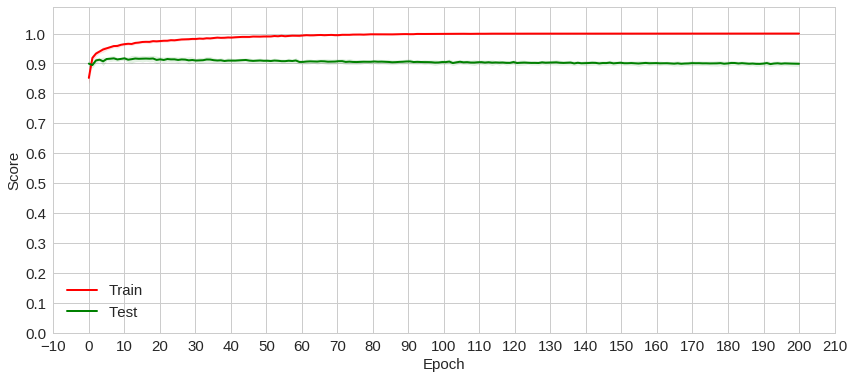

In [36]:
plot_mean_acc(tophistory)

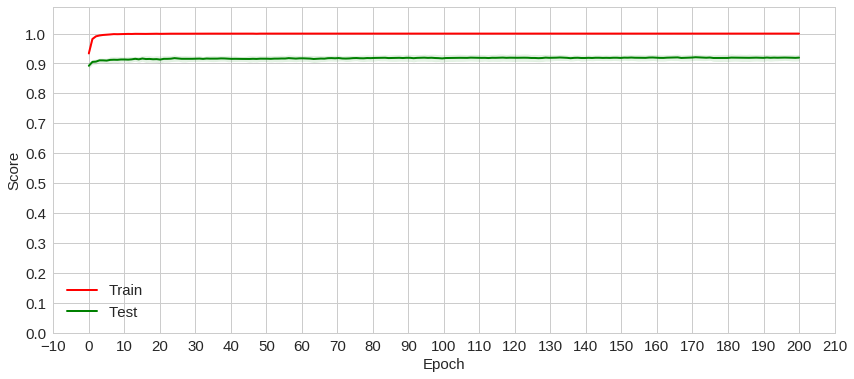

In [37]:
plot_mean_acc(history)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-0.9,10.9))
    plt.show()

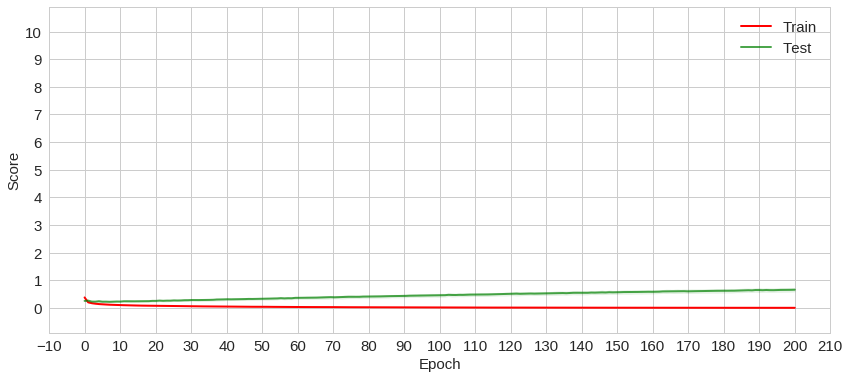

In [47]:
plot_mean_loss(tophistory)

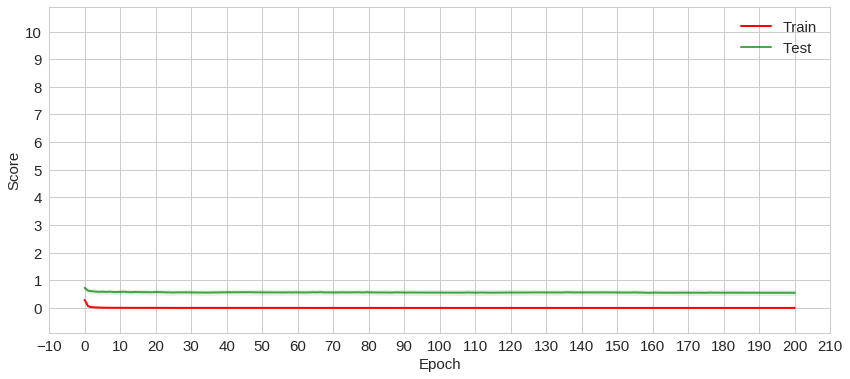

In [48]:
plot_mean_loss(history)